# Moving Horizon Estimation

This notebook processes battery cycling data, calculates aging factors, applies Moving Horizon Estimation (MHE) with Optuna optimization, and visualizes the results.

## Sections:
1. **Imports and Constants** - Libraries and global constants.
2. **Utility Functions** - General helper functions.
3. **Data Extraction Functions** - Extract data from .mat files.
4. **Aging Factor Calculations** - Compute temperature, SOC, and DOD factors.
5. **Battery Processing** - Process battery data and save results.
6. **MHE Optimization Functions** - Optimize and apply MHE with Optuna.
7. **Error Calculation** - Calculates RMSE and MAPE.
8. **Visualization Functions** - Plotting utilities.
9. **Main Execution** - Run the analysis for a specific battery.

## 1. Imports and Constants

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from datetime import datetime, timedelta
import optuna
from scipy.optimize import minimize

# Constants
NOMINAL_CAPACITY = 2.0  # Ah
AGING_SCALING_CONSTANT = 0.4

# Aging Factors Coefficients
TEMP_FACTOR_COEFFS = {'a': 1881.3, 'b': 6.0449}
SOC_FACTOR_COEFFS = {'a': 0.00285, 'b': 0.228, 'c': 5.273}
DOD_FACTOR_COEFFS = {'a': 2.15e-3, 'b': 1.5547e-3, 'c': 1.03e-3}
DATASET_FOLDER = 'battery_data'

## 2. Utility Functions

In [2]:
def load_mat_file(dataset_folder, battery_name):
    """
    Load a MATLAB (.mat) file for a specified battery from a dataset folder.

    Parameters:
    -----------
    dataset_folder : str
        Path to the folder containing the .mat files
    battery_name : str
        Name of the battery file (without .mat extension)

    Returns:
    --------
    dict
        Dictionary containing the data loaded from the .mat file

    Notes:
    ------
    This function uses scipy.io.loadmat to read MATLAB files.
    The full file path is constructed by joining dataset_folder with battery_name.mat
    """
    mat_path = os.path.join(dataset_folder, f"{battery_name}.mat")
    return loadmat(mat_path)

def parse_datetime(row_time):
    """
    Convert an array of time components into a datetime object.

    Parameters:
    -----------
    row_time : array-like
        Sequence containing [year, month, day, hour, minute, second] components
        All components should be numeric values

    Returns:
    --------
    datetime
        Datetime object representing the parsed time

    Notes:
    ------
    - Expects exactly 6 elements in row_time
    - Converts first 5 elements (year through minute) to integers
    - Adds seconds as a timedelta to preserve precision
    """
    return datetime(
        int(row_time[0]), int(row_time[1]), int(row_time[2]),
        int(row_time[3]), int(row_time[4])
    ) + timedelta(seconds=int(row_time[5]))

def save_dataframe(df, path):
    """
    Save a pandas DataFrame to a CSV file and print the save location.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to be saved
    path : str
        File path where the CSV will be saved

    Returns:
    --------
    None

    Notes:
    ------
    - Saves the DataFrame without the index column
    - Prints confirmation message with the path saved
    """
    df.to_csv(path, index=False)
    print(f"Data saved to: {path}")

## 3. Data Extraction Functions

In [3]:
def extract_discharge_data(mat, battery_name):
    """
    Extract discharge cycle data from a MATLAB file and create DataFrames.

    Parameters:
    -----------
    mat : dict
        Dictionary containing loaded .mat file data
    battery_name : str
        Name of the battery dataset within the .mat file

    Returns:
    --------
    tuple
        (discharge_df, capacity_df)
        - discharge_df: DataFrame with detailed discharge measurements
        - capacity_df: DataFrame with capacity-related data per cycle

    Notes:
    ------
    - Requires NOMINAL_CAPACITY to be defined as a global constant
    - Uses parse_datetime() to process timestamp data
    - Calculates State of Health (SOH) as percentage of nominal capacity
    - Processes only cycles marked as 'discharge' type
    """
    discharge_data, capacity_data = [], []
    cycle_counter = 1

    for cycle in mat[battery_name][0, 0]['cycle'][0]:
        if cycle['type'][0] == 'discharge':
            ambient_temp = cycle['ambient_temperature'][0][0]
            datetime_stamp = parse_datetime(cycle['time'][0])
            data = cycle['data'][0][0]
            capacity = data['Capacity'][0][0]
            soh = (capacity / NOMINAL_CAPACITY) * 100

            for i in range(len(data['Voltage_measured'][0])):
                discharge_data.append([
                    cycle_counter, ambient_temp, datetime_stamp, capacity, soh,
                    data['Voltage_measured'][0][i], data['Current_measured'][0][i],
                    data['Temperature_measured'][0][i], data['Current_load'][0][i],
                    data['Voltage_load'][0][i], data['Time'][0][i]
                ])

            capacity_data.append([cycle_counter, ambient_temp, datetime_stamp, capacity, soh])
            cycle_counter += 1

    discharge_df = pd.DataFrame(discharge_data, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'capacity', 'soh',
        'voltage_measured', 'current_measured', 'temperature_measured',
        'current', 'voltage', 'time'
    ])
    capacity_df = pd.DataFrame(capacity_data, columns=[
        'cycle', 'ambient_temperature', 'datetime', 'capacity', 'soh'
    ])

    return discharge_df, capacity_df

def extract_charge_data(mat, battery_name):
    """
    Extract charge cycle data from a MATLAB file and create a DataFrame.

    Parameters:
    -----------
    mat : dict
        Dictionary containing loaded .mat file data
    battery_name : str
        Name of the battery dataset within the .mat file

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing detailed charge cycle measurements

    Notes:
    ------
    - Uses parse_datetime() to process timestamp data
    - Processes only cycles marked as 'charge' type
    - Includes multiple measurements per cycle
    """
    charge_data = []
    cycle_counter = 1

    for cycle in mat[battery_name][0, 0]['cycle'][0]:
        if cycle['type'][0] == 'charge':
            ambient_temp = cycle['ambient_temperature'][0][0]
            datetime_stamp = parse_datetime(cycle['time'][0])
            data = cycle['data'][0][0]

            for i in range(len(data['Voltage_measured'][0])):
                charge_data.append([
                    cycle_counter, ambient_temp, datetime_stamp,
                    data['Voltage_measured'][0][i], data['Current_measured'][0][i],
                    data['Temperature_measured'][0][i], data['Current_charge'][0][i],
                    data['Voltage_charge'][0][i], data['Time'][0][i]
                ])
            cycle_counter += 1

    charge_df = pd.DataFrame(charge_data, columns=[
        'cycle', 'ambient_temperature', 'datetime',
        'voltage_measured', 'current_measured', 'temperature_measured',
        'current', 'voltage', 'time'
    ])

    return charge_df

## 4. Aging Factor Calculations

In [4]:
def factor_temperature(temp_celsius):
    """
    Calculate the temperature aging factor for battery degradation.

    Parameters:
    -----------
    temp_celsius : float
        Temperature in degrees Celsius

    Returns:
    --------
    float
        Temperature aging factor (1.0 if temp < 20°C, otherwise calculated)

    Notes:
    ------
    - Converts temperature to Kelvin (adding 273.15)
    - Uses Arrhenius-like equation for temperatures >= 20°C (293.15K)
    - Requires TEMP_FACTOR_COEFFS dictionary with 'a' and 'b' coefficients
    - Returns 1.0 (no acceleration) for temperatures below 20°C
    """
    temp_kelvin = temp_celsius + 273.15
    if temp_kelvin >= 293.15:
        return np.exp(-TEMP_FACTOR_COEFFS['a'] / temp_kelvin + TEMP_FACTOR_COEFFS['b'])
    return 1.0

def factor_soc(soc_mean):
    """
    Calculate the State of Charge (SOC) aging factor for battery degradation.

    Parameters:
    -----------
    soc_mean : float
        Mean State of Charge value (typically between 0 and 1 or 0 and 100)

    Returns:
    --------
    float
        SOC aging factor based on quadratic relationship

    Notes:
    ------
    - Uses a quadratic equation: a*x² - b*x + c
    - Requires SOC_FACTOR_COEFFS dictionary with 'a', 'b', and 'c' coefficients
    - Assumes soc_mean is in consistent units with the coefficients
    """
    return (SOC_FACTOR_COEFFS['a'] * soc_mean ** 2 -
            SOC_FACTOR_COEFFS['b'] * soc_mean + SOC_FACTOR_COEFFS['c'])

def factor_dod(dod):
    """
    Calculate the Depth of Discharge (DOD) aging factor for battery degradation.

    Parameters:
    -----------
    dod : float
        Depth of Discharge value (typically between 0 and 1 or 0 and 100)

    Returns:
    --------
    float
        DOD aging factor based on exponential relationship

    Notes:
    ------
    - Uses an exponential equation: a * exp(b * dod) + c
    - Requires DOD_FACTOR_COEFFS dictionary with 'a', 'b', and 'c' coefficients
    - Assumes dod is in consistent units with the coefficients
    """
    return DOD_FACTOR_COEFFS['a'] * np.exp(DOD_FACTOR_COEFFS['b'] * dod) + DOD_FACTOR_COEFFS['c']

## 5. Battery Processing

In [5]:
def process_battery(dataset_folder, battery_name, battery_params):
    """
    Process battery data from a .mat file, calculate aging metrics, and save results.

    Parameters:
    -----------
    dataset_folder : str
        Path to the folder containing the battery .mat files
    battery_name : str
        Name of the battery to process (without .mat extension)
    battery_params : dict
        Dictionary containing battery-specific parameters, including 'ambient_temp_celsius'

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing macro aging metrics and ground truth SOH

    Notes:
    ------
    - Requires global constants: NOMINAL_CAPACITY, AGING_SCALING_CONSTANT
    - Depends on helper functions: load_mat_file, extract_discharge_data, 
      extract_charge_data, save_dataframe, factor_temperature, factor_soc, factor_dod
    - Saves three CSV files: cycling data, capacity data, and macro aging data
    - Calculates cyclic aging based on temperature, SOC, and DOD factors
    """
    mat = load_mat_file(dataset_folder, battery_name)

    # Extract and save cycling data
    discharge_df, capacity_df = extract_discharge_data(mat, battery_name)
    charge_df = extract_charge_data(mat, battery_name)
    cycling_df = pd.concat([charge_df, discharge_df]).sort_values(['cycle', 'time'])
    cycling_path = os.path.join(dataset_folder, f"NASA_cycle_dataset_{battery_name}.csv")
    save_dataframe(cycling_df, cycling_path)

    # Save capacity data
    capacity_path = os.path.join(dataset_folder, f"capacity_soh_{battery_name}.csv")
    save_dataframe(capacity_df, capacity_path)

    # Calculate macro aging metrics
    ambient_temp = battery_params[battery_name]['ambient_temp_celsius']
    discharge_df['soc'] = (discharge_df['capacity'] / NOMINAL_CAPACITY) * 100
    discharge_df['temperature_measured'] = discharge_df['temperature_measured'].fillna(ambient_temp)

    macro_metrics = discharge_df.groupby('cycle').agg({
        'soc': lambda x: x.mean() / 100,
        'temperature_measured': 'mean'
    }).rename(columns={'soc': 'soc_mean', 'temperature_measured': 'cell_temp_mean_celsius'}).reset_index()

    macro_metrics['DOD'] = discharge_df.groupby('cycle')['soc'].agg(lambda x: (x.max() - x.min()) / 100).values
    macro_metrics['p_cyc'] = discharge_df.groupby('cycle')['soc'].agg(lambda x: x.max() / 100).values
    
    macro_metrics['capacity_loss_per_cycle'] = macro_metrics.apply(
        lambda row: factor_temperature(row['cell_temp_mean_celsius']) *
                    factor_soc(row['soc_mean']) * factor_dod(row['DOD']) * AGING_SCALING_CONSTANT, axis=1
    )

    macro_metrics['cumulative_capacity_loss'] = macro_metrics['capacity_loss_per_cycle'].cumsum().clip(upper=NOMINAL_CAPACITY)
    macro_metrics['Final_cyclic_aging'] = ((NOMINAL_CAPACITY - macro_metrics['cumulative_capacity_loss']) / NOMINAL_CAPACITY) * 100

    macro_df = macro_metrics.merge(capacity_df[['cycle', 'soh']], on='cycle', how='left')
    macro_df.rename(columns={'soh': 'ground_truth_soh'}, inplace=True)

    # Save macro aging data
    macro_path = os.path.join(dataset_folder, f"macro_aging_{battery_name}.csv")
    save_dataframe(macro_df, macro_path)

    # Verify output
    print(f"Columns in macro_df for {battery_name}: {macro_df.columns.tolist()}")
    print(macro_df[['cycle', 'Final_cyclic_aging', 'ground_truth_soh']].head())

    return macro_df

## 6. MHE Optimization Functions

In [6]:
def mhe_objective(trial, macro_df):
    """
    Objective function for Optuna to optimize Moving Horizon Estimation (MHE) window size.

    Parameters:
    -----------
    trial : optuna.trial.Trial
        Optuna trial object for suggesting hyperparameters
    macro_df : pandas.DataFrame
        DataFrame with 'Final_cyclic_aging' and 'ground_truth_soh' columns

    Returns:
    --------
    float
        Mean Squared Error (MSE) between corrected SOH and ground truth

    Formula:
    --------
    MSE = (1/n) * Σ(corrected_soh_i - ground_truth_soh_i)^2
    where:
        corrected_soh_i = k_opt * predicted_soh_segment_i
        k_opt minimizes Σ(k * predicted_soh_segment - ground_truth_segment)^2
    """
    num_cycles = len(macro_df)
    window_size = trial.suggest_int('window_size', 3, num_cycles)
    
    scaling_factor = macro_df['ground_truth_soh'].mean() / macro_df['Final_cyclic_aging'].mean()
    macro_df['Final_cyclic_aging_scaled'] = macro_df['Final_cyclic_aging'] * scaling_factor
    
    segment_starts = list(range(0, num_cycles, window_size))
    corrected_soh = []
    
    for start in segment_starts:
        end = min(start + window_size, num_cycles)
        segment_df = macro_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        ground_truth_segment = segment_df['ground_truth_soh'].values
        
        def segment_cost(k):
            return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
        
        result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
        k_opt = result.x[0]
        corrected_soh.extend(k_opt * predicted_soh_segment)
    
    mse = np.mean((np.array(corrected_soh) - macro_df['ground_truth_soh'])**2)
    return mse

def apply_mhe_with_optuna(battery_name, dataset_folder, n_trials=20, 
                         input_file_template="macro_aging_{battery}.csv"):
    """
    Apply MHE with Optuna-optimized window size to battery aging data.

    Parameters:
    -----------
    battery_name : str
        Name of the battery
    dataset_folder : str
        Path to the dataset folder
    n_trials : int, optional
        Number of Optuna trials (default: 20)
    input_file_template : str, optional
        Template for input file name (default: "macro_aging_{battery}.csv")

    Returns:
    --------
    tuple
        (macro_df, best_window_size)
        - macro_df: DataFrame with corrected SOH
        - best_window_size: Optimized window size

    Formula:
    --------
    Final_cyclic_aging_scaled = Final_cyclic_aging * (mean(ground_truth_soh) / mean(Final_cyclic_aging))
    Local_Corrected_SOH = k_opt * Final_cyclic_aging_scaled
    where k_opt minimizes Σ(k * predicted_soh_segment - ground_truth_segment)^2
    """
    input_path = os.path.join(dataset_folder, input_file_template.format(battery=battery_name))
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} not found.")
    
    macro_df = pd.read_csv(input_path)
    required_columns = ['cycle', 'Final_cyclic_aging', 'ground_truth_soh']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"Input file {input_path} missing columns: {missing_cols}")

    # Optimize window size
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: mhe_objective(trial, macro_df.copy()), n_trials=n_trials)
    best_window_size = study.best_params['window_size']
    print(f"\nBest Window Size for {battery_name}: {best_window_size} (MSE = {study.best_value:.4f})")

    # Apply MHE
    scaling_factor = macro_df['ground_truth_soh'].mean() / macro_df['Final_cyclic_aging'].mean()
    macro_df['Final_cyclic_aging_scaled'] = macro_df['Final_cyclic_aging'] * scaling_factor
    
    num_cycles = len(macro_df)
    segment_starts = list(range(0, num_cycles, best_window_size))
    corrected_soh = []
    local_correction_factors = []
    
    for start in segment_starts:
        end = min(start + best_window_size, num_cycles)
        segment_df = macro_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        ground_truth_segment = segment_df['ground_truth_soh'].values
        
        def segment_cost(k):
            return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
        
        result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
        k_opt = result.x[0]
        local_correction_factors.extend([k_opt] * len(segment_df))
        corrected_soh.extend(k_opt * predicted_soh_segment)
    
    macro_df['Local_Corrected_SOH'] = corrected_soh
    macro_df['Local_Correction_Factor'] = local_correction_factors

    # Save results
    output_file = os.path.join(dataset_folder, f"macro_aging_mhe_optuna_{battery_name}.csv")
    save_dataframe(macro_df, output_file)

    return macro_df, best_window_size

def optimize_mhe_parameters(battery_name, dataset_folder, max_trials_outer=10, max_trials_inner=20, 
                            input_file_template="macro_aging_{battery}.csv"):
    """
    Optimize MHE parameters including window size, correction factor bounds, and initial guess using nested Optuna.

    Parameters:
    -----------
    battery_name : str
        Name of the battery
    dataset_folder : str
        Path to the dataset folder
    max_trials_outer : int, optional
        Number of outer Optuna trials (default: 10)
    max_trials_inner : int, optional
        Maximum number of inner Optuna trials (default: 20)
    input_file_template : str, optional
        Template for input file name (default: "macro_aging_{battery}.csv")

    Returns:
    --------
    tuple
        (macro_df, best_params)
        - macro_df: DataFrame with corrected SOH
        - best_params: Dictionary of optimized parameters

    Formula:
    --------
    Final_cyclic_aging_scaled = Final_cyclic_aging * (mean(ground_truth_soh) / mean(Final_cyclic_aging))
    Local_Corrected_SOH = k_opt * Final_cyclic_aging_scaled
    where k_opt minimizes Σ(k * predicted_soh_segment - ground_truth_segment)^2
    subject to: lower_bound <= k_opt <= upper_bound
    """
    # Load the dataset
    input_path = os.path.join(dataset_folder, input_file_template.format(battery=battery_name))
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} not found.")
    
    macro_df = pd.read_csv(input_path)
    required_columns = ['cycle', 'Final_cyclic_aging', 'ground_truth_soh']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"Input file {input_path} missing columns: {missing_cols}")

    # Define the outer objective function
    def outer_objective(trial):
        lower_bound = trial.suggest_float('lower_bound', 0.1, 0.9)
        upper_bound = trial.suggest_float('upper_bound', 1.1, 2.0)
        if lower_bound >= upper_bound:
            raise optuna.exceptions.TrialPruned()
        initial_guess = trial.suggest_float('initial_guess', lower_bound, upper_bound)
        inner_trials = trial.suggest_int('inner_trials', 5, max_trials_inner)

        def inner_objective(trial, df):
            num_cycles = len(df)
            window_size = trial.suggest_int('window_size', 3, num_cycles)
            
            scaling_factor = df['ground_truth_soh'].mean() / df['Final_cyclic_aging'].mean()
            df['Final_cyclic_aging_scaled'] = df['Final_cyclic_aging'] * scaling_factor
            
            segment_starts = list(range(0, num_cycles, window_size))
            corrected_soh = []
            
            for start in segment_starts:
                end = min(start + window_size, num_cycles)
                segment_df = df.iloc[start:end]
                predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
                ground_truth_segment = segment_df['ground_truth_soh'].values
                
                def segment_cost(k):
                    return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
                
                result = minimize(segment_cost, initial_guess, bounds=[(lower_bound, upper_bound)], 
                                method='L-BFGS-B')
                k_opt = result.x[0]
                corrected_soh.extend(k_opt * predicted_soh_segment)
            
            mse = np.mean((np.array(corrected_soh) - df['ground_truth_soh'])**2)
            return mse

        inner_study = optuna.create_study(direction='minimize')
        inner_study.optimize(lambda trial: inner_objective(trial, macro_df.copy()), n_trials=inner_trials)
        return inner_study.best_value

    # Run outer optimization
    outer_study = optuna.create_study(direction='minimize')
    outer_study.optimize(outer_objective, n_trials=max_trials_outer)

    # Extract best parameters
    best_params = outer_study.best_params
    best_lower_bound = best_params['lower_bound']
    best_upper_bound = best_params['upper_bound']
    best_initial_guess = best_params['initial_guess']
    best_inner_trials = best_params['inner_trials']
    best_mse = outer_study.best_value

    print(f"\nOptimized Parameters for {battery_name}:")
    print(f"Lower Bound: {best_lower_bound:.4f}")
    print(f"Upper Bound: {best_upper_bound:.4f}")
    print(f"Initial Guess: {best_initial_guess:.4f}")
    print(f"Inner Trials: {best_inner_trials}")
    print(f"Best MSE: {best_mse:.4f}")

    # Apply MHE with optimized parameters
    def apply_best_mhe(df, lower_bound, upper_bound, initial_guess, inner_trials):
        num_cycles = len(df)
        scaling_factor = df['ground_truth_soh'].mean() / df['Final_cyclic_aging'].mean()
        df['Final_cyclic_aging_scaled'] = df['Final_cyclic_aging'] * scaling_factor
        
        def inner_objective(trial, df):
            num_cycles = len(df)
            window_size = trial.suggest_int('window_size', 3, num_cycles)
            
            segment_starts = list(range(0, num_cycles, window_size))
            corrected_soh = []
            
            for start in segment_starts:
                end = min(start + best_window_size, num_cycles)
                segment_df = df.iloc[start:end]
                predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
                ground_truth_segment = segment_df['ground_truth_soh'].values
                
                def segment_cost(k):
                    return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
                
                result = minimize(segment_cost, initial_guess, bounds=[(lower_bound, upper_bound)], 
                                method='L-BFGS-B')
                k_opt = result.x[0]
                corrected_soh.extend(k_opt * predicted_soh_segment)
            
            mse = np.mean((np.array(corrected_soh) - df['ground_truth_soh'])**2)
            return mse

        inner_study = optuna.create_study(direction='minimize')
        inner_study.optimize(lambda trial: inner_objective(trial, df.copy()), n_trials=inner_trials)
        best_window_size = inner_study.best_params['window_size']
        
        segment_starts = list(range(0, num_cycles, best_window_size))
        corrected_soh = []
        local_correction_factors = []
        
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = df.iloc[start:end]
            predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
            ground_truth_segment = segment_df['ground_truth_soh'].values
            
            def segment_cost(k):
                return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
            
            result = minimize(segment_cost, initial_guess, bounds=[(lower_bound, upper_bound)], 
                            method='L-BFGS-B')
            k_opt = result.x[0]
            local_correction_factors.extend([k_opt] * len(segment_df))
            corrected_soh.extend(k_opt * predicted_soh_segment)
        
        df['Local_Corrected_SOH'] = corrected_soh
        df['Local_Correction_Factor'] = local_correction_factors
        return df, best_window_size

    # Apply and save results
    macro_df, best_window_size = apply_best_mhe(macro_df, best_lower_bound, best_upper_bound, 
                                                best_initial_guess, best_inner_trials)
    output_file = os.path.join(dataset_folder, f"macro_aging_mhe_optuna_advanced_{battery_name}.csv")
    macro_df.to_csv(output_file, index=False)
    print(f"Best Window Size: {best_window_size}")
    print(f"Results saved to {output_file}")

    return macro_df, best_params

## 7. Error Calculation

In [7]:
def calculate_soh_errors(macro_df, battery_name, print_results=True):
    """
    Calculate RMSE and MAPE between ground truth SOH and MHE-corrected SOH.
    
    Parameters:
    - macro_df: DataFrame containing 'ground_truth_soh' and 'Local_Corrected_SOH'
    - battery_name: Name of the battery (e.g., "B0005")
    - print_results: Boolean to print the results (default: True)
    
    Returns:
    - rmse: Root Mean Squared Error
    - mape: Mean Absolute Percentage Error (in percentage)
    """
    # Check if required columns exist
    required_columns = ['ground_truth_soh', 'Local_Corrected_SOH']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    # Extract data
    ground_truth_soh = macro_df['ground_truth_soh'].values
    corrected_soh = macro_df['Local_Corrected_SOH'].values

    # Calculate RMSE
    rmse = np.sqrt(np.mean((ground_truth_soh - corrected_soh) ** 2))

    # Calculate MAPE (avoid division by zero by adding a small epsilon)
    epsilon = 1e-10  # Small value to prevent division by zero
    mape = np.mean(np.abs((ground_truth_soh - corrected_soh) / (ground_truth_soh + epsilon))) * 100

    # Print results if requested
    if print_results:
        print(f"\nError Metrics for Battery {battery_name}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.4f}%")

    return rmse, mape

## 8. Visualization Functions

In [8]:
def plot_soh(battery_name, macro_df, window_size):
    """
    Plot a comparison of different SOH metrics over discharge cycles.

    Parameters:
    -----------
    battery_name : str
        Name of the battery (e.g., "B0005")
    macro_df : pandas.DataFrame
        DataFrame containing 'cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 
        and 'Local_Corrected_SOH' columns
    window_size : int
        Window size used for MHE correction

    Returns:
    --------
    None
        Displays a matplotlib plot

    Notes:
    ------
    - Plots three lines: Ground Truth SOH, Final Cyclic Aging (scaled), and Local Corrected SOH
    - Uses a fixed figure size of 12x8 inches
    """
    plt.figure(figsize=(12, 8))
    plt.plot(macro_df['cycle'], macro_df['ground_truth_soh'], label='Ground Truth SOH', color='b')
    plt.plot(macro_df['cycle'], macro_df['Final_cyclic_aging_scaled'], label='Final Cyclic Aging (scaled)', color='r')
    plt.plot(macro_df['cycle'], macro_df['Local_Corrected_SOH'], label=f'Local Corrected SOH (Window {window_size})', color='g')
    plt.title(f'MHE SOH Estimation with Optuna for {battery_name}', fontsize=14)
    plt.xlabel('Discharge Cycle', fontsize=12)
    plt.ylabel('SOH (%)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_correction_factor(battery_name, macro_df, window_size):
    """
    Plot the trend of local correction factors over discharge cycles.

    Parameters:
    -----------
    battery_name : str
        Name of the battery (e.g., "B0005")
    macro_df : pandas.DataFrame
        DataFrame containing 'cycle' and 'Local_Correction_Factor' columns
    window_size : int
        Window size used for MHE correction

    Returns:
    --------
    None
        Displays a matplotlib step plot

    Notes:
    ------
    - Uses a step plot to show discrete changes in correction factor
    - Fixed figure size of 12x8 inches
    """
    plt.figure(figsize=(12, 8))
    plt.step(macro_df['cycle'], macro_df['Local_Correction_Factor'], 
             label=f'Local Correction Factor (Window {window_size})', color='c', where='post')
    plt.title(f'MHE Correction Factor Trend for {battery_name}', fontsize=14)
    plt.xlabel('Discharge Cycle', fontsize=12)
    plt.ylabel('Correction Factor', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_soh_comparison(macro_df, battery_name, output_folder="battery_data", save_plot=True):
    """
    Plot a comparison of ground truth SOH, estimated SOH, and MHE-corrected SOH against cycle number.

    Parameters:
    -----------
    macro_df : pandas.DataFrame
        DataFrame containing 'cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 
        and 'Local_Corrected_SOH' columns
    battery_name : str
        Name of the battery (e.g., "B0005")
    output_folder : str, optional
        Directory to save the plot (default: "battery_data")
    save_plot : bool, optional
        Whether to save the plot as a file (default: True)

    Returns:
    --------
    None
        Displays a matplotlib plot and optionally saves it to a file

    Notes:
    ------
    - Validates presence of required columns before plotting
    - Uses different line styles for visual distinction
    - Saves plot as PNG with 300 DPI if save_plot is True
    - Fixed figure size of 10x6 inches
    """
    # Check if required columns exist
    required_columns = ['cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 'Local_Corrected_SOH']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    # Extract data for plotting
    cycles = macro_df['cycle']
    ground_truth_soh = macro_df['ground_truth_soh']
    estimated_soh = macro_df['Final_cyclic_aging_scaled']
    mhe_corrected_soh = macro_df['Local_Corrected_SOH']

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(cycles, ground_truth_soh, label='Ground Truth SOH', color='blue', linewidth=2)
    plt.plot(cycles, estimated_soh, label='Estimated SOH (Scaled)', color='orange', linestyle='--', linewidth=2)
    plt.plot(cycles, mhe_corrected_soh, label='MHE-Corrected SOH', color='green', linestyle='-.', linewidth=2)

    # Add labels and title
    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH)')
    plt.title(f'SOH Comparison for Battery {battery_name}')
    plt.legend()
    plt.grid(True)

    # Save the plot if requested
    if save_plot:
        output_file = os.path.join(output_folder, f"soh_comparison_{battery_name}.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")

    # Display the plot
    plt.show()

## 9. Main Execution

In [9]:
import json
import os

# Define dataset folder (replace with your actual path)
DATASET_FOLDER = "battery_data"
"""
str
    Path to the directory containing battery data files and where output files will be saved.
    Must be updated to reflect the actual file system location.
"""

# Load battery parameters
with open("battery_params.json", 'r') as json_file:
    battery_params = json.load(json_file)
"""
dict
    Dictionary containing battery-specific parameters loaded from 'battery_params.json'.
    Expected format: {battery_name: {param_name: value, ...}, ...}
    File 'battery_params.json' must exist in the current working directory.
"""

# Process battery data
battery_name = 'B0005'
"""
str
    Name of the battery to process (e.g., 'B0005').
"""
print(f"\nProcessing battery: {battery_name}")
macro_df = process_battery(DATASET_FOLDER, battery_name, battery_params)
"""
pandas.DataFrame
    DataFrame containing processed battery data with macro aging metrics.
    Assumes process_battery() is defined elsewhere and returns a DataFrame.
"""

# Apply MHE with Optuna using the optimized parameters function
macro_df_mhe, best_params = optimize_mhe_parameters(battery_name, DATASET_FOLDER, 
                                                    max_trials_outer=10, max_trials_inner=20)
"""
tuple
    (macro_df_mhe, best_params)
    - macro_df_mhe: DataFrame with MHE-corrected SOH and additional columns
    - best_params: Dictionary of optimized MHE parameters (e.g., window_size, bounds)
    Assumes optimize_mhe_parameters() is defined elsewhere and returns these values.
    Parameters:
        - max_trials_outer: 10 trials for outer optimization loop
        - max_trials_inner: 20 trials for inner optimization loop
"""

# Extract best window size (optional handling if stored as DataFrame attribute)
best_window_size = macro_df_mhe.attrs.get('best_window_size', None)
"""
int or None
    Best window size used for MHE correction, if stored in DataFrame attributes.
    Note: optimize_mhe_parameters() already returns this via apply_best_mhe internally.
"""
if best_window_size is None:
    print("Warning: Best window size not explicitly returned; check optimize_mhe_parameters output.")

# Display results
print(f"\nLocal Corrected SOH for {battery_name} (Optimized Parameters):")
print(macro_df_mhe[['cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 
                    'Local_Corrected_SOH', 'Local_Correction_Factor']].head())
"""
Displays the first 5 rows of key columns from the MHE-corrected DataFrame:
    - cycle: Discharge cycle number
    - ground_truth_soh: Measured State of Health
    - Final_cyclic_aging_scaled: Scaled estimated SOH before MHE correction
    - Local_Corrected_SOH: MHE-corrected SOH
    - Local_Correction_Factor: Local correction factor applied per segment
"""

# Visualize results
plot_soh_comparison(macro_df_mhe, battery_name, DATASET_FOLDER)
"""
Generates and displays a plot comparing ground truth SOH, estimated SOH, and MHE-corrected SOH.
Saves the plot to DATASET_FOLDER as a PNG file.
Assumes plot_soh_comparison() is defined elsewhere.
"""

# Calculate and display error metrics
rmse, mape = calculate_soh_errors(macro_df_mhe, battery_name)
"""
tuple
    (rmse, mape)
    - rmse: Root Mean Squared Error between corrected SOH and ground truth
    - mape: Mean Absolute Percentage Error between corrected SOH and ground truth
    Assumes calculate_soh_errors() is defined elsewhere and returns these metrics.
    Note: This function is not defined in the provided code, so its exact behavior is assumed.
"""


Processing battery: B0005


[I 2025-03-19 08:43:38,412] A new study created in memory with name: no-name-d0d67fb6-8a30-46e1-aa89-0afa8fce5920
[I 2025-03-19 08:43:38,415] A new study created in memory with name: no-name-ed76d6ed-3888-4390-97f8-9469b3de033a
[I 2025-03-19 08:43:38,426] Trial 0 finished with value: 10.912180094562759 and parameters: {'window_size': 119}. Best is trial 0 with value: 10.912180094562759.
[I 2025-03-19 08:43:38,444] Trial 1 finished with value: 7.276113664917195 and parameters: {'window_size': 55}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,460] Trial 2 finished with value: 16.915832568744722 and parameters: {'window_size': 149}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,479] Trial 3 finished with value: 11.638362474344373 and parameters: {'window_size': 102}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,494] Trial 4 finished with value: 27.1524979133132 and parameters: {'window_size': 165}. Best is trial 1 w

Data saved to: battery_data\NASA_cycle_dataset_B0005.csv
Data saved to: battery_data\capacity_soh_B0005.csv
Data saved to: battery_data\macro_aging_B0005.csv
Columns in macro_df for B0005: ['cycle', 'soc_mean', 'cell_temp_mean_celsius', 'DOD', 'p_cyc', 'capacity_loss_per_cycle', 'cumulative_capacity_loss', 'Final_cyclic_aging', 'ground_truth_soh']
   cycle  Final_cyclic_aging  ground_truth_soh
0      1           99.711120         92.824371
1      2           99.421286         92.316362
2      3           99.131861         91.767460
3      4           98.843180         91.763126
4      5           98.555266         91.732275


[I 2025-03-19 08:43:38,512] Trial 5 finished with value: 11.753648594498424 and parameters: {'window_size': 101}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,527] Trial 6 finished with value: 7.784258898716995 and parameters: {'window_size': 57}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,541] Trial 7 finished with value: 12.81683352217461 and parameters: {'window_size': 86}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,560] Trial 8 finished with value: 13.024326790301794 and parameters: {'window_size': 135}. Best is trial 1 with value: 7.276113664917195.
[I 2025-03-19 08:43:38,635] Trial 9 finished with value: 0.5404245811763106 and parameters: {'window_size': 8}. Best is trial 9 with value: 0.5404245811763106.
[I 2025-03-19 08:43:38,707] Trial 10 finished with value: 0.3304350661801294 and parameters: {'window_size': 6}. Best is trial 10 with value: 0.3304350661801294.
[I 2025-03-19 08:43:38,896] Trial 11 f


Optimized Parameters for B0005:
Lower Bound: 0.7310
Upper Bound: 1.7922
Initial Guess: 1.0406
Inner Trials: 18
Best MSE: 0.2238


[I 2025-03-19 08:43:43,855] Trial 9 finished with value: 0.8565995818060108 and parameters: {'window_size': 12}. Best is trial 9 with value: 0.8565995818060108.
[I 2025-03-19 08:43:43,984] Trial 10 finished with value: 0.33386750520867636 and parameters: {'window_size': 5}. Best is trial 10 with value: 0.33386750520867636.
[I 2025-03-19 08:43:44,029] Trial 11 finished with value: 1.0490219451934255 and parameters: {'window_size': 14}. Best is trial 10 with value: 0.33386750520867636.
[I 2025-03-19 08:43:44,240] Trial 12 finished with value: 0.22378002151655546 and parameters: {'window_size': 3}. Best is trial 12 with value: 0.22378002151655546.
[I 2025-03-19 08:43:44,416] Trial 13 finished with value: 0.22378002151655546 and parameters: {'window_size': 3}. Best is trial 12 with value: 0.22378002151655546.
[I 2025-03-19 08:43:44,440] Trial 14 finished with value: 7.391729111221624 and parameters: {'window_size': 63}. Best is trial 12 with value: 0.22378002151655546.
[I 2025-03-19 08:43:

Best Window Size: 3
Results saved to battery_data\macro_aging_mhe_optuna_advanced_B0005.csv

Local Corrected SOH for B0005 (Optimized Parameters):
   cycle  ground_truth_soh  Final_cyclic_aging_scaled  Local_Corrected_SOH  \
0      1         92.824371                 103.780125            92.572192   
1      2         92.316362                 103.478463            92.303108   
2      3         91.767460                 103.177228            92.034405   
3      4         91.763126                 102.876767            92.027105   
4      5         91.732275                 102.577103            91.759044   

   Local_Correction_Factor  
0                 0.892003  
1                 0.892003  
2                 0.892003  
3                 0.894537  
4                 0.894537  
Plot saved to battery_data\soh_comparison_B0005.png



Error Metrics for Battery B0005:
RMSE: 0.4731
MAPE: 0.3057%


In [10]:
def optimize_global_correction_factor(battery_name, dataset_folder, n_trials=50, 
                                      input_file_template="macro_aging_{battery}.csv"):
    """
    Optimize a global correction factor using Optuna to minimize MSE between corrected and ground truth SOH.
    
    Parameters:
    - battery_name: Name of the battery (e.g., "B0005")
    - dataset_folder: Directory containing the input data
    - n_trials: Number of Optuna trials (default: 50)
    - input_file_template: Template for input file name (default: "macro_aging_{battery}.csv")
    
    Returns:
    - macro_df: DataFrame with the globally corrected SOH
    - best_k_global: The optimized global correction factor
    """
    # Load the dataset
    input_path = os.path.join(dataset_folder, input_file_template.format(battery=battery_name))
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} not found.")
    
    macro_df = pd.read_csv(input_path)
    required_columns = ['cycle', 'Final_cyclic_aging', 'ground_truth_soh']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"Input file {input_path} missing columns: {missing_cols}")

    # Apply initial scaling factor
    scaling_factor = macro_df['ground_truth_soh'].mean() / macro_df['Final_cyclic_aging'].mean()
    macro_df['Final_cyclic_aging_scaled'] = macro_df['Final_cyclic_aging'] * scaling_factor

    # Define the objective function for Optuna
    def objective(trial):
        k_global = trial.suggest_float('k_global', 0.5, 1.5)  # Range for the global correction factor
        corrected_soh = macro_df['Final_cyclic_aging_scaled'] * k_global
        mse = np.mean((corrected_soh - macro_df['ground_truth_soh']) ** 2)
        return mse

    # Run Optuna optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Extract the best global correction factor
    best_k_global = study.best_params['k_global']
    best_mse = study.best_value

    print(f"\nOptimized Global Correction Factor for {battery_name}:")
    print(f"Best k_global: {best_k_global:.4f}")
    print(f"Best MSE: {best_mse:.4f}")

    # Apply the best global correction factor
    macro_df['Global_Corrected_SOH'] = macro_df['Final_cyclic_aging_scaled'] * best_k_global

    # Save results
    output_file = os.path.join(dataset_folder, f"macro_aging_global_optuna_{battery_name}.csv")
    macro_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

    return macro_df, best_k_global

# Example usage
macro_df_global, best_k_global = optimize_global_correction_factor("B0005", "battery_data", n_trials=50)

[I 2025-03-19 08:46:15,592] A new study created in memory with name: no-name-4e14e95e-6afa-449d-ba39-7d4ad2f11363
[I 2025-03-19 08:46:15,594] Trial 0 finished with value: 480.8885221370798 and parameters: {'k_global': 1.2530634185355958}. Best is trial 0 with value: 480.8885221370798.
[I 2025-03-19 08:46:15,594] Trial 1 finished with value: 259.8380013702611 and parameters: {'k_global': 0.7981375330715439}. Best is trial 1 with value: 259.8380013702611.
[I 2025-03-19 08:46:15,594] Trial 2 finished with value: 284.7269776339845 and parameters: {'k_global': 1.1871303995012534}. Best is trial 1 with value: 259.8380013702611.
[I 2025-03-19 08:46:15,612] Trial 3 finished with value: 642.2690389135021 and parameters: {'k_global': 1.2969421460850004}. Best is trial 1 with value: 259.8380013702611.
[I 2025-03-19 08:46:15,617] Trial 4 finished with value: 433.74032853402815 and parameters: {'k_global': 1.238801232533672}. Best is trial 1 with value: 259.8380013702611.
[I 2025-03-19 08:46:15,621


Optimized Global Correction Factor for B0005:
Best k_global: 0.9877
Best MSE: 30.0466
Results saved to battery_data\macro_aging_global_optuna_B0005.csv


In [11]:
def plot_soh_comparison(macro_df, battery_name, output_folder="battery_data", save_plot=True, 
                        global_df=None):
    """
    Plot a comparison of ground truth SOH, estimated SOH, MHE-corrected SOH, and optionally 
    global-corrected SOH against cycle number.

    Parameters:
    -----------
    macro_df : pandas.DataFrame
        DataFrame containing 'cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 
        and 'Local_Corrected_SOH' columns
    battery_name : str
        Name of the battery (e.g., "B0005")
    output_folder : str, optional
        Directory to save the plot (default: "battery_data")
    save_plot : bool, optional
        Whether to save the plot as a file (default: True)
    global_df : pandas.DataFrame, optional
        DataFrame containing 'Global_Corrected_SOH' column for additional comparison (default: None)

    Returns:
    --------
    None
        Displays a matplotlib plot and optionally saves it to a file

    Notes:
    ------
    - Validates presence of required columns in macro_df before plotting
    - Plots up to four SOH metrics with distinct colors and line styles:
        - Ground Truth SOH: solid blue
        - Estimated SOH (Scaled): dashed orange
        - MHE-Corrected SOH: dash-dot green
        - Global-Corrected SOH (if provided): dotted red
    - Saves plot as PNG with 300 DPI if save_plot is True
    - Figure size is fixed at 12x6 inches
    """
    required_columns = ['cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 'Local_Corrected_SOH']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    cycles = macro_df['cycle']
    ground_truth_soh = macro_df['ground_truth_soh']
    estimated_soh = macro_df['Final_cyclic_aging_scaled']
    mhe_corrected_soh = macro_df['Local_Corrected_SOH']

    plt.figure(figsize=(12, 6))
    plt.plot(cycles, ground_truth_soh, label='Ground Truth SOH', color='blue', linewidth=2)
    plt.plot(cycles, estimated_soh, label='Estimated SOH (Scaled)', color='orange', linestyle='--', linewidth=2)
    plt.plot(cycles, mhe_corrected_soh, label='MHE-Corrected SOH', color='green', linestyle='-.', linewidth=2)

    if global_df is not None and 'Global_Corrected_SOH' in global_df.columns:
        plt.plot(cycles, global_df['Global_Corrected_SOH'], label='Global-Corrected SOH', 
                 color='red', linestyle=':', linewidth=2)

    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH)')
    plt.title(f'SOH Comparison for Battery {battery_name}')
    plt.legend()
    plt.grid(True)

    if save_plot:
        output_file = os.path.join(output_folder, f"soh_comparison_{battery_name}.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")

    plt.show()

Plot saved to battery_data\soh_comparison_B0005.png


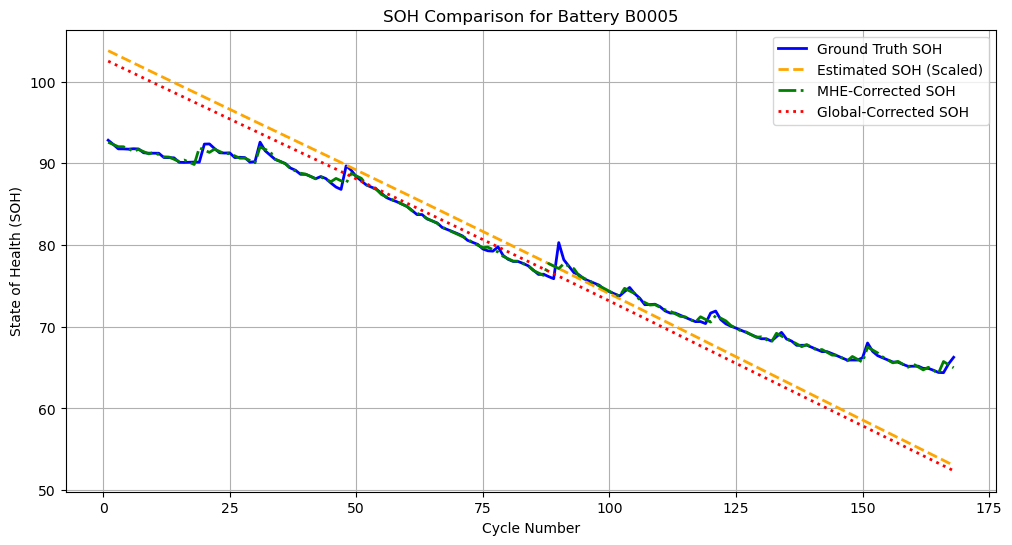

In [12]:
plot_soh_comparison(macro_df_mhe, battery_name, DATASET_FOLDER, global_df=macro_df_global)

In [13]:
import optuna
import numpy as np
import pandas as pd
import os

def optimize_segmented_global_correction(battery_name, dataset_folder, segment_size=30, n_trials=50, 
                                         input_file_template="macro_aging_{battery}.csv"):
    """
    Optimize a global correction factor for each 30-cycle segment using Optuna.
    
    Parameters:
    - battery_name: Name of the battery (e.g., "B0005")
    - dataset_folder: Directory containing the input data
    - segment_size: Number of cycles per segment (default: 30)
    - n_trials: Number of Optuna trials per segment (default: 50)
    - input_file_template: Template for input file name (default: "macro_aging_{battery}.csv")
    
    Returns:
    - macro_df: DataFrame with the segmented globally corrected SOH
    - best_k_globals: List of optimized global correction factors for each segment
    """
    # Load the dataset
    input_path = os.path.join(dataset_folder, input_file_template.format(battery=battery_name))
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Input file {input_path} not found.")
    
    macro_df = pd.read_csv(input_path)
    required_columns = ['cycle', 'Final_cyclic_aging', 'ground_truth_soh']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"Input file {input_path} missing columns: {missing_cols}")

    # Apply initial scaling factor
    scaling_factor = macro_df['ground_truth_soh'].mean() / macro_df['Final_cyclic_aging'].mean()
    macro_df['Final_cyclic_aging_scaled'] = macro_df['Final_cyclic_aging'] * scaling_factor

    # Segment the data into fixed 30-cycle chunks
    num_cycles = len(macro_df)
    segment_starts = list(range(0, num_cycles, segment_size))
    corrected_soh = []
    best_k_globals = []

    # Optimize k_global for each segment
    for start in segment_starts:
        end = min(start + segment_size, num_cycles)
        segment_df = macro_df.iloc[start:end]
        if len(segment_df) == 0:  # Skip empty segments
            continue

        # Define the objective function for this segment
        def objective(trial):
            k_global = trial.suggest_float('k_global', 0.5, 1.5)  # Range for the correction factor
            corrected_soh_segment = segment_df['Final_cyclic_aging_scaled'] * k_global
            mse = np.mean((corrected_soh_segment - segment_df['ground_truth_soh']) ** 2)
            return mse

        # Run Optuna optimization for this segment
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)

        # Extract the best k_global for this segment
        best_k_global = study.best_params['k_global']
        best_k_globals.append(best_k_global)
        corrected_soh_segment = segment_df['Final_cyclic_aging_scaled'] * best_k_global
        corrected_soh.extend(corrected_soh_segment)

        print(f"Segment {start}-{end}: Best k_global = {best_k_global:.4f}, MSE = {study.best_value:.4f}")

    # Ensure corrected_soh matches the DataFrame length
    if len(corrected_soh) != len(macro_df):
        raise ValueError(f"Length mismatch: corrected_soh ({len(corrected_soh)}) vs macro_df ({len(macro_df)})")

    # Add the segmented corrected SOH to the DataFrame
    macro_df['Segmented_Global_Corrected_SOH'] = corrected_soh

    # Assign segment-wise correction factors (repeat each k_global for its segment)
    correction_factors = []
    for i, start in enumerate(segment_starts):
        end = min(start + segment_size, num_cycles)
        correction_factors.extend([best_k_globals[i]] * (end - start))
    macro_df['Segmented_Global_Correction_Factor'] = correction_factors

    # Save results
    output_file = os.path.join(dataset_folder, f"macro_aging_segmented_global_optuna_{battery_name}.csv")
    macro_df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")

    return macro_df, best_k_globals

# Example usage
macro_df_segmented, best_k_globals = optimize_segmented_global_correction("B0005", "battery_data", segment_size=30, n_trials=50)

[I 2025-03-19 08:49:58,800] A new study created in memory with name: no-name-a0554a75-0459-419f-adbd-514775fda48f
[I 2025-03-19 08:49:58,807] Trial 0 finished with value: 1110.1470532602132 and parameters: {'k_global': 1.250396245945645}. Best is trial 0 with value: 1110.1470532602132.
[I 2025-03-19 08:49:58,811] Trial 1 finished with value: 657.0072347569834 and parameters: {'k_global': 1.1729259965184073}. Best is trial 1 with value: 657.0072347569834.
[I 2025-03-19 08:49:58,818] Trial 2 finished with value: 1743.4821317018148 and parameters: {'k_global': 1.3353359061993644}. Best is trial 1 with value: 657.0072347569834.
[I 2025-03-19 08:49:58,818] Trial 3 finished with value: 400.10337947518667 and parameters: {'k_global': 1.1160918543640514}. Best is trial 3 with value: 400.10337947518667.
[I 2025-03-19 08:49:58,818] Trial 4 finished with value: 95.55423083286097 and parameters: {'k_global': 1.0121132189298434}. Best is trial 4 with value: 95.55423083286097.
[I 2025-03-19 08:49:58

Segment 0-30: Best k_global = 0.9182, MSE = 4.3857


[I 2025-03-19 08:49:59,544] Trial 21 finished with value: 1.5612600125639453 and parameters: {'k_global': 0.9669757370754184}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,554] Trial 22 finished with value: 7.968036632546967 and parameters: {'k_global': 1.0025523425107385}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,554] Trial 23 finished with value: 98.72963651992903 and parameters: {'k_global': 0.8647228380895235}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,569] Trial 24 finished with value: 99.27499005532681 and parameters: {'k_global': 1.0831512676049093}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,586] Trial 25 finished with value: 404.6483646448034 and parameters: {'k_global': 1.195587669232539}. Best is trial 21 with value: 1.5612600125639453.
[I 2025-03-19 08:49:59,586] Trial 26 finished with value: 1.1815765944838208 and parameters: {'k_global': 0.9740444438032694}

Segment 30-60: Best k_global = 0.9740, MSE = 1.1816


[I 2025-03-19 08:50:00,034] Trial 21 finished with value: 0.9402740733735074 and parameters: {'k_global': 0.975730620604974}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,052] Trial 22 finished with value: 217.12035950435177 and parameters: {'k_global': 1.1606913882060435}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,069] Trial 23 finished with value: 2.431439741315303 and parameters: {'k_global': 0.9646812498690776}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,123] Trial 24 finished with value: 99.41379506281804 and parameters: {'k_global': 0.8585876473651659}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,136] Trial 25 finished with value: 2.2149663850358667 and parameters: {'k_global': 0.9949448766893186}. Best is trial 21 with value: 0.9402740733735074.
[I 2025-03-19 08:50:00,153] Trial 26 finished with value: 34.95497426742966 and parameters: {'k_global': 1.052011452475161}

Segment 60-90: Best k_global = 0.9822, MSE = 0.8223


[I 2025-03-19 08:50:00,666] Trial 24 finished with value: 163.29065367344037 and parameters: {'k_global': 0.8399067369157649}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,683] Trial 25 finished with value: 125.3119259069776 and parameters: {'k_global': 1.1701871649615287}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,683] Trial 26 finished with value: 1.9791349815452806 and parameters: {'k_global': 1.03169819021102}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,700] Trial 27 finished with value: 66.40183353775562 and parameters: {'k_global': 0.9040597235740446}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,700] Trial 28 finished with value: 616.3411763685363 and parameters: {'k_global': 0.6733396139420882}. Best is trial 12 with value: 0.7059994992118999.
[I 2025-03-19 08:50:00,717] Trial 29 finished with value: 299.257865669829 and parameters: {'k_global': 0.7773776450078378}. 

Segment 90-120: Best k_global = 1.0166, MSE = 0.6908


[I 2025-03-19 08:50:01,100] Trial 22 finished with value: 2.4907341099209512 and parameters: {'k_global': 1.0896805551149185}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,100] Trial 23 finished with value: 211.72301315743002 and parameters: {'k_global': 1.309065783739563}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,116] Trial 24 finished with value: 2.7136097130849888 and parameters: {'k_global': 1.0921746842039188}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,116] Trial 25 finished with value: 90.15795201398505 and parameters: {'k_global': 1.2283678922591907}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,134] Trial 26 finished with value: 3.8293232854388126 and parameters: {'k_global': 1.1005770763656912}. Best is trial 22 with value: 2.4907341099209512.
[I 2025-03-19 08:50:01,150] Trial 27 finished with value: 106.44875313514221 and parameters: {'k_global': 0.91789804560113

Segment 120-150: Best k_global = 1.0772, MSE = 2.1201


[I 2025-03-19 08:50:01,567] Trial 23 finished with value: 70.63311560628851 and parameters: {'k_global': 1.3268849271770589}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,583] Trial 24 finished with value: 27.155630462685597 and parameters: {'k_global': 1.2682065681305676}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,601] Trial 25 finished with value: 6.009874026616562 and parameters: {'k_global': 1.141824946525176}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,604] Trial 26 finished with value: 183.96459936229334 and parameters: {'k_global': 0.9357023764217455}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,620] Trial 27 finished with value: 153.94019624098777 and parameters: {'k_global': 1.3994644095625992}. Best is trial 11 with value: 2.035733769063186.
[I 2025-03-19 08:50:01,636] Trial 28 finished with value: 1.9550217774324874 and parameters: {'k_global': 1.1795781088410993}. B

Segment 150-168: Best k_global = 1.1796, MSE = 1.9550

Results saved to battery_data\macro_aging_segmented_global_optuna_B0005.csv


In [14]:
def plot_soh_comparison(macro_df, battery_name, output_folder="battery_data", save_plot=True, 
                        segmented_df=None):
    """
    Plot a comparison of ground truth SOH, estimated SOH, MHE-corrected SOH, and optionally 
    segmented global-corrected SOH against cycle number.

    Parameters:
    -----------
    macro_df : pandas.DataFrame
        DataFrame containing 'cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 
        and 'Local_Corrected_SOH' columns
    battery_name : str
        Name of the battery (e.g., "B0005")
    output_folder : str, optional
        Directory to save the plot (default: "battery_data")
    save_plot : bool, optional
        Whether to save the plot as a file (default: True)
    segmented_df : pandas.DataFrame, optional
        DataFrame containing 'Segmented_Global_Corrected_SOH' column for additional comparison 
        (default: None)

    Returns:
    --------
    None
        Displays a matplotlib plot and optionally saves it to a file

    Notes:
    ------
    - Validates presence of required columns in macro_df before plotting
    - Plots up to four SOH metrics with distinct colors and line styles:
        - Ground Truth SOH: solid blue
        - Estimated SOH (Scaled): dashed orange
        - MHE-Corrected SOH: dash-dot green
        - Segmented Global-Corrected SOH (if provided): dotted red
    - Saves plot as PNG with 300 DPI if save_plot is True
    - Figure size is fixed at 12x6 inches
    """
    required_columns = ['cycle', 'ground_truth_soh', 'Final_cyclic_aging_scaled', 'Local_Corrected_SOH']
    missing_cols = [col for col in required_columns if col not in macro_df.columns]
    if missing_cols:
        raise ValueError(f"DataFrame missing required columns: {missing_cols}")

    cycles = macro_df['cycle']
    ground_truth_soh = macro_df['ground_truth_soh']
    estimated_soh = macro_df['Final_cyclic_aging_scaled']
    mhe_corrected_soh = macro_df['Local_Corrected_SOH']

    plt.figure(figsize=(12, 6))
    plt.plot(cycles, ground_truth_soh, label='Ground Truth SOH', color='blue', linewidth=2)
    plt.plot(cycles, estimated_soh, label='Estimated SOH (Scaled)', color='orange', linestyle='--', linewidth=2)
    plt.plot(cycles, mhe_corrected_soh, label='MHE-Corrected SOH', color='green', linestyle='-.', linewidth=2)

    if segmented_df is not None and 'Segmented_Global_Corrected_SOH' in segmented_df.columns:
        plt.plot(cycles, segmented_df['Segmented_Global_Corrected_SOH'], 
                 label='Segmented Global-Corrected SOH', color='red', linestyle=':', linewidth=2)

    plt.xlabel('Cycle Number')
    plt.ylabel('State of Health (SOH)')
    plt.title(f'SOH Comparison for Battery {battery_name}')
    plt.legend()
    plt.grid(True)

    if save_plot:
        output_file = os.path.join(output_folder, f"soh_comparison_{battery_name}.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")

    plt.show()

Plot saved to battery_data\soh_comparison_B0005.png


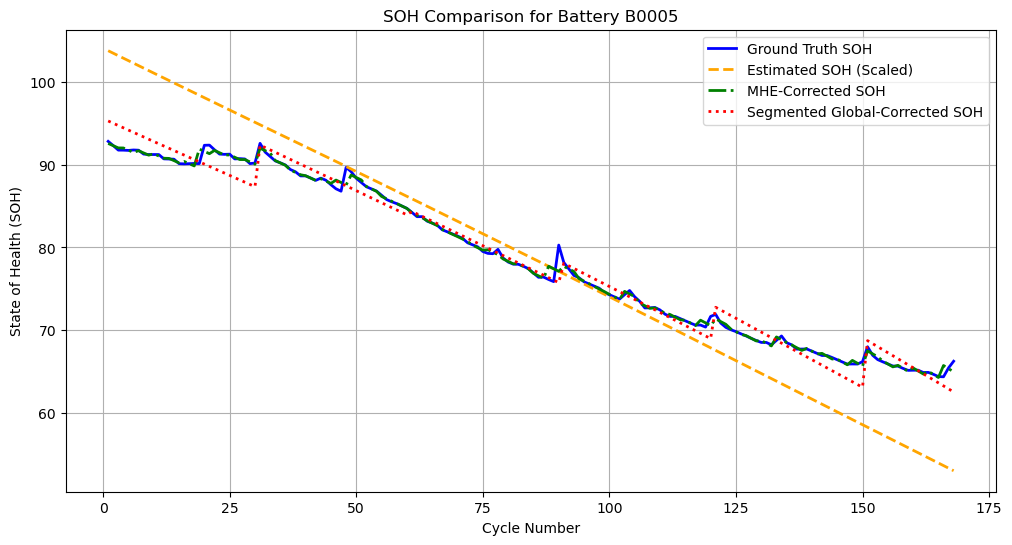

In [15]:
plot_soh_comparison(macro_df_mhe, battery_name, DATASET_FOLDER, segmented_df=macro_df_segmented)

In [19]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import optuna
import os
from collections import defaultdict

# Objective function for Optuna to optimize global window size and correction factor per category
def mhe_category_objective(trial, category_df):
    num_cycles = len(category_df)
    window_size = trial.suggest_int('window_size', 3, num_cycles)
    global_k = trial.suggest_float('global_k', 0.5, 1.5)
    
    # Scale Final_cyclic_aging for the category
    scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
    category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
    
    # Apply local correction with suggested window size and global k
    segment_starts = list(range(0, num_cycles, window_size))
    corrected_soh = []
    
    for start in segment_starts:
        end = min(start + window_size, num_cycles)
        segment_df = category_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        corrected_soh.extend(global_k * predicted_soh_segment)
    
    # Calculate MSE for the category
    mse = np.mean((np.array(corrected_soh) - category_df['ground_truth_soh'])**2)
    
    # Enforce MSE between 9 and 25 %² (RMSE 3% to 5%)
    if mse < 9 or mse > 25:
        penalty = abs(mse - 17)  # Center of target range
        return mse + penalty * 1000
    
    return mse

# Process all batteries by test condition categories
def process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials=50):
    # Load battery parameters
    with open("battery_params.json", 'r') as json_file:
        params = json.load(json_file)
    
    # Categorize batteries by test conditions
    categories = defaultdict(list)
    for battery_name, param in params.items():
        key = (param['ambient_temp_celsius'], param['cutoff_voltage'], param['eol_capacity'])
        categories[key].append(battery_name)
    
    # Process each category
    all_results = {}
    
    for test_condition, battery_names in categories.items():
        print(f"\nProcessing category with conditions: {test_condition}")
        print(f"Batteries: {battery_names}")
        
        category_dfs = []
        for battery_name in battery_names:
            macro_df = process_battery(dataset_folder, battery_name, params)
            category_dfs.append(macro_df)
        
        # Combine data for this category
        category_df = pd.concat(category_dfs, ignore_index=True)
        print(f"Category data shape: {category_df.shape}")
        
        # Optimize for this category
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: mhe_category_objective(trial, category_df.copy()), n_trials=n_trials)
        
        best_window_size = study.best_params['window_size']
        global_k = study.best_params['global_k']
        best_mse = study.best_value
        
        print(f"\nOptimal Parameters for Condition {test_condition}:")
        print(f"Best Window Size: {best_window_size}")
        print(f"Global Correction Factor (k): {global_k:.4f}")
        print(f"Best MSE: {best_mse:.4f}")
        
        # Apply global correction
        scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
        category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
        num_cycles = len(category_df)
        segment_starts = list(range(0, num_cycles, best_window_size))
        corrected_soh = []
        local_correction_factors = []
        
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = category_df.iloc[start:end]
            predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
            corrected_soh.extend(global_k * predicted_soh_segment)
            local_correction_factors.extend([global_k] * len(segment_df))
        
        category_df['Local_Corrected_SOH'] = corrected_soh
        category_df['Global_Correction_Factor'] = local_correction_factors
        
        # Save results for this category
        condition_str = f"temp_{test_condition[0]}_cutoff_{test_condition[1]}_eol_{test_condition[2]}"
        output_file = os.path.join(dataset_folder, f"category_{condition_str}_mhe_optuna.csv")
        category_df.to_csv(output_file, index=False)
        print(f"Category corrected SOH data saved to: {output_file}")
        
        # Store results
        all_results[condition_str] = {
            'window_size': best_window_size,
            'global_k': global_k,
            'mse': best_mse,
            'df': category_df
        }
        
        # Plot for the first battery in the category
        sample_df = category_df[category_df['battery_id'] == battery_names[0]]
        plt.figure(figsize=(12, 8))
        plt.plot(sample_df['cycle'], sample_df['ground_truth_soh'], label='Ground Truth SOH', color='b')
        plt.plot(sample_df['cycle'], sample_df['Final_cyclic_aging_scaled'], label='Final Cyclic Aging (scaled)', color='r')
        plt.plot(sample_df['cycle'], sample_df['Local_Corrected_SOH'], label=f'Corrected SOH (k={global_k:.4f})', color='g')
        plt.title(f'SOH Estimation for {battery_names[0]} in Category {condition_str}', fontsize=14)
        plt.xlabel('Discharge Cycle', fontsize=12)
        plt.ylabel('SOH (%)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return all_results

with open("battery_params.json", 'r') as json_file:
    battery_params = json.load(json_file)
dataset_folder = 'battery_data'
results = process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials=50)


Processing category with conditions: (24, 2.7, 1.4)
Batteries: ['B0005', 'B0028']
Data saved to: battery_data\NASA_cycle_dataset_B0005.csv
Data saved to: battery_data\capacity_soh_B0005.csv
Data saved to: battery_data\macro_aging_B0005.csv
Columns in macro_df for B0005: ['cycle', 'soc_mean', 'cell_temp_mean_celsius', 'DOD', 'p_cyc', 'capacity_loss_per_cycle', 'cumulative_capacity_loss', 'Final_cyclic_aging', 'ground_truth_soh']
   cycle  Final_cyclic_aging  ground_truth_soh
0      1           99.711120         92.824371
1      2           99.421286         92.316362
2      3           99.131861         91.767460
3      4           98.843180         91.763126
4      5           98.555266         91.732275


[I 2025-03-25 10:02:18,887] A new study created in memory with name: no-name-632b4c56-fd60-444d-9aaa-f41691d6d51d
[I 2025-03-25 10:02:18,887] Trial 0 finished with value: 1238189.0852163269 and parameters: {'window_size': 71, 'global_k': 0.5582303696107229}. Best is trial 0 with value: 1238189.0852163269.
[I 2025-03-25 10:02:18,904] Trial 1 finished with value: 1074195.751665598 and parameters: {'window_size': 146, 'global_k': 0.5881003607059337}. Best is trial 1 with value: 1074195.751665598.
[I 2025-03-25 10:02:18,909] Trial 2 finished with value: 269704.47495474963 and parameters: {'window_size': 46, 'global_k': 1.1798094346675605}. Best is trial 2 with value: 269704.47495474963.
[I 2025-03-25 10:02:18,921] Trial 3 finished with value: 1373486.7166097632 and parameters: {'window_size': 61, 'global_k': 1.437430524798422}. Best is trial 2 with value: 269704.47495474963.
[I 2025-03-25 10:02:18,925] Trial 4 finished with value: 384426.0296486378 and parameters: {'window_size': 120, 'glo

Data saved to: battery_data\NASA_cycle_dataset_B0028.csv
Data saved to: battery_data\capacity_soh_B0028.csv
Data saved to: battery_data\macro_aging_B0028.csv
Columns in macro_df for B0028: ['cycle', 'soc_mean', 'cell_temp_mean_celsius', 'DOD', 'p_cyc', 'capacity_loss_per_cycle', 'cumulative_capacity_loss', 'Final_cyclic_aging', 'ground_truth_soh']
   cycle  Final_cyclic_aging  ground_truth_soh
0      1           99.724035         90.234239
1      2           99.449410         90.239166
2      3           99.173653         89.880933
3      4           98.897038         89.649568
4      5           98.620303         89.595900
Category data shape: (196, 9)


[I 2025-03-25 10:02:19,041] Trial 13 finished with value: 35384.15726230768 and parameters: {'window_size': 189, 'global_k': 0.9393064052931899}. Best is trial 11 with value: 23153.6345787627.
[I 2025-03-25 10:02:19,072] Trial 14 finished with value: 20743.645051516734 and parameters: {'window_size': 10, 'global_k': 0.9853725975252784}. Best is trial 14 with value: 20743.645051516734.
[I 2025-03-25 10:02:19,090] Trial 15 finished with value: 39136.0206051381 and parameters: {'window_size': 6, 'global_k': 1.0388681539448792}. Best is trial 14 with value: 20743.645051516734.
[I 2025-03-25 10:02:19,107] Trial 16 finished with value: 679014.0009642002 and parameters: {'window_size': 98, 'global_k': 1.3009860690146753}. Best is trial 14 with value: 20743.645051516734.
[I 2025-03-25 10:02:19,132] Trial 17 finished with value: 375806.4032873933 and parameters: {'window_size': 6, 'global_k': 0.7551009880961119}. Best is trial 14 with value: 20743.645051516734.
[I 2025-03-25 10:02:19,156] Trial


Optimal Parameters for Condition (24, 2.7, 1.4):
Best Window Size: 10
Global Correction Factor (k): 0.9854
Best MSE: 20743.6451
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.7_eol_1.4_mhe_optuna.csv


KeyError: 'battery_id'

In [20]:
def process_battery(dataset_folder, battery_name, battery_params):
    mat = load_mat_file(dataset_folder, battery_name)
    
    discharge_df, capacity_df = extract_discharge_data(mat, battery_name)
    charge_df = extract_charge_data(mat, battery_name)
    
    cycling_df = pd.concat([charge_df, discharge_df]).sort_values(['cycle', 'time'])
    cycling_path = os.path.join(dataset_folder, f"NASA_cycle_dataset_{battery_name}.csv")
    cycling_df.to_csv(cycling_path, index=False)
    print(f"Cycling data saved to: {cycling_path}")
    
    capacity_path = os.path.join(dataset_folder, f"capacity_soh_{battery_name}.csv")
    capacity_df.to_csv(capacity_path, index=False)
    print(f"Capacity data saved to: {capacity_path}")
    
    ambient_temp = battery_params[battery_name]['ambient_temp_celsius']
    discharge_df['soc'] = (discharge_df['capacity'] / NOMINAL_CAPACITY) * 100
    discharge_df['temperature_measured'] = discharge_df['temperature_measured'].fillna(ambient_temp)
    
    macro_metrics = discharge_df.groupby('cycle').agg({
        'soc': lambda x: x.mean() / 100,
        'temperature_measured': 'mean'
    }).rename(columns={'soc': 'soc_mean', 'temperature_measured': 'cell_temp_mean_celsius'}).reset_index()
    
    macro_metrics['DOD'] = discharge_df.groupby('cycle')['soc'].agg(lambda x: (x.max() - x.min()) / 100).values
    macro_metrics['p_cyc'] = discharge_df.groupby('cycle')['soc'].agg(lambda x: x.max() / 100).values
    
    AGING_SCALING_CONSTANT = 0.3
    macro_metrics['capacity_loss_per_cycle'] = (
        macro_metrics.apply(lambda row: factor_temperature(row['cell_temp_mean_celsius']) *
                            factor_soc(row['soc_mean']) * factor_dod(row['DOD']) * AGING_SCALING_CONSTANT, axis=1)
    )
    
    macro_metrics['cumulative_capacity_loss'] = macro_metrics['capacity_loss_per_cycle'].cumsum().clip(upper=NOMINAL_CAPACITY)
    macro_metrics['Final_cyclic_aging'] = ((NOMINAL_CAPACITY - macro_metrics['cumulative_capacity_loss']) / NOMINAL_CAPACITY) * 100
    
    macro_df = macro_metrics.merge(capacity_df[['cycle', 'soh']], on='cycle', how='left')
    macro_df.rename(columns={'soh': 'ground_truth_soh'}, inplace=True)
    macro_df['battery_id'] = battery_name  # Add battery_id column here
    
    macro_path = os.path.join(dataset_folder, f"macro_aging_{battery_name}.csv")
    macro_df.to_csv(macro_path, index=False)
    print(f"Macro aging data saved to: {macro_path}")
    
    return macro_df

In [21]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import optuna
import os
from collections import defaultdict

# Objective function for Optuna to optimize global window size and correction factor per category
def mhe_category_objective(trial, category_df):
    num_cycles = len(category_df)
    window_size = trial.suggest_int('window_size', 3, num_cycles)
    global_k = trial.suggest_float('global_k', 0.5, 1.5)
    
    # Scale Final_cyclic_aging for the category
    scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
    category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
    
    # Apply local correction with suggested window size and global k
    segment_starts = list(range(0, num_cycles, window_size))
    corrected_soh = []
    
    for start in segment_starts:
        end = min(start + window_size, num_cycles)
        segment_df = category_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        corrected_soh.extend(global_k * predicted_soh_segment)
    
    # Calculate MSE for the category
    mse = np.mean((np.array(corrected_soh) - category_df['ground_truth_soh'])**2)
    
    # Enforce MSE between 9 and 25 %² (RMSE 3% to 5%)
    if mse < 9 or mse > 25:
        penalty = abs(mse - 17)  # Center of target range
        return mse + penalty * 1000
    
    return mse

# Process all batteries by test condition categories
def process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials=50):
    # Load battery parameters
    with open("battery_params.json", 'r') as json_file:
        params = json.load(json_file)
    
    # Categorize batteries by test conditions
    categories = defaultdict(list)
    for battery_name, param in params.items():
        key = (param['ambient_temp_celsius'], param['cutoff_voltage'], param['eol_capacity'])
        categories[key].append(battery_name)
    
    # Process each category
    all_results = {}
    
    for test_condition, battery_names in categories.items():
        print(f"\nProcessing category with conditions: {test_condition}")
        print(f"Batteries: {battery_names}")
        
        category_dfs = []
        for battery_name in battery_names:
            macro_df = process_battery(dataset_folder, battery_name, params)
            category_dfs.append(macro_df)
        
        # Combine data for this category
        category_df = pd.concat(category_dfs, ignore_index=True)
        print(f"Category data shape: {category_df.shape}")
        
        # Optimize for this category
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: mhe_category_objective(trial, category_df.copy()), n_trials=n_trials)
        
        best_window_size = study.best_params['window_size']
        global_k = study.best_params['global_k']
        best_mse = study.best_value
        
        print(f"\nOptimal Parameters for Condition {test_condition}:")
        print(f"Best Window Size: {best_window_size}")
        print(f"Global Correction Factor (k): {global_k:.4f}")
        print(f"Best MSE: {best_mse:.4f}")
        
        # Apply global correction
        scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
        category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
        num_cycles = len(category_df)
        segment_starts = list(range(0, num_cycles, best_window_size))
        corrected_soh = []
        local_correction_factors = []
        
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = category_df.iloc[start:end]
            predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
            corrected_soh.extend(global_k * predicted_soh_segment)
            local_correction_factors.extend([global_k] * len(segment_df))
        
        category_df['Local_Corrected_SOH'] = corrected_soh
        category_df['Global_Correction_Factor'] = local_correction_factors
        
        # Save results for this category
        condition_str = f"temp_{test_condition[0]}_cutoff_{test_condition[1]}_eol_{test_condition[2]}"
        output_file = os.path.join(dataset_folder, f"category_{condition_str}_mhe_optuna.csv")
        category_df.to_csv(output_file, index=False)
        print(f"Category corrected SOH data saved to: {output_file}")
        
        # Store results
        all_results[condition_str] = {
            'window_size': best_window_size,
            'global_k': global_k,
            'mse': best_mse,
            'df': category_df
        }
        
        # Plot for the first battery in the category
        sample_df = category_df[category_df['battery_id'] == battery_names[0]]
        plt.figure(figsize=(12, 8))
        plt.plot(sample_df['cycle'], sample_df['ground_truth_soh'], label='Ground Truth SOH', color='b')
        plt.plot(sample_df['cycle'], sample_df['Final_cyclic_aging_scaled'], label='Final Cyclic Aging (scaled)', color='r')
        plt.plot(sample_df['cycle'], sample_df['Local_Corrected_SOH'], label=f'Corrected SOH (k={global_k:.4f})', color='g')
        plt.title(f'SOH Estimation for {battery_names[0]} in Category {condition_str}', fontsize=14)
        plt.xlabel('Discharge Cycle', fontsize=12)
        plt.ylabel('SOH (%)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return all_results


Processing category with conditions: (24, 2.7, 1.4)
Batteries: ['B0005', 'B0028']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0005.csv
Capacity data saved to: battery_data\capacity_soh_B0005.csv
Macro aging data saved to: battery_data\macro_aging_B0005.csv


[I 2025-03-25 10:15:26,166] A new study created in memory with name: no-name-bd4df145-c052-4bd3-95b4-55931992cb58
[I 2025-03-25 10:15:26,176] Trial 0 finished with value: 1278420.8065744417 and parameters: {'window_size': 91, 'global_k': 0.5530495676272867}. Best is trial 0 with value: 1278420.8065744417.
[I 2025-03-25 10:15:26,176] Trial 1 finished with value: 11909.394694230456 and parameters: {'window_size': 181, 'global_k': 0.9373917316678286}. Best is trial 1 with value: 11909.394694230456.
[I 2025-03-25 10:15:26,176] Trial 2 finished with value: 242226.27354697557 and parameters: {'window_size': 143, 'global_k': 0.8003761748478962}. Best is trial 1 with value: 11909.394694230456.
[I 2025-03-25 10:15:26,192] Trial 3 finished with value: 173066.8783117854 and parameters: {'window_size': 13, 'global_k': 0.8293607055433097}. Best is trial 1 with value: 11909.394694230456.
[I 2025-03-25 10:15:26,198] Trial 4 finished with value: 803000.2832176585 and parameters: {'window_size': 27, 'g

Cycling data saved to: battery_data\NASA_cycle_dataset_B0028.csv
Capacity data saved to: battery_data\capacity_soh_B0028.csv
Macro aging data saved to: battery_data\macro_aging_B0028.csv
Category data shape: (196, 10)


[I 2025-03-25 10:15:26,366] Trial 15 finished with value: 11652.097417494195 and parameters: {'window_size': 56, 'global_k': 1.0024607739056512}. Best is trial 11 with value: 12.894159641464322.
[I 2025-03-25 10:15:26,379] Trial 16 finished with value: 12.534819061633387 and parameters: {'window_size': 81, 'global_k': 0.9641184380633128}. Best is trial 16 with value: 12.534819061633387.
[I 2025-03-25 10:15:26,409] Trial 17 finished with value: 545998.2887527554 and parameters: {'window_size': 90, 'global_k': 0.7053197638742477}. Best is trial 16 with value: 12.534819061633387.
[I 2025-03-25 10:15:26,427] Trial 18 finished with value: 9436.436158308532 and parameters: {'window_size': 112, 'global_k': 0.9406219884472005}. Best is trial 16 with value: 12.534819061633387.
[I 2025-03-25 10:15:26,446] Trial 19 finished with value: 441864.9634121008 and parameters: {'window_size': 38, 'global_k': 1.2612881982920259}. Best is trial 16 with value: 12.534819061633387.
[I 2025-03-25 10:15:26,468]


Optimal Parameters for Condition (24, 2.7, 1.4):
Best Window Size: 21
Global Correction Factor (k): 0.9687
Best MSE: 10.6571
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.7_eol_1.4_mhe_optuna.csv


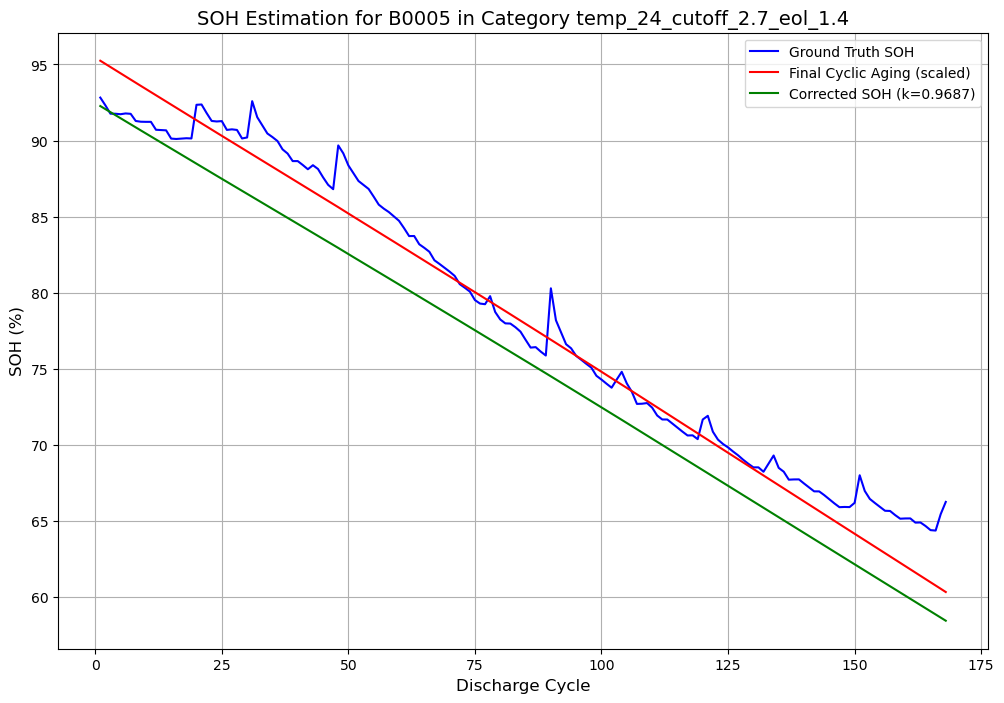


Processing category with conditions: (24, 2.5, 1.4)
Batteries: ['B0006', 'B0018', 'B0027']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0006.csv
Capacity data saved to: battery_data\capacity_soh_B0006.csv
Macro aging data saved to: battery_data\macro_aging_B0006.csv
Cycling data saved to: battery_data\NASA_cycle_dataset_B0018.csv
Capacity data saved to: battery_data\capacity_soh_B0018.csv
Macro aging data saved to: battery_data\macro_aging_B0018.csv


[I 2025-03-25 10:15:55,442] A new study created in memory with name: no-name-9a851da7-89ac-406f-9d3b-fc544917e9d4
[I 2025-03-25 10:15:55,442] Trial 0 finished with value: 228531.5183073079 and parameters: {'window_size': 298, 'global_k': 0.8080650983049426}. Best is trial 0 with value: 228531.5183073079.
[I 2025-03-25 10:15:55,442] Trial 1 finished with value: 189946.2098535397 and parameters: {'window_size': 291, 'global_k': 1.1783607105088638}. Best is trial 1 with value: 189946.2098535397.
[I 2025-03-25 10:15:55,442] Trial 2 finished with value: 108700.51223926093 and parameters: {'window_size': 118, 'global_k': 0.866064566818538}. Best is trial 2 with value: 108700.51223926093.
[I 2025-03-25 10:15:55,461] Trial 3 finished with value: 24805.39042710412 and parameters: {'window_size': 320, 'global_k': 1.0721451719905004}. Best is trial 3 with value: 24805.39042710412.
[I 2025-03-25 10:15:55,464] Trial 4 finished with value: 363019.7987410361 and parameters: {'window_size': 264, 'glob

Cycling data saved to: battery_data\NASA_cycle_dataset_B0027.csv
Capacity data saved to: battery_data\capacity_soh_B0027.csv
Macro aging data saved to: battery_data\macro_aging_B0027.csv
Category data shape: (328, 10)


[I 2025-03-25 10:15:55,616] Trial 16 finished with value: 24066.479120597403 and parameters: {'window_size': 155, 'global_k': 0.9317052427173266}. Best is trial 12 with value: 10.455372098774362.
[I 2025-03-25 10:15:55,629] Trial 17 finished with value: 789742.3487037802 and parameters: {'window_size': 21, 'global_k': 1.3575327718980719}. Best is trial 12 with value: 10.455372098774362.
[I 2025-03-25 10:15:55,662] Trial 18 finished with value: 146458.55808106737 and parameters: {'window_size': 72, 'global_k': 1.1575671347047891}. Best is trial 12 with value: 10.455372098774362.
[I 2025-03-25 10:15:55,679] Trial 19 finished with value: 14023.763256867102 and parameters: {'window_size': 158, 'global_k': 0.9442912480591822}. Best is trial 12 with value: 10.455372098774362.
[I 2025-03-25 10:15:55,696] Trial 20 finished with value: 125445.16773252879 and parameters: {'window_size': 256, 'global_k': 1.146454592872191}. Best is trial 12 with value: 10.455372098774362.
[I 2025-03-25 10:15:55,7


Optimal Parameters for Condition (24, 2.5, 1.4):
Best Window Size: 232
Global Correction Factor (k): 1.0005
Best MSE: 10.4554
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.5_eol_1.4_mhe_optuna.csv


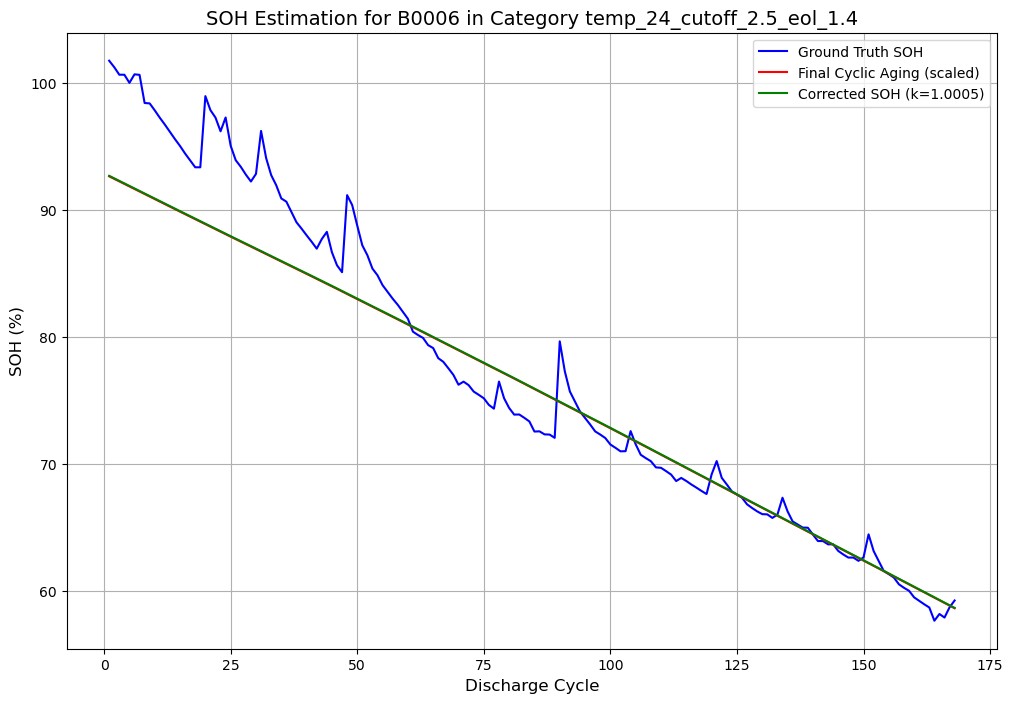


Processing category with conditions: (24, 2.2, 1.4)
Batteries: ['B0007', 'B0026']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0007.csv
Capacity data saved to: battery_data\capacity_soh_B0007.csv
Macro aging data saved to: battery_data\macro_aging_B0007.csv


[I 2025-03-25 10:16:16,599] A new study created in memory with name: no-name-7107a47f-393a-479c-9110-964e70929e44
[I 2025-03-25 10:16:16,611] Trial 0 finished with value: 20.497065768117274 and parameters: {'window_size': 142, 'global_k': 1.0140612365214063}. Best is trial 0 with value: 20.497065768117274.
[I 2025-03-25 10:16:16,614] Trial 1 finished with value: 1009563.2224852821 and parameters: {'window_size': 77, 'global_k': 1.3730310748964354}. Best is trial 0 with value: 20.497065768117274.
[I 2025-03-25 10:16:16,621] Trial 2 finished with value: 1610145.3414921004 and parameters: {'window_size': 14, 'global_k': 1.4725929199236294}. Best is trial 0 with value: 20.497065768117274.
[I 2025-03-25 10:16:16,627] Trial 3 finished with value: 18.239457236986265 and parameters: {'window_size': 44, 'global_k': 1.0022135918790125}. Best is trial 3 with value: 18.239457236986265.
[I 2025-03-25 10:16:16,630] Trial 4 finished with value: 1259856.802359234 and parameters: {'window_size': 193, '

Cycling data saved to: battery_data\NASA_cycle_dataset_B0026.csv
Capacity data saved to: battery_data\capacity_soh_B0026.csv
Macro aging data saved to: battery_data\macro_aging_B0026.csv
Category data shape: (196, 10)


[I 2025-03-25 10:16:16,777] Trial 15 finished with value: 1241247.2234911025 and parameters: {'window_size': 50, 'global_k': 0.5749473990325475}. Best is trial 3 with value: 18.239457236986265.
[I 2025-03-25 10:16:16,810] Trial 16 finished with value: 317797.8257935952 and parameters: {'window_size': 111, 'global_k': 1.2067263021248702}. Best is trial 3 with value: 18.239457236986265.
[I 2025-03-25 10:16:16,831] Trial 17 finished with value: 11860.658088985561 and parameters: {'window_size': 169, 'global_k': 0.9550574830625188}. Best is trial 3 with value: 18.239457236986265.
[I 2025-03-25 10:16:16,850] Trial 18 finished with value: 83029.73682465372 and parameters: {'window_size': 32, 'global_k': 1.1026136911437927}. Best is trial 3 with value: 18.239457236986265.
[I 2025-03-25 10:16:16,867] Trial 19 finished with value: 591660.0353707611 and parameters: {'window_size': 68, 'global_k': 0.7049756674451778}. Best is trial 3 with value: 18.239457236986265.
[I 2025-03-25 10:16:16,883] Tri


Optimal Parameters for Condition (24, 2.2, 1.4):
Best Window Size: 31
Global Correction Factor (k): 1.0016
Best MSE: 18.1793
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.2_eol_1.4_mhe_optuna.csv


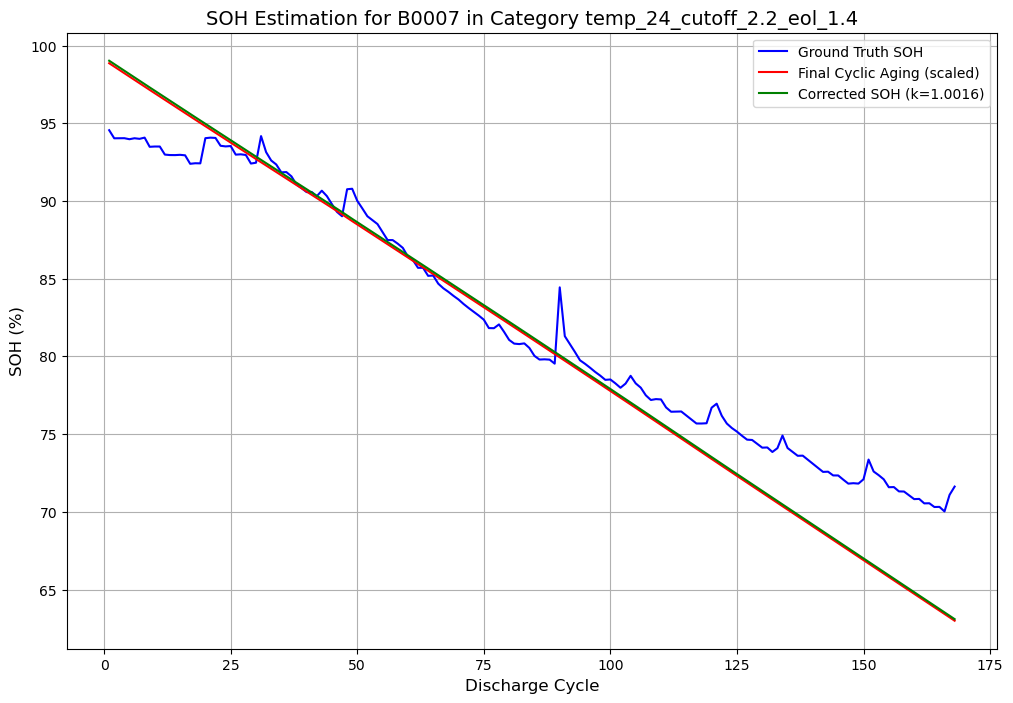


Processing category with conditions: (24, 2.0, 1.4)
Batteries: ['B0025']


[I 2025-03-25 10:16:20,984] A new study created in memory with name: no-name-85e872c7-656c-460f-90d5-440c2073aa1e
[I 2025-03-25 10:16:20,990] Trial 0 finished with value: 445109.14483872283 and parameters: {'window_size': 14, 'global_k': 0.7634881794489489}. Best is trial 0 with value: 445109.14483872283.
[I 2025-03-25 10:16:20,995] Trial 1 finished with value: 194211.5128187745 and parameters: {'window_size': 9, 'global_k': 0.8401736162489575}. Best is trial 1 with value: 194211.5128187745.
[I 2025-03-25 10:16:20,999] Trial 2 finished with value: 653226.105563004 and parameters: {'window_size': 25, 'global_k': 1.284607136813769}. Best is trial 1 with value: 194211.5128187745.
[I 2025-03-25 10:16:21,000] Trial 3 finished with value: 170430.85903373637 and parameters: {'window_size': 16, 'global_k': 1.150290629223354}. Best is trial 3 with value: 170430.85903373637.
[I 2025-03-25 10:16:21,000] Trial 4 finished with value: 22.629989110465107 and parameters: {'window_size': 9, 'global_k':

Cycling data saved to: battery_data\NASA_cycle_dataset_B0025.csv
Capacity data saved to: battery_data\capacity_soh_B0025.csv
Macro aging data saved to: battery_data\macro_aging_B0025.csv
Category data shape: (28, 10)


[I 2025-03-25 10:16:21,150] Trial 15 finished with value: 109558.56479634818 and parameters: {'window_size': 7, 'global_k': 1.1233887377694844}. Best is trial 12 with value: 15.845531561935072.
[I 2025-03-25 10:16:21,177] Trial 16 finished with value: 35539.464640429134 and parameters: {'window_size': 23, 'global_k': 0.9205321892277787}. Best is trial 12 with value: 15.845531561935072.
[I 2025-03-25 10:16:21,192] Trial 17 finished with value: 12336.91459632094 and parameters: {'window_size': 16, 'global_k': 0.9775077563215023}. Best is trial 12 with value: 15.845531561935072.
[I 2025-03-25 10:16:21,197] Trial 18 finished with value: 512162.55105384934 and parameters: {'window_size': 13, 'global_k': 1.2528475668896202}. Best is trial 12 with value: 15.845531561935072.
[I 2025-03-25 10:16:21,225] Trial 19 finished with value: 645503.0613787217 and parameters: {'window_size': 7, 'global_k': 0.7167870203744923}. Best is trial 12 with value: 15.845531561935072.
[I 2025-03-25 10:16:21,230] T


Optimal Parameters for Condition (24, 2.0, 1.4):
Best Window Size: 23
Global Correction Factor (k): 1.0349
Best MSE: 10.6743
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.0_eol_1.4_mhe_optuna.csv


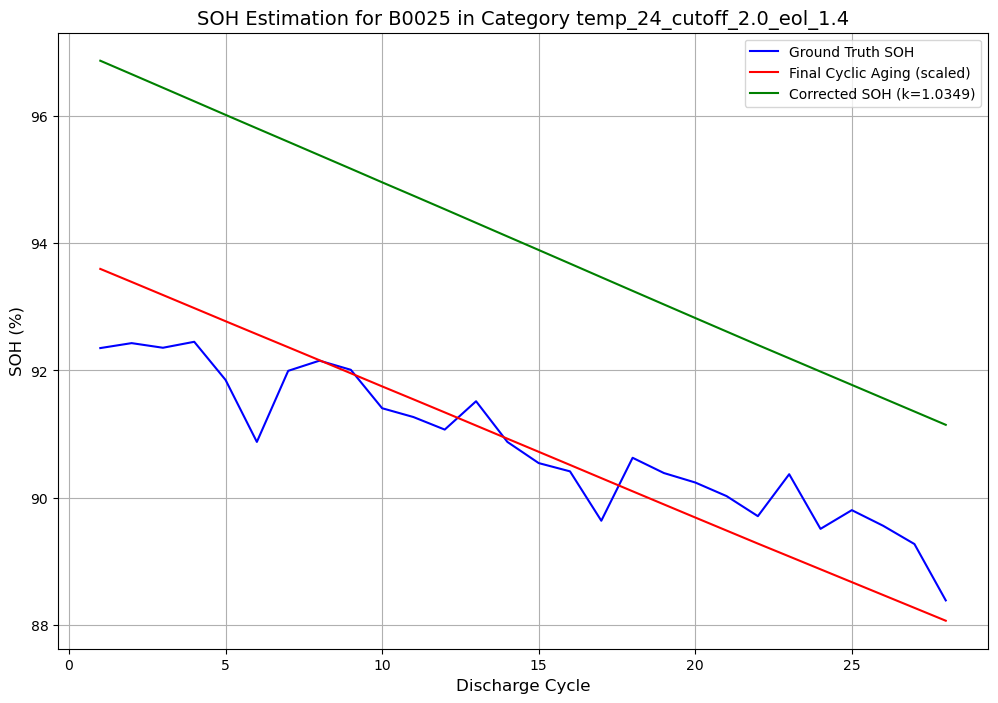


Processing category with conditions: (43, 2.0, 1.4)
Batteries: ['B0029']


[I 2025-03-25 10:16:25,014] A new study created in memory with name: no-name-0b93ec59-47c3-430d-baaf-2917a50b955a
[I 2025-03-25 10:16:25,014] Trial 0 finished with value: 193647.12244659767 and parameters: {'window_size': 18, 'global_k': 1.1671351604890075}. Best is trial 0 with value: 193647.12244659767.
[I 2025-03-25 10:16:25,028] Trial 1 finished with value: 18.50902963424948 and parameters: {'window_size': 9, 'global_k': 1.0474702719226037}. Best is trial 1 with value: 18.50902963424948.
[I 2025-03-25 10:16:25,030] Trial 2 finished with value: 108356.0044492005 and parameters: {'window_size': 16, 'global_k': 1.128558414747693}. Best is trial 1 with value: 18.50902963424948.
[I 2025-03-25 10:16:25,030] Trial 3 finished with value: 1668637.04540267 and parameters: {'window_size': 35, 'global_k': 0.5248801410169389}. Best is trial 1 with value: 18.50902963424948.
[I 2025-03-25 10:16:25,045] Trial 4 finished with value: 130592.03193814041 and parameters: {'window_size': 15, 'global_k':

Cycling data saved to: battery_data\NASA_cycle_dataset_B0029.csv
Capacity data saved to: battery_data\capacity_soh_B0029.csv
Macro aging data saved to: battery_data\macro_aging_B0029.csv
Category data shape: (40, 10)


[I 2025-03-25 10:16:25,181] Trial 15 finished with value: 18038.957924889113 and parameters: {'window_size': 6, 'global_k': 1.066759376448156}. Best is trial 1 with value: 18.50902963424948.
[I 2025-03-25 10:16:25,196] Trial 16 finished with value: 469466.5124537564 and parameters: {'window_size': 13, 'global_k': 1.2546326137465769}. Best is trial 1 with value: 18.50902963424948.
[I 2025-03-25 10:16:25,213] Trial 17 finished with value: 15384.37343654412 and parameters: {'window_size': 8, 'global_k': 0.9968844461360411}. Best is trial 1 with value: 18.50902963424948.
[I 2025-03-25 10:16:25,234] Trial 18 finished with value: 555823.4363411549 and parameters: {'window_size': 40, 'global_k': 0.7231935176423654}. Best is trial 1 with value: 18.50902963424948.
[I 2025-03-25 10:16:25,247] Trial 19 finished with value: 84177.38641960667 and parameters: {'window_size': 3, 'global_k': 0.884286725497313}. Best is trial 1 with value: 18.50902963424948.
[I 2025-03-25 10:16:25,266] Trial 20 finishe


Optimal Parameters for Condition (43, 2.0, 1.4):
Best Window Size: 19
Global Correction Factor (k): 0.9681
Best MSE: 9.0705
Category corrected SOH data saved to: battery_data\category_temp_43_cutoff_2.0_eol_1.4_mhe_optuna.csv


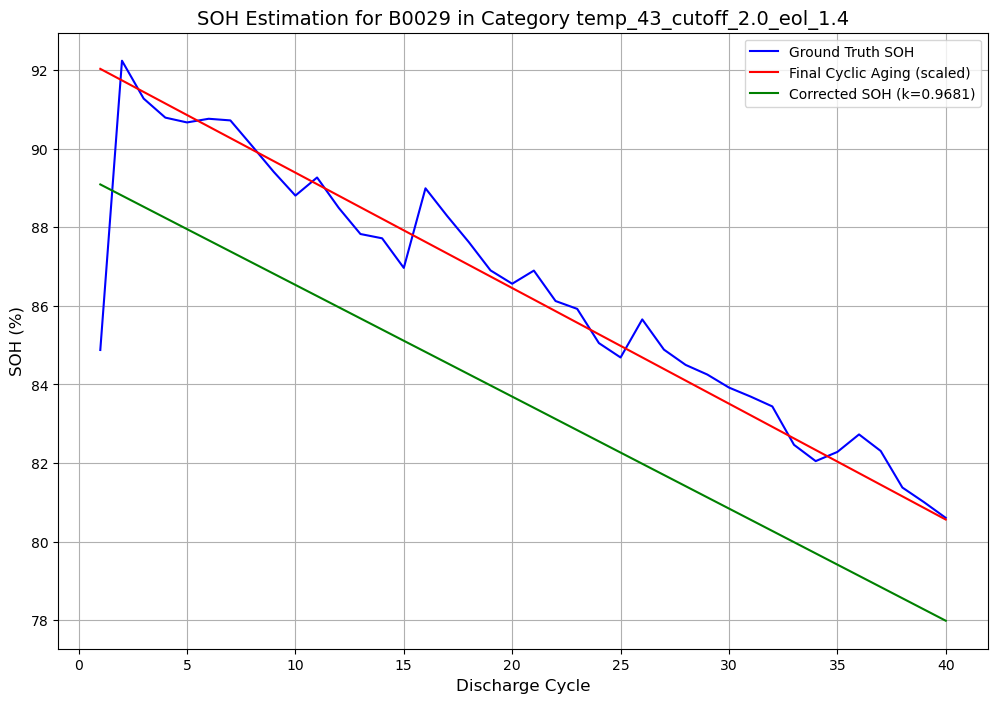


Processing category with conditions: (43, 2.2, 1.4)
Batteries: ['B0030']


[I 2025-03-25 10:16:29,733] A new study created in memory with name: no-name-512c134e-aa38-44c5-9a31-58734f5b7b11
[I 2025-03-25 10:16:29,733] Trial 0 finished with value: 9434.18310090412 and parameters: {'window_size': 19, 'global_k': 0.9698108365174172}. Best is trial 0 with value: 9434.18310090412.
[I 2025-03-25 10:16:29,745] Trial 1 finished with value: 219809.09664888206 and parameters: {'window_size': 25, 'global_k': 1.1842372556097376}. Best is trial 0 with value: 9434.18310090412.
[I 2025-03-25 10:16:29,750] Trial 2 finished with value: 1711374.119004727 and parameters: {'window_size': 21, 'global_k': 1.499448075181244}. Best is trial 0 with value: 9434.18310090412.
[I 2025-03-25 10:16:29,755] Trial 3 finished with value: 1688758.0035250003 and parameters: {'window_size': 30, 'global_k': 0.5033077775894959}. Best is trial 0 with value: 9434.18310090412.
[I 2025-03-25 10:16:29,762] Trial 4 finished with value: 13645.081973407474 and parameters: {'window_size': 5, 'global_k': 0.9

Cycling data saved to: battery_data\NASA_cycle_dataset_B0030.csv
Capacity data saved to: battery_data\capacity_soh_B0030.csv
Macro aging data saved to: battery_data\macro_aging_B0030.csv
Category data shape: (40, 10)


[I 2025-03-25 10:16:29,881] Trial 14 finished with value: 20.02829242378769 and parameters: {'window_size': 17, 'global_k': 0.9477918397562359}. Best is trial 14 with value: 20.02829242378769.
[I 2025-03-25 10:16:29,905] Trial 15 finished with value: 14594.979611837754 and parameters: {'window_size': 17, 'global_k': 1.0658260390936767}. Best is trial 14 with value: 20.02829242378769.
[I 2025-03-25 10:16:29,910] Trial 16 finished with value: 53355.47496666787 and parameters: {'window_size': 14, 'global_k': 0.8998748404700461}. Best is trial 14 with value: 20.02829242378769.
[I 2025-03-25 10:16:29,945] Trial 17 finished with value: 1129917.501139255 and parameters: {'window_size': 4, 'global_k': 0.5927517546789911}. Best is trial 14 with value: 20.02829242378769.
[I 2025-03-25 10:16:29,964] Trial 18 finished with value: 987135.2765204541 and parameters: {'window_size': 21, 'global_k': 1.3805135695019666}. Best is trial 14 with value: 20.02829242378769.
[I 2025-03-25 10:16:29,981] Trial 1


Optimal Parameters for Condition (43, 2.2, 1.4):
Best Window Size: 26
Global Correction Factor (k): 0.9653
Best MSE: 9.5791
Category corrected SOH data saved to: battery_data\category_temp_43_cutoff_2.2_eol_1.4_mhe_optuna.csv


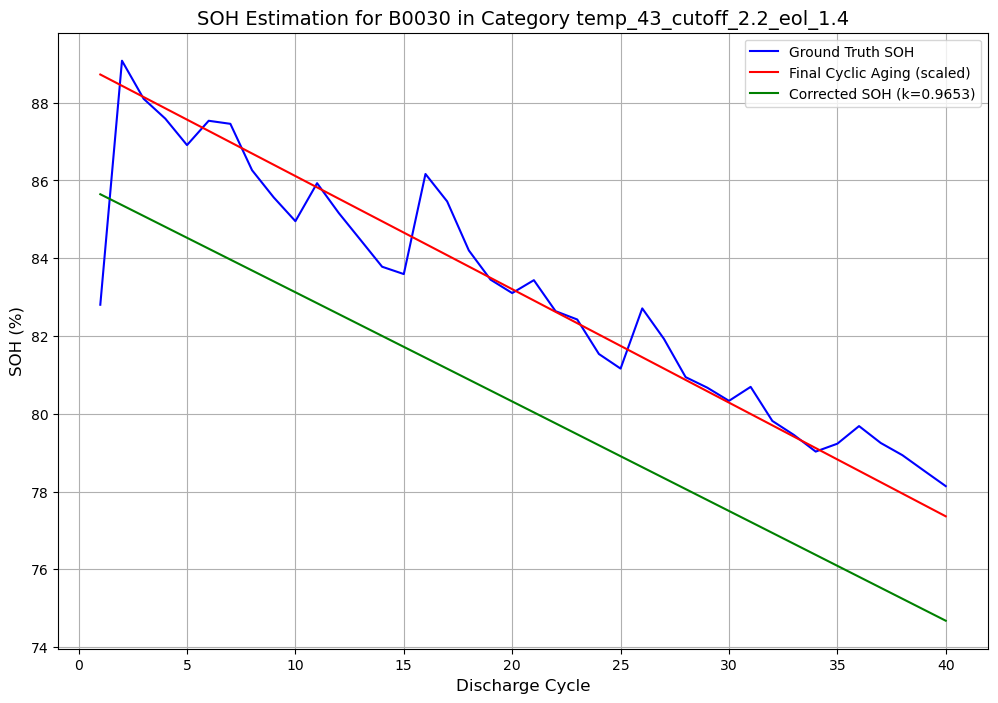


Processing category with conditions: (43, 2.5, 1.4)
Batteries: ['B0031']


[I 2025-03-25 10:16:33,952] A new study created in memory with name: no-name-1180ec79-a1e6-4b21-93b8-54ec2cfdfde8
[I 2025-03-25 10:16:33,952] Trial 0 finished with value: 604841.4548323575 and parameters: {'window_size': 38, 'global_k': 1.2839701222273414}. Best is trial 0 with value: 604841.4548323575.
[I 2025-03-25 10:16:33,963] Trial 1 finished with value: 1735603.4387755888 and parameters: {'window_size': 27, 'global_k': 0.5201440967322514}. Best is trial 0 with value: 604841.4548323575.
[I 2025-03-25 10:16:33,963] Trial 2 finished with value: 11217.869258616049 and parameters: {'window_size': 13, 'global_k': 1.0552089751487979}. Best is trial 2 with value: 11217.869258616049.
[I 2025-03-25 10:16:33,963] Trial 3 finished with value: 73070.34596102506 and parameters: {'window_size': 40, 'global_k': 1.1053216954262595}. Best is trial 2 with value: 11217.869258616049.
[I 2025-03-25 10:16:33,979] Trial 4 finished with value: 40489.244817292376 and parameters: {'window_size': 36, 'globa

Cycling data saved to: battery_data\NASA_cycle_dataset_B0031.csv
Capacity data saved to: battery_data\capacity_soh_B0031.csv
Macro aging data saved to: battery_data\macro_aging_B0031.csv
Category data shape: (40, 10)


[I 2025-03-25 10:16:34,129] Trial 16 finished with value: 1472874.4490306575 and parameters: {'window_size': 25, 'global_k': 0.5576085616528916}. Best is trial 13 with value: 9001.467064785842.
[I 2025-03-25 10:16:34,147] Trial 17 finished with value: 11888.817182768122 and parameters: {'window_size': 11, 'global_k': 1.0092464933356375}. Best is trial 13 with value: 9001.467064785842.
[I 2025-03-25 10:16:34,163] Trial 18 finished with value: 521701.6439072967 and parameters: {'window_size': 3, 'global_k': 1.264108931144078}. Best is trial 13 with value: 9001.467064785842.
[I 2025-03-25 10:16:34,178] Trial 19 finished with value: 1188112.1830884675 and parameters: {'window_size': 18, 'global_k': 1.3962925534891721}. Best is trial 13 with value: 9001.467064785842.
[I 2025-03-25 10:16:34,195] Trial 20 finished with value: 118603.99468328654 and parameters: {'window_size': 23, 'global_k': 1.1305091153168678}. Best is trial 13 with value: 9001.467064785842.
[I 2025-03-25 10:16:34,213] Trial


Optimal Parameters for Condition (43, 2.5, 1.4):
Best Window Size: 4
Global Correction Factor (k): 0.9663
Best MSE: 12.6235
Category corrected SOH data saved to: battery_data\category_temp_43_cutoff_2.5_eol_1.4_mhe_optuna.csv


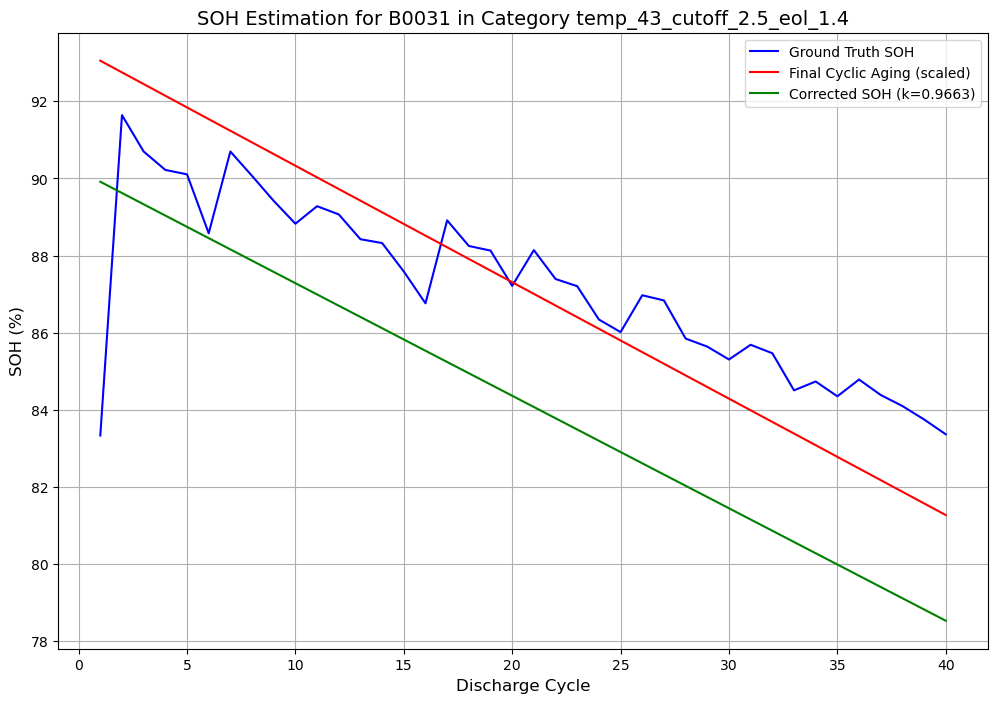


Processing category with conditions: (43, 2.7, 1.4)
Batteries: ['B0032']


[I 2025-03-25 10:16:38,183] A new study created in memory with name: no-name-933eb1ae-616b-4f11-8db3-8584303410e0
[I 2025-03-25 10:16:38,183] Trial 0 finished with value: 1368776.5897821838 and parameters: {'window_size': 15, 'global_k': 0.5763428389896647}. Best is trial 0 with value: 1368776.5897821838.
[I 2025-03-25 10:16:38,196] Trial 1 finished with value: 23980.20109178753 and parameters: {'window_size': 27, 'global_k': 0.9288918771095658}. Best is trial 1 with value: 23980.20109178753.
[I 2025-03-25 10:16:38,200] Trial 2 finished with value: 36186.69084866067 and parameters: {'window_size': 33, 'global_k': 1.081068385066132}. Best is trial 1 with value: 23980.20109178753.
[I 2025-03-25 10:16:38,200] Trial 3 finished with value: 123962.96157317961 and parameters: {'window_size': 19, 'global_k': 1.1338816127623477}. Best is trial 1 with value: 23980.20109178753.
[I 2025-03-25 10:16:38,213] Trial 4 finished with value: 659915.694015785 and parameters: {'window_size': 37, 'global_k'

Cycling data saved to: battery_data\NASA_cycle_dataset_B0032.csv
Capacity data saved to: battery_data\capacity_soh_B0032.csv
Macro aging data saved to: battery_data\macro_aging_B0032.csv
Category data shape: (40, 10)


[I 2025-03-25 10:16:38,350] Trial 15 finished with value: 477601.20365710475 and parameters: {'window_size': 19, 'global_k': 1.2523919464844768}. Best is trial 9 with value: 17.98147548080876.
[I 2025-03-25 10:16:38,372] Trial 16 finished with value: 14084.58003623756 and parameters: {'window_size': 12, 'global_k': 0.9901213835394801}. Best is trial 9 with value: 17.98147548080876.
[I 2025-03-25 10:16:38,384] Trial 17 finished with value: 477686.10389094776 and parameters: {'window_size': 22, 'global_k': 1.2524137231455859}. Best is trial 9 with value: 17.98147548080876.
[I 2025-03-25 10:16:38,401] Trial 18 finished with value: 693131.6083390334 and parameters: {'window_size': 18, 'global_k': 0.6968921933141244}. Best is trial 9 with value: 17.98147548080876.
[I 2025-03-25 10:16:38,416] Trial 19 finished with value: 98313.7408450493 and parameters: {'window_size': 33, 'global_k': 0.8787100062801071}. Best is trial 9 with value: 17.98147548080876.
[I 2025-03-25 10:16:38,443] Trial 20 fi


Optimal Parameters for Condition (43, 2.7, 1.4):
Best Window Size: 24
Global Correction Factor (k): 0.9681
Best MSE: 9.9492
Category corrected SOH data saved to: battery_data\category_temp_43_cutoff_2.7_eol_1.4_mhe_optuna.csv


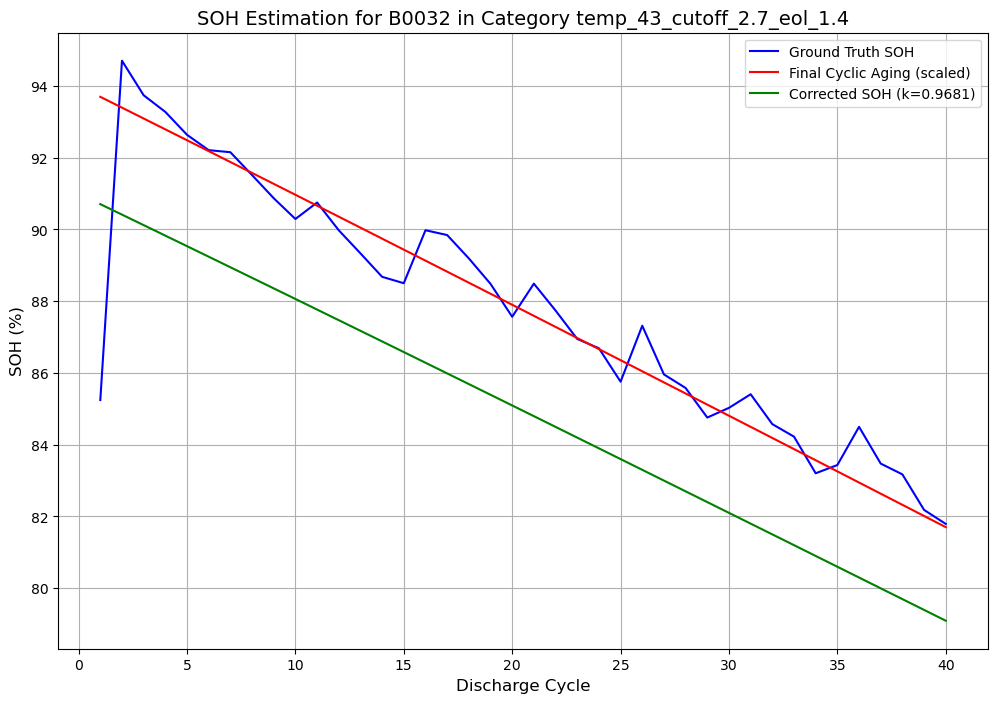


Processing category with conditions: (24, 2.0, 1.6)
Batteries: ['B0033']


[I 2025-03-25 10:16:50,601] A new study created in memory with name: no-name-a53a39af-348c-44a9-a182-e61dccdd6e0e
[I 2025-03-25 10:16:50,601] Trial 0 finished with value: 418378.99636839784 and parameters: {'window_size': 24, 'global_k': 0.7821180035616299}. Best is trial 0 with value: 418378.99636839784.
[I 2025-03-25 10:16:50,612] Trial 1 finished with value: 995905.7082227501 and parameters: {'window_size': 59, 'global_k': 1.370040335361695}. Best is trial 0 with value: 418378.99636839784.
[I 2025-03-25 10:16:50,612] Trial 2 finished with value: 1132696.3192075677 and parameters: {'window_size': 154, 'global_k': 0.5581250431197223}. Best is trial 0 with value: 418378.99636839784.
[I 2025-03-25 10:16:50,628] Trial 3 finished with value: 1523452.777513111 and parameters: {'window_size': 107, 'global_k': 1.484900137062161}. Best is trial 0 with value: 418378.99636839784.
[I 2025-03-25 10:16:50,634] Trial 4 finished with value: 1342677.7684013247 and parameters: {'window_size': 19, 'glo

Cycling data saved to: battery_data\NASA_cycle_dataset_B0033.csv
Capacity data saved to: battery_data\capacity_soh_B0033.csv
Macro aging data saved to: battery_data\macro_aging_B0033.csv
Category data shape: (197, 10)


[I 2025-03-25 10:16:50,712] Trial 11 finished with value: 319260.27870953735 and parameters: {'window_size': 189, 'global_k': 1.1220932294920907}. Best is trial 6 with value: 268945.0185222794.
[I 2025-03-25 10:16:50,732] Trial 12 finished with value: 218039.21683724728 and parameters: {'window_size': 89, 'global_k': 0.9992596644389656}. Best is trial 12 with value: 218039.21683724728.
[I 2025-03-25 10:16:50,750] Trial 13 finished with value: 228616.18345133387 and parameters: {'window_size': 66, 'global_k': 0.9313729419943274}. Best is trial 12 with value: 218039.21683724728.
[I 2025-03-25 10:16:50,768] Trial 14 finished with value: 246502.76437756734 and parameters: {'window_size': 72, 'global_k': 0.9037139883821314}. Best is trial 12 with value: 218039.21683724728.
[I 2025-03-25 10:16:50,783] Trial 15 finished with value: 930579.2546318285 and parameters: {'window_size': 132, 'global_k': 0.6075949761814727}. Best is trial 12 with value: 218039.21683724728.
[I 2025-03-25 10:16:50,805


Optimal Parameters for Condition (24, 2.0, 1.6):
Best Window Size: 126
Global Correction Factor (k): 0.9791
Best MSE: 216236.6935
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.0_eol_1.6_mhe_optuna.csv


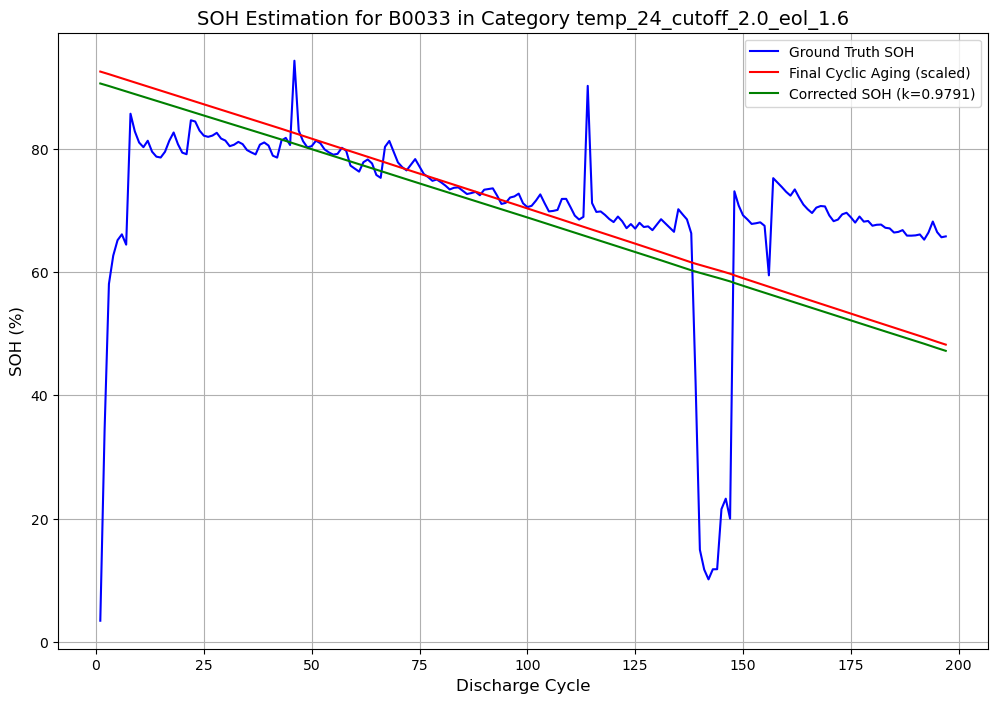


Processing category with conditions: (24, 2.2, 1.6)
Batteries: ['B0034', 'B0038']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0034.csv
Capacity data saved to: battery_data\capacity_soh_B0034.csv
Macro aging data saved to: battery_data\macro_aging_B0034.csv


[I 2025-03-25 10:17:07,652] A new study created in memory with name: no-name-7e36aa37-d2fe-4fc9-b546-1c3e03a50147
[I 2025-03-25 10:17:07,668] Trial 0 finished with value: 609936.838280502 and parameters: {'window_size': 151, 'global_k': 0.6774346745275482}. Best is trial 0 with value: 609936.838280502.
[I 2025-03-25 10:17:07,668] Trial 1 finished with value: 242662.4880429828 and parameters: {'window_size': 178, 'global_k': 0.8386616716181482}. Best is trial 1 with value: 242662.4880429828.
[I 2025-03-25 10:17:07,678] Trial 2 finished with value: 252369.32963401504 and parameters: {'window_size': 65, 'global_k': 0.8320505468615981}. Best is trial 1 with value: 242662.4880429828.
[I 2025-03-25 10:17:07,678] Trial 3 finished with value: 347492.0153587609 and parameters: {'window_size': 241, 'global_k': 0.7786821005992712}. Best is trial 1 with value: 242662.4880429828.
[I 2025-03-25 10:17:07,678] Trial 4 finished with value: 381901.50551263004 and parameters: {'window_size': 163, 'global

Cycling data saved to: battery_data\NASA_cycle_dataset_B0038.csv
Capacity data saved to: battery_data\capacity_soh_B0038.csv
Macro aging data saved to: battery_data\macro_aging_B0038.csv
Category data shape: (244, 10)


[I 2025-03-25 10:17:07,828] Trial 16 finished with value: 155959.67406444272 and parameters: {'window_size': 93, 'global_k': 0.9288576137456791}. Best is trial 15 with value: 144675.09684340085.
[I 2025-03-25 10:17:07,844] Trial 17 finished with value: 770738.8482023726 and parameters: {'window_size': 141, 'global_k': 1.3213216317280723}. Best is trial 15 with value: 144675.09684340085.
[I 2025-03-25 10:17:07,878] Trial 18 finished with value: 147120.44636162027 and parameters: {'window_size': 164, 'global_k': 0.9533771918645334}. Best is trial 15 with value: 144675.09684340085.
[I 2025-03-25 10:17:07,895] Trial 19 finished with value: 251621.22501522038 and parameters: {'window_size': 100, 'global_k': 1.1185209767706978}. Best is trial 15 with value: 144675.09684340085.
[I 2025-03-25 10:17:07,910] Trial 20 finished with value: 1506508.063743806 and parameters: {'window_size': 56, 'global_k': 1.4854962944837276}. Best is trial 15 with value: 144675.09684340085.
[I 2025-03-25 10:17:07,9


Optimal Parameters for Condition (24, 2.2, 1.6):
Best Window Size: 154
Global Correction Factor (k): 0.9706
Best MSE: 144675.0968
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.2_eol_1.6_mhe_optuna.csv


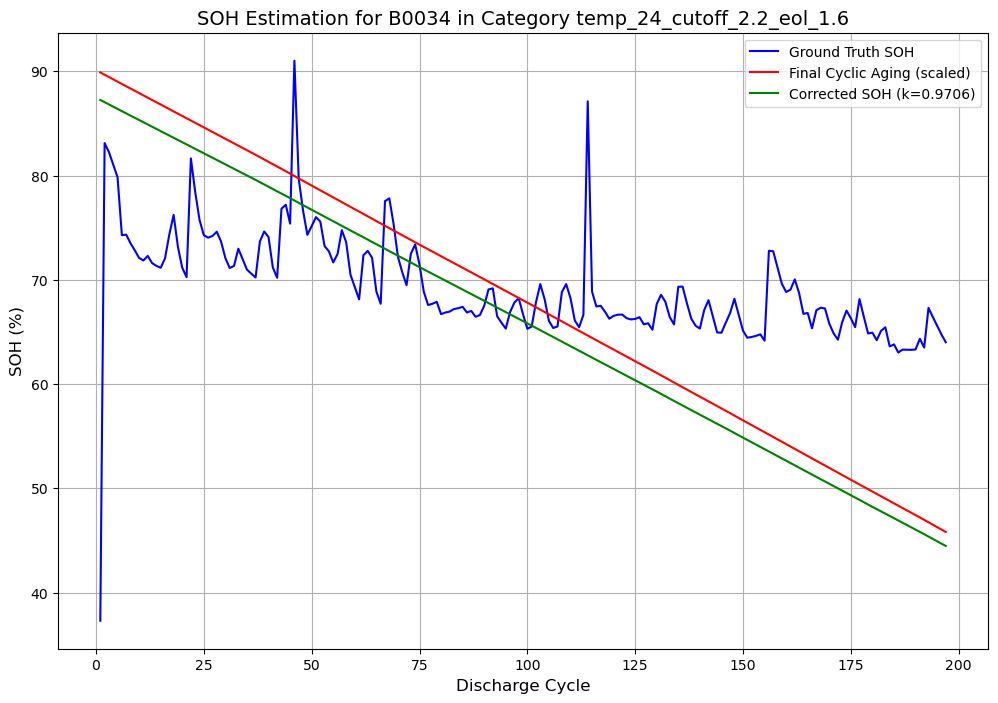


Processing category with conditions: (24, 2.7, 1.6)
Batteries: ['B0036', 'B0040']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0036.csv
Capacity data saved to: battery_data\capacity_soh_B0036.csv
Macro aging data saved to: battery_data\macro_aging_B0036.csv


[I 2025-03-25 10:17:23,923] A new study created in memory with name: no-name-b15319b3-09d7-45c1-b69a-b5a44d677d75
[I 2025-03-25 10:17:23,931] Trial 0 finished with value: 735921.7912840592 and parameters: {'window_size': 16, 'global_k': 1.2240175815501702}. Best is trial 0 with value: 735921.7912840592.
[I 2025-03-25 10:17:23,935] Trial 1 finished with value: 1429228.2234825187 and parameters: {'window_size': 94, 'global_k': 1.3780338052847263}. Best is trial 0 with value: 735921.7912840592.
[I 2025-03-25 10:17:23,940] Trial 2 finished with value: 807788.9368074151 and parameters: {'window_size': 25, 'global_k': 1.244126039857807}. Best is trial 0 with value: 735921.7912840592.
[I 2025-03-25 10:17:23,944] Trial 3 finished with value: 443137.83886486595 and parameters: {'window_size': 146, 'global_k': 1.1146539915375657}. Best is trial 3 with value: 443137.83886486595.
[I 2025-03-25 10:17:23,949] Trial 4 finished with value: 950978.1406898416 and parameters: {'window_size': 177, 'global

Cycling data saved to: battery_data\NASA_cycle_dataset_B0040.csv
Capacity data saved to: battery_data\capacity_soh_B0040.csv
Macro aging data saved to: battery_data\macro_aging_B0040.csv
Category data shape: (244, 10)


[I 2025-03-25 10:17:24,062] Trial 16 finished with value: 2057509.7309471627 and parameters: {'window_size': 215, 'global_k': 1.478347265897334}. Best is trial 10 with value: 310320.6243052548.
[I 2025-03-25 10:17:24,077] Trial 17 finished with value: 1390345.9435432672 and parameters: {'window_size': 173, 'global_k': 0.5811837724164154}. Best is trial 10 with value: 310320.6243052548.
[I 2025-03-25 10:17:24,095] Trial 18 finished with value: 452138.07230668125 and parameters: {'window_size': 57, 'global_k': 0.8329073383482535}. Best is trial 10 with value: 310320.6243052548.
[I 2025-03-25 10:17:24,111] Trial 19 finished with value: 323669.99202380504 and parameters: {'window_size': 220, 'global_k': 1.0202850660980098}. Best is trial 10 with value: 310320.6243052548.
[I 2025-03-25 10:17:24,128] Trial 20 finished with value: 800129.8098778926 and parameters: {'window_size': 154, 'global_k': 0.7101177062511064}. Best is trial 10 with value: 310320.6243052548.
[I 2025-03-25 10:17:24,144] 


Optimal Parameters for Condition (24, 2.7, 1.6):
Best Window Size: 225
Global Correction Factor (k): 0.9765
Best MSE: 310139.6388
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.7_eol_1.6_mhe_optuna.csv


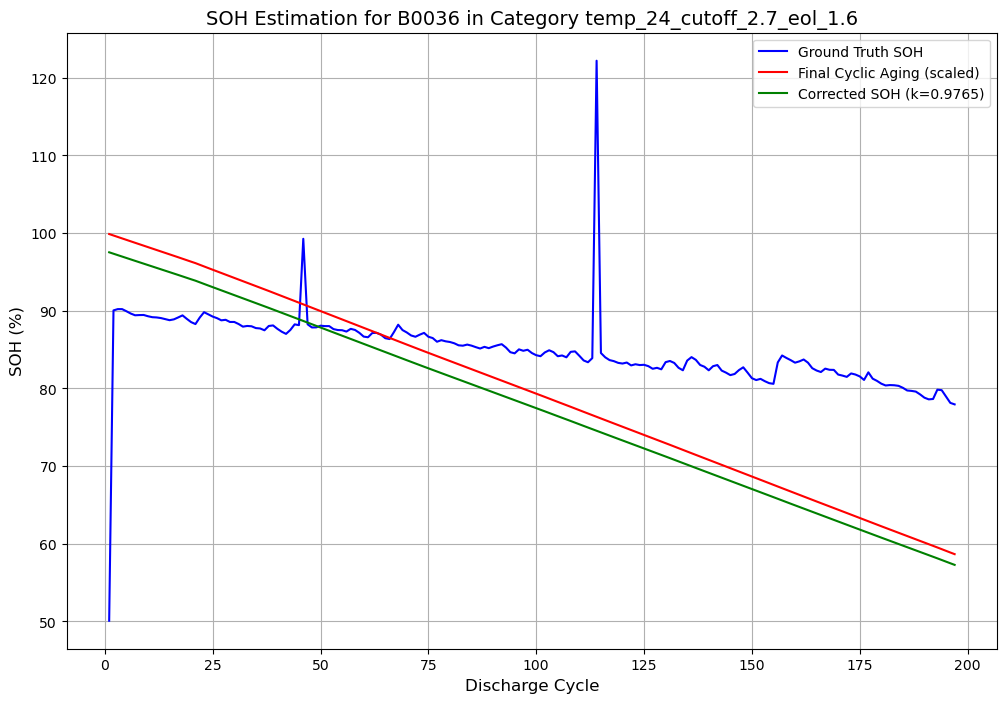


Processing category with conditions: (24, 2.5, 1.6)
Batteries: ['B0039']


[I 2025-03-25 10:17:28,728] A new study created in memory with name: no-name-a63e3040-9ac8-40e9-9873-5b4ab9545b43
[I 2025-03-25 10:17:28,728] Trial 0 finished with value: 1662361.0185842137 and parameters: {'window_size': 47, 'global_k': 1.376205067114601}. Best is trial 0 with value: 1662361.0185842137.
[I 2025-03-25 10:17:28,728] Trial 1 finished with value: 2027233.558152763 and parameters: {'window_size': 30, 'global_k': 0.5098331117308601}. Best is trial 0 with value: 1662361.0185842137.
[I 2025-03-25 10:17:28,728] Trial 2 finished with value: 970599.8062420911 and parameters: {'window_size': 41, 'global_k': 1.0658240200945994}. Best is trial 2 with value: 970599.8062420911.
[I 2025-03-25 10:17:28,745] Trial 3 finished with value: 950020.5432105545 and parameters: {'window_size': 22, 'global_k': 1.0303717764069953}. Best is trial 3 with value: 950020.5432105545.
[I 2025-03-25 10:17:28,745] Trial 4 finished with value: 1004366.3538678011 and parameters: {'window_size': 44, 'global_

Cycling data saved to: battery_data\NASA_cycle_dataset_B0039.csv
Capacity data saved to: battery_data\capacity_soh_B0039.csv
Macro aging data saved to: battery_data\macro_aging_B0039.csv
Category data shape: (47, 10)


[I 2025-03-25 10:17:28,895] Trial 17 finished with value: 941660.1695266514 and parameters: {'window_size': 27, 'global_k': 0.9767335519961546}. Best is trial 17 with value: 941660.1695266514.
[I 2025-03-25 10:17:28,911] Trial 18 finished with value: 2104665.3835501024 and parameters: {'window_size': 35, 'global_k': 1.4812927838561036}. Best is trial 17 with value: 941660.1695266514.
[I 2025-03-25 10:17:28,928] Trial 19 finished with value: 1285414.7609818305 and parameters: {'window_size': 30, 'global_k': 0.7184358222496015}. Best is trial 17 with value: 941660.1695266514.
[I 2025-03-25 10:17:28,945] Trial 20 finished with value: 958852.4652484254 and parameters: {'window_size': 25, 'global_k': 0.9262356240900935}. Best is trial 17 with value: 941660.1695266514.
[I 2025-03-25 10:17:28,961] Trial 21 finished with value: 953712.8552913333 and parameters: {'window_size': 12, 'global_k': 1.0385665840948952}. Best is trial 17 with value: 941660.1695266514.
[I 2025-03-25 10:17:28,978] Trial


Optimal Parameters for Condition (24, 2.5, 1.6):
Best Window Size: 39
Global Correction Factor (k): 0.9879
Best MSE: 941140.1039
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.5_eol_1.6_mhe_optuna.csv


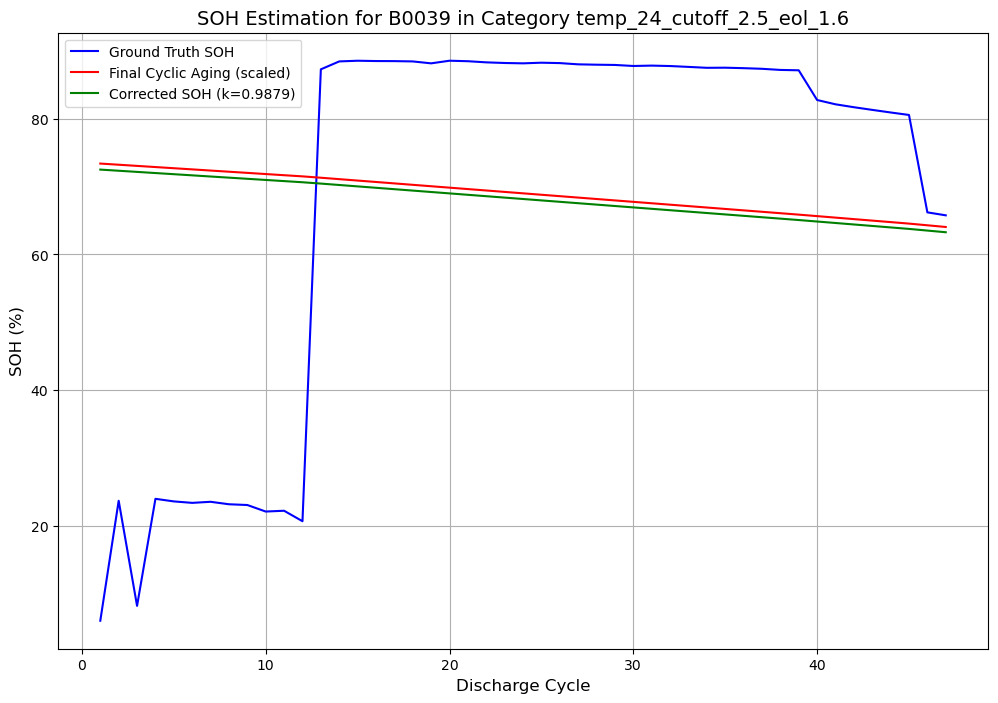


Processing category with conditions: (4, 2.0, 1.4)
Batteries: ['B0041', 'B0045', 'B0049', 'B0053']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0041.csv
Capacity data saved to: battery_data\capacity_soh_B0041.csv
Macro aging data saved to: battery_data\macro_aging_B0041.csv
Cycling data saved to: battery_data\NASA_cycle_dataset_B0045.csv
Capacity data saved to: battery_data\capacity_soh_B0045.csv
Macro aging data saved to: battery_data\macro_aging_B0045.csv


FileNotFoundError: [Errno 2] No such file or directory: 'battery_data\\B0049.mat'

In [22]:
with open("battery_params.json", 'r') as json_file:
    battery_params = json.load(json_file)
dataset_folder = 'battery_data'
results = process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials=50)

In [23]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import optuna
import os
from collections import defaultdict

# Objective function for Optuna to optimize window size per category
def mhe_category_objective(trial, category_df):
    num_cycles = len(category_df)
    window_size = trial.suggest_int('window_size', 3, num_cycles)
    
    # Scale Final_cyclic_aging for the category
    scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
    category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
    
    # Apply local correction with suggested window size
    segment_starts = list(range(0, num_cycles, window_size))
    corrected_soh = []
    
    for start in segment_starts:
        end = min(start + window_size, num_cycles)
        segment_df = category_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        ground_truth_segment = segment_df['ground_truth_soh'].values
        
        # Optimize k for this segment
        def segment_cost(k):
            return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
        
        result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
        k_opt = result.x[0]
        corrected_soh.extend(k_opt * predicted_soh_segment)
    
    # Calculate MSE for the category
    mse = np.mean((np.array(corrected_soh) - category_df['ground_truth_soh'])**2)
    
    # Enforce MSE between 9 and 25 %² (RMSE 3% to 5%)
    if mse < 9 or mse > 25:
        penalty = abs(mse - 17)  # Center of target range
        return mse + penalty * 1000
    
    return mse

# Process all batteries by test condition categories with segment-specific correction factors
def process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials=50):
    # Load battery parameters
    with open("battery_params.json", 'r') as json_file:
        params = json.load(json_file)
    
    # Categorize batteries by test conditions
    categories = defaultdict(list)
    for battery_name, param in params.items():
        key = (param['ambient_temp_celsius'], param['cutoff_voltage'], param['eol_capacity'])
        categories[key].append(battery_name)
    
    # Process each category
    all_results = {}
    
    for test_condition, battery_names in categories.items():
        print(f"\nProcessing category with conditions: {test_condition}")
        print(f"Batteries: {battery_names}")
        
        category_dfs = []
        for battery_name in battery_names:
            macro_df = process_battery(dataset_folder, battery_name, params)
            category_dfs.append(macro_df)
        
        # Combine data for this category
        category_df = pd.concat(category_dfs, ignore_index=True)
        print(f"Category data shape: {category_df.shape}")
        
        # Optimize window size for this category
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: mhe_category_objective(trial, category_df.copy()), n_trials=n_trials)
        
        best_window_size = study.best_params['window_size']
        best_mse = study.best_value
        
        print(f"\nOptimal Window Size for Condition {test_condition}: {best_window_size}")
        print(f"Best MSE: {best_mse:.4f}")
        
        # Apply correction with optimized window size and segment-specific k
        scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
        category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
        num_cycles = len(category_df)
        segment_starts = list(range(0, num_cycles, best_window_size))
        corrected_soh = []
        local_correction_factors = []
        
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = category_df.iloc[start:end]
            predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
            ground_truth_segment = segment_df['ground_truth_soh'].values
            
            # Optimize k for this specific segment
            def segment_cost(k):
                return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
            
            result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
            k_opt = result.x[0]
            local_correction_factors.extend([k_opt] * len(segment_df))
            corrected_soh.extend(k_opt * predicted_soh_segment)
        
        category_df['Local_Corrected_SOH'] = corrected_soh
        category_df['Segment_Correction_Factor'] = local_correction_factors
        
        # Save results for this category
        condition_str = f"temp_{test_condition[0]}_cutoff_{test_condition[1]}_eol_{test_condition[2]}"
        output_file = os.path.join(dataset_folder, f"category_{condition_str}_mhe_optuna.csv")
        category_df.to_csv(output_file, index=False)
        print(f"Category corrected SOH data saved to: {output_file}")
        
        # Store results
        all_results[condition_str] = {
            'window_size': best_window_size,
            'mse': best_mse,
            'df': category_df
        }
        
        # Print segment-specific correction factors
        print(f"\nSegment-Specific Correction Factors for Condition {test_condition} (Window Size: {best_window_size}):")
        for i, start in enumerate(segment_starts):
            end = min(start + best_window_size, num_cycles)
            k_value = local_correction_factors[start]
            print(f"Segment {i+1} (Rows {start+1}-{end}): k = {k_value:.4f}")
        
        # Plot for the first battery in the category
        sample_df = category_df[category_df['battery_id'] == battery_names[0]]
        plt.figure(figsize=(12, 8))
        plt.plot(sample_df['cycle'], sample_df['ground_truth_soh'], label='Ground Truth SOH', color='b')
        plt.plot(sample_df['cycle'], sample_df['Final_cyclic_aging_scaled'], label='Final Cyclic Aging (scaled)', color='r')
        plt.plot(sample_df['cycle'], sample_df['Local_Corrected_SOH'], label=f'Corrected SOH (Segment-specific k)', color='g')
        plt.title(f'SOH Estimation for {battery_names[0]} in Category {condition_str}', fontsize=14)
        plt.xlabel('Discharge Cycle', fontsize=12)
        plt.ylabel('SOH (%)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot segment-specific correction factors
        plt.figure(figsize=(12, 8))
        plt.step(range(1, num_cycles + 1), category_df['Segment_Correction_Factor'], label=f'Segment Correction Factor (Window {best_window_size})', color='c', where='post')
        plt.title(f'Segment-Specific Correction Factor Trend for Category {condition_str}', fontsize=14)
        plt.xlabel('Row Index', fontsize=12)
        plt.ylabel('Correction Factor', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return all_results


Processing category with conditions: (24, 2.7, 1.4)
Batteries: ['B0005', 'B0028']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0005.csv
Capacity data saved to: battery_data\capacity_soh_B0005.csv
Macro aging data saved to: battery_data\macro_aging_B0005.csv


[I 2025-03-25 10:25:45,171] A new study created in memory with name: no-name-bdee0a3c-42bd-40bc-a451-eff4c0214d07
[I 2025-03-25 10:25:45,201] Trial 0 finished with value: 12058.216952033392 and parameters: {'window_size': 100}. Best is trial 0 with value: 12058.216952033392.
[I 2025-03-25 10:25:45,215] Trial 1 finished with value: 13523.07061088009 and parameters: {'window_size': 87}. Best is trial 0 with value: 12058.216952033392.
[I 2025-03-25 10:25:45,274] Trial 2 finished with value: 16419.417236122346 and parameters: {'window_size': 14}. Best is trial 0 with value: 12058.216952033392.
[I 2025-03-25 10:25:45,282] Trial 3 finished with value: 12112.04221386984 and parameters: {'window_size': 124}. Best is trial 0 with value: 12058.216952033392.
[I 2025-03-25 10:25:45,294] Trial 4 finished with value: 13261.764403924533 and parameters: {'window_size': 159}. Best is trial 0 with value: 12058.216952033392.
[I 2025-03-25 10:25:45,311] Trial 5 finished with value: 12237.189569301623 and 

Cycling data saved to: battery_data\NASA_cycle_dataset_B0028.csv
Capacity data saved to: battery_data\capacity_soh_B0028.csv
Macro aging data saved to: battery_data\macro_aging_B0028.csv
Category data shape: (196, 10)


[I 2025-03-25 10:25:45,346] Trial 7 finished with value: 13973.656571235872 and parameters: {'window_size': 171}. Best is trial 0 with value: 12058.216952033392.
[I 2025-03-25 10:25:45,364] Trial 8 finished with value: 12472.660216619417 and parameters: {'window_size': 93}. Best is trial 0 with value: 12058.216952033392.
[I 2025-03-25 10:25:45,384] Trial 9 finished with value: 12051.421678566923 and parameters: {'window_size': 102}. Best is trial 9 with value: 12051.421678566923.
[I 2025-03-25 10:25:45,410] Trial 10 finished with value: 13925.733850338027 and parameters: {'window_size': 40}. Best is trial 9 with value: 12051.421678566923.
[I 2025-03-25 10:25:45,443] Trial 11 finished with value: 12138.030065077268 and parameters: {'window_size': 128}. Best is trial 9 with value: 12051.421678566923.
[I 2025-03-25 10:25:45,471] Trial 12 finished with value: 12125.945262907779 and parameters: {'window_size': 126}. Best is trial 9 with value: 12051.421678566923.
[I 2025-03-25 10:25:45,525]


Optimal Window Size for Condition (24, 2.7, 1.4): 196
Best MSE: 11802.7299
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.7_eol_1.4_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.7, 1.4) (Window Size: 196):
Segment 1 (Rows 1-196): k = 0.9977


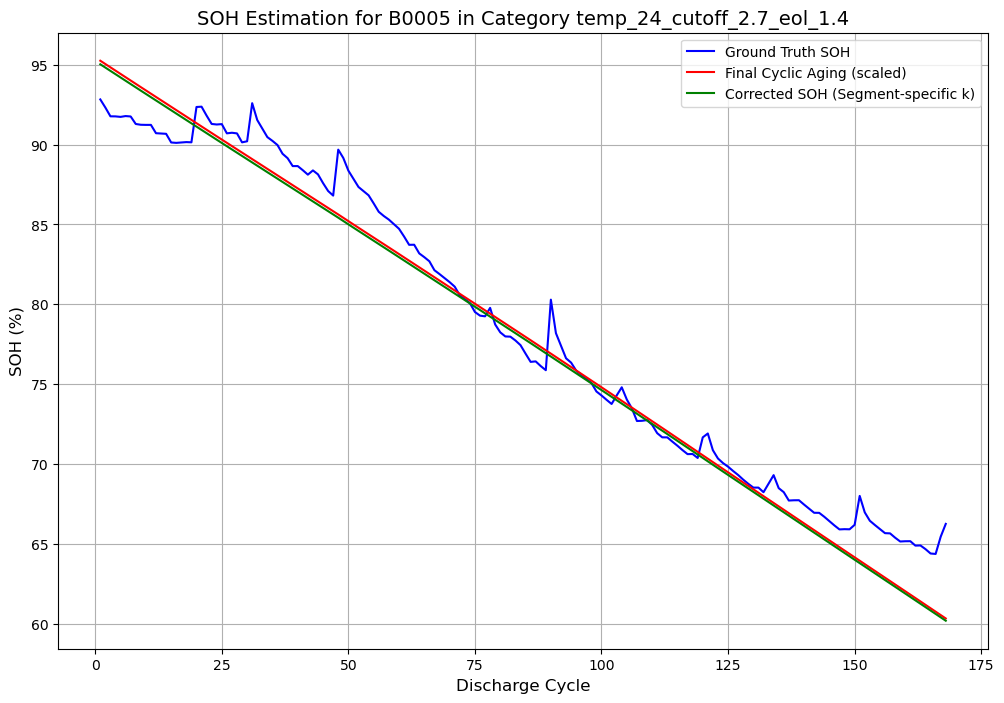

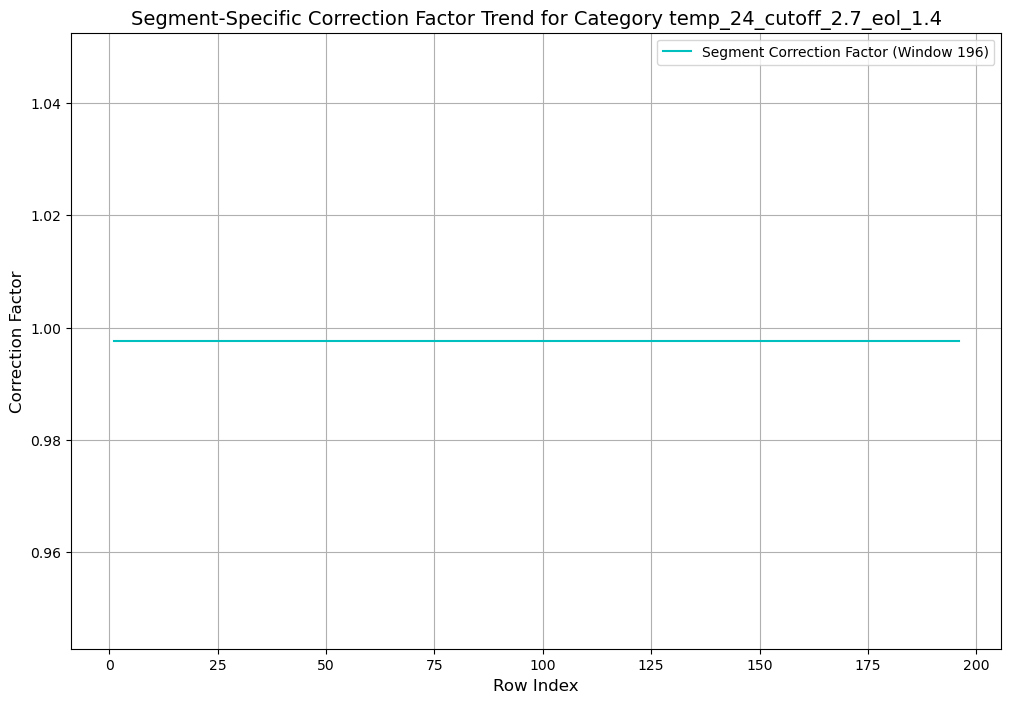


Processing category with conditions: (24, 2.5, 1.4)
Batteries: ['B0006', 'B0018', 'B0027']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0006.csv
Capacity data saved to: battery_data\capacity_soh_B0006.csv
Macro aging data saved to: battery_data\macro_aging_B0006.csv
Cycling data saved to: battery_data\NASA_cycle_dataset_B0018.csv
Capacity data saved to: battery_data\capacity_soh_B0018.csv
Macro aging data saved to: battery_data\macro_aging_B0018.csv


[I 2025-03-25 10:26:15,259] A new study created in memory with name: no-name-b07bec91-a0be-4f68-b67e-187b5457ab38
[I 2025-03-25 10:26:15,277] Trial 0 finished with value: 9881.134934941763 and parameters: {'window_size': 135}. Best is trial 0 with value: 9881.134934941763.
[I 2025-03-25 10:26:15,280] Trial 1 finished with value: 9004.13098352712 and parameters: {'window_size': 185}. Best is trial 1 with value: 9004.13098352712.
[I 2025-03-25 10:26:15,297] Trial 2 finished with value: 9.188868406063298 and parameters: {'window_size': 221}. Best is trial 2 with value: 9.188868406063298.
[I 2025-03-25 10:26:15,314] Trial 3 finished with value: 9.174254614724305 and parameters: {'window_size': 219}. Best is trial 3 with value: 9.174254614724305.
[I 2025-03-25 10:26:15,374] Trial 4 finished with value: 15383.620855549523 and parameters: {'window_size': 18}. Best is trial 3 with value: 9.174254614724305.
[I 2025-03-25 10:26:15,376] Trial 5 finished with value: 9566.508529074335 and parameter

Cycling data saved to: battery_data\NASA_cycle_dataset_B0027.csv
Capacity data saved to: battery_data\capacity_soh_B0027.csv
Macro aging data saved to: battery_data\macro_aging_B0027.csv
Category data shape: (328, 10)


[I 2025-03-25 10:26:15,450] Trial 7 finished with value: 10.441284645423755 and parameters: {'window_size': 285}. Best is trial 3 with value: 9.174254614724305.
[I 2025-03-25 10:26:15,463] Trial 8 finished with value: 10.369062517947311 and parameters: {'window_size': 319}. Best is trial 3 with value: 9.174254614724305.
[I 2025-03-25 10:26:15,479] Trial 9 finished with value: 9454.844101941055 and parameters: {'window_size': 162}. Best is trial 3 with value: 9.174254614724305.
[I 2025-03-25 10:26:15,497] Trial 10 finished with value: 9.98155138177803 and parameters: {'window_size': 247}. Best is trial 3 with value: 9.174254614724305.
[I 2025-03-25 10:26:15,514] Trial 11 finished with value: 9.232427863781794 and parameters: {'window_size': 223}. Best is trial 3 with value: 9.174254614724305.
[I 2025-03-25 10:26:15,532] Trial 12 finished with value: 9.188868406063298 and parameters: {'window_size': 221}. Best is trial 3 with value: 9.174254614724305.
[I 2025-03-25 10:26:15,561] Trial 13


Optimal Window Size for Condition (24, 2.5, 1.4): 207
Best MSE: 9.0421
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.5_eol_1.4_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.5, 1.4) (Window Size: 207):
Segment 1 (Rows 1-207): k = 1.0130
Segment 2 (Rows 208-328): k = 0.9821


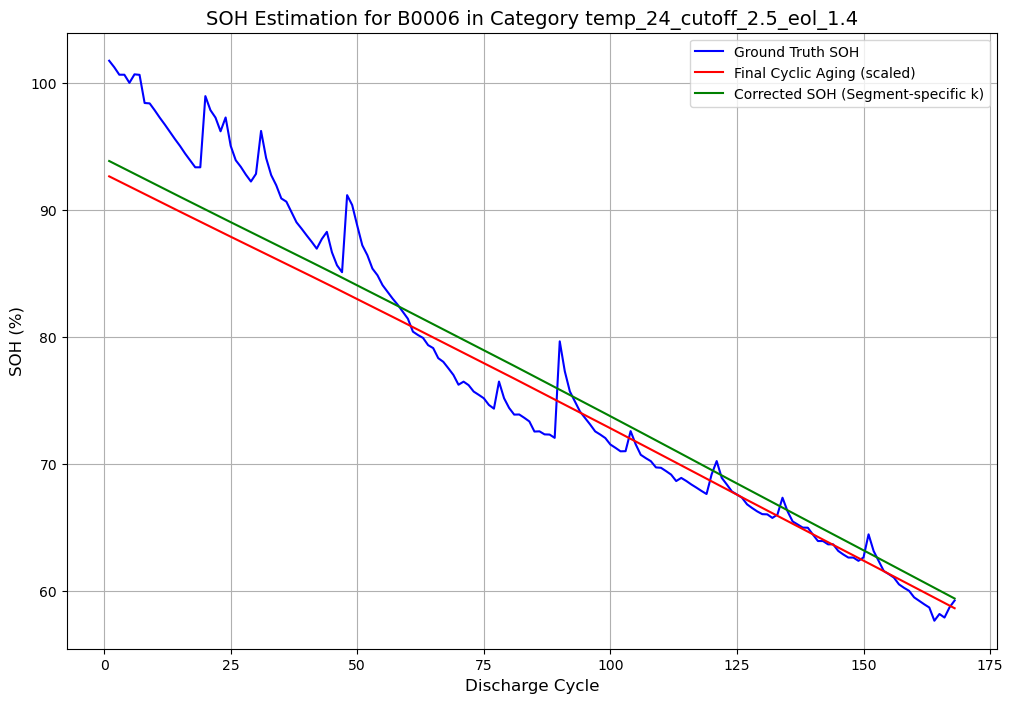

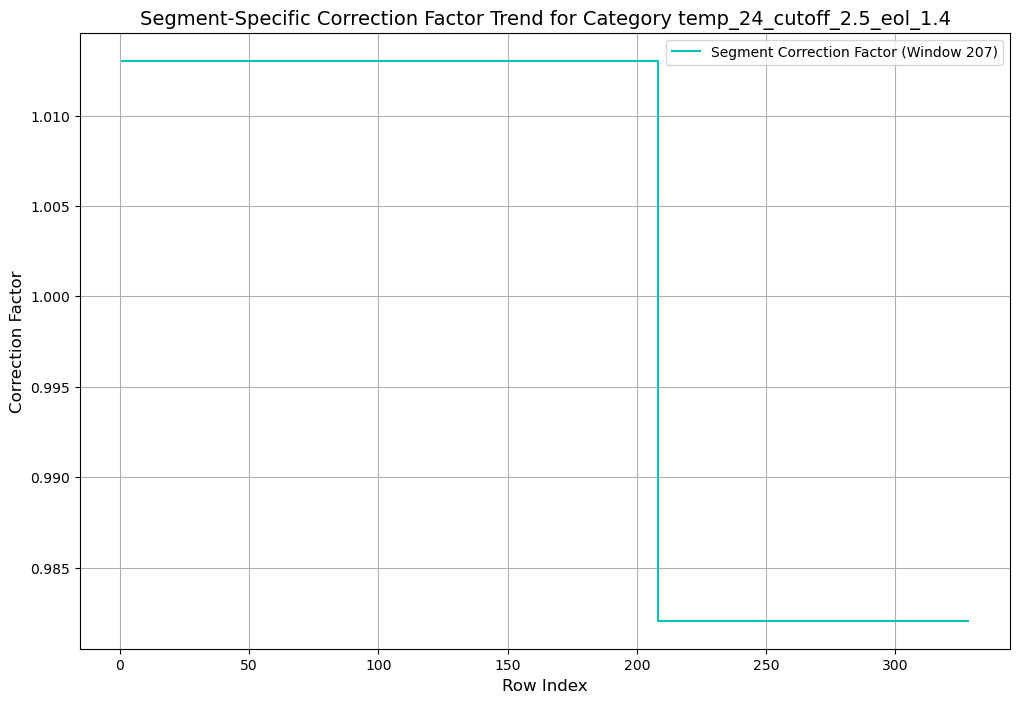


Processing category with conditions: (24, 2.2, 1.4)
Batteries: ['B0007', 'B0026']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0007.csv
Capacity data saved to: battery_data\capacity_soh_B0007.csv
Macro aging data saved to: battery_data\macro_aging_B0007.csv


[I 2025-03-25 10:26:36,534] A new study created in memory with name: no-name-2711335f-2f4e-4ae9-b04f-178abd26f2c9
[I 2025-03-25 10:26:36,547] Trial 0 finished with value: 15.856610876252475 and parameters: {'window_size': 71}. Best is trial 0 with value: 15.856610876252475.
[I 2025-03-25 10:26:36,551] Trial 1 finished with value: 17.276821928837023 and parameters: {'window_size': 190}. Best is trial 0 with value: 15.856610876252475.
[I 2025-03-25 10:26:36,566] Trial 2 finished with value: 17.829908489862717 and parameters: {'window_size': 114}. Best is trial 0 with value: 15.856610876252475.
[I 2025-03-25 10:26:36,584] Trial 3 finished with value: 14.309571156010886 and parameters: {'window_size': 176}. Best is trial 3 with value: 14.309571156010886.
[I 2025-03-25 10:26:36,600] Trial 4 finished with value: 9755.47086084638 and parameters: {'window_size': 55}. Best is trial 3 with value: 14.309571156010886.
[I 2025-03-25 10:26:36,617] Trial 5 finished with value: 15.30264905281621 and p

Cycling data saved to: battery_data\NASA_cycle_dataset_B0026.csv
Capacity data saved to: battery_data\capacity_soh_B0026.csv
Macro aging data saved to: battery_data\macro_aging_B0026.csv
Category data shape: (196, 10)


[I 2025-03-25 10:26:36,692] Trial 8 finished with value: 16.800869763661954 and parameters: {'window_size': 67}. Best is trial 7 with value: 14.21174496047542.
[I 2025-03-25 10:26:36,701] Trial 9 finished with value: 8161.965081322047 and parameters: {'window_size': 54}. Best is trial 7 with value: 14.21174496047542.
[I 2025-03-25 10:26:36,793] Trial 10 finished with value: 14717.85782313888 and parameters: {'window_size': 6}. Best is trial 7 with value: 14.21174496047542.
[I 2025-03-25 10:26:36,813] Trial 11 finished with value: 17.214047714089723 and parameters: {'window_size': 137}. Best is trial 7 with value: 14.21174496047542.
[I 2025-03-25 10:26:36,834] Trial 12 finished with value: 16.983667385312458 and parameters: {'window_size': 140}. Best is trial 7 with value: 14.21174496047542.
[I 2025-03-25 10:26:36,848] Trial 13 finished with value: 15.768542816629452 and parameters: {'window_size': 92}. Best is trial 7 with value: 14.21174496047542.
[I 2025-03-25 10:26:36,881] Trial 14 


Optimal Window Size for Condition (24, 2.2, 1.4): 40
Best MSE: 9.1558
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.2_eol_1.4_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.2, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9819
Segment 2 (Rows 41-80): k = 1.0008
Segment 3 (Rows 81-120): k = 1.0114
Segment 4 (Rows 121-160): k = 1.0621
Segment 5 (Rows 161-196): k = 0.9456


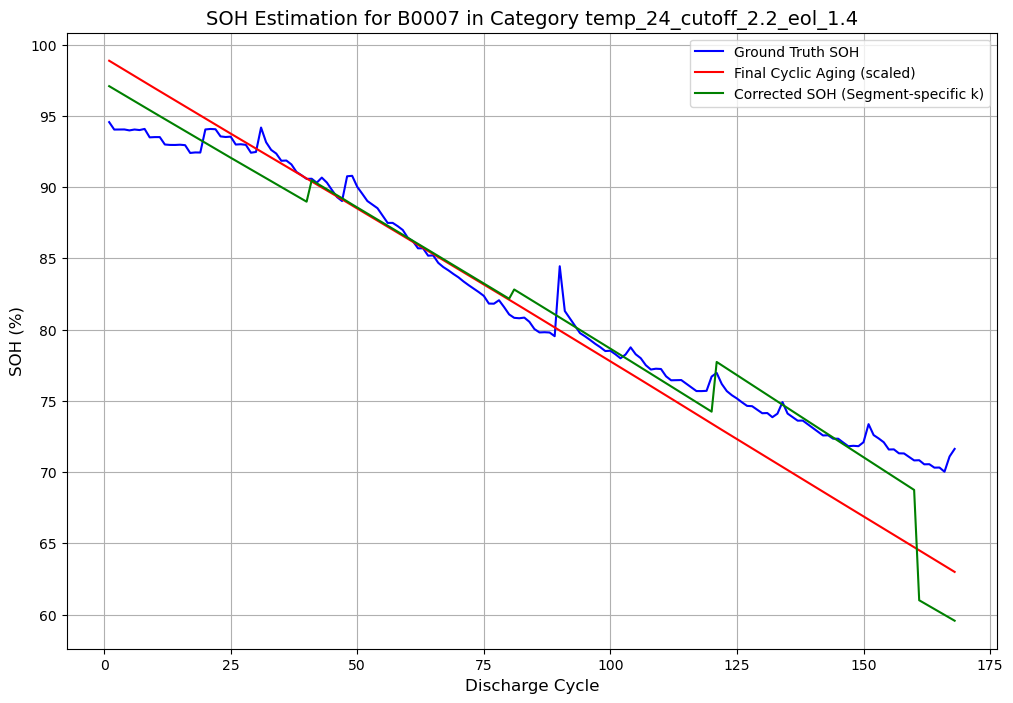

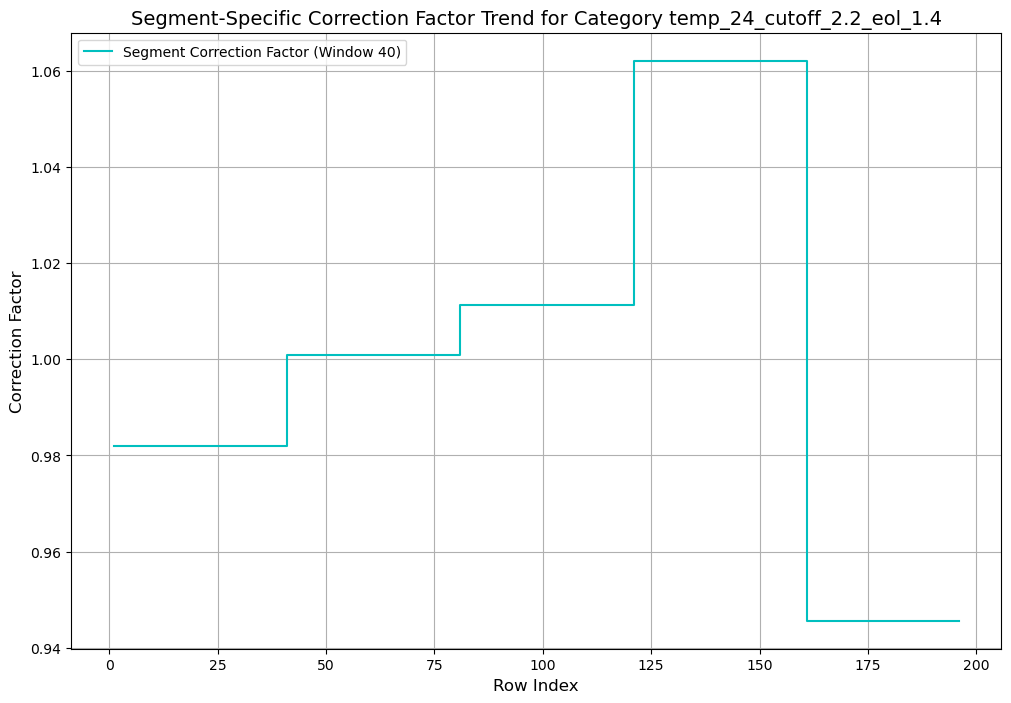


Processing category with conditions: (24, 2.0, 1.4)
Batteries: ['B0025']


[I 2025-03-25 10:26:41,797] A new study created in memory with name: no-name-90d66b72-8b85-4675-bf3e-d1eb2e594cb5
[I 2025-03-25 10:26:41,800] Trial 0 finished with value: 16772.844517539354 and parameters: {'window_size': 18}. Best is trial 0 with value: 16772.844517539354.
[I 2025-03-25 10:26:41,816] Trial 1 finished with value: 16699.50841528927 and parameters: {'window_size': 21}. Best is trial 1 with value: 16699.50841528927.
[I 2025-03-25 10:26:41,831] Trial 2 finished with value: 16699.50841528927 and parameters: {'window_size': 21}. Best is trial 1 with value: 16699.50841528927.
[I 2025-03-25 10:26:41,850] Trial 3 finished with value: 16834.186489255557 and parameters: {'window_size': 5}. Best is trial 1 with value: 16699.50841528927.
[I 2025-03-25 10:26:41,861] Trial 4 finished with value: 16864.248044137934 and parameters: {'window_size': 7}. Best is trial 1 with value: 16699.50841528927.
[I 2025-03-25 10:26:41,884] Trial 5 finished with value: 16899.79115949536 and parameters

Cycling data saved to: battery_data\NASA_cycle_dataset_B0025.csv
Capacity data saved to: battery_data\capacity_soh_B0025.csv
Macro aging data saved to: battery_data\macro_aging_B0025.csv
Category data shape: (28, 10)


[I 2025-03-25 10:26:41,948] Trial 10 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 10 with value: 16460.772432039776.
[I 2025-03-25 10:26:41,964] Trial 11 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 10 with value: 16460.772432039776.
[I 2025-03-25 10:26:41,979] Trial 12 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 10 with value: 16460.772432039776.
[I 2025-03-25 10:26:41,999] Trial 13 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 10 with value: 16460.772432039776.
[I 2025-03-25 10:26:42,017] Trial 14 finished with value: 16715.23478428774 and parameters: {'window_size': 13}. Best is trial 10 with value: 16460.772432039776.
[I 2025-03-25 10:26:42,035] Trial 15 finished with value: 16715.23478428774 and parameters: {'window_size': 13}. Best is trial 10 with value: 16460.772432039776.
[I 2025-03-25 10:26:42,0


Optimal Window Size for Condition (24, 2.0, 1.4): 28
Best MSE: 16460.7724
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.0_eol_1.4_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.0, 1.4) (Window Size: 28):
Segment 1 (Rows 1-28): k = 0.9999


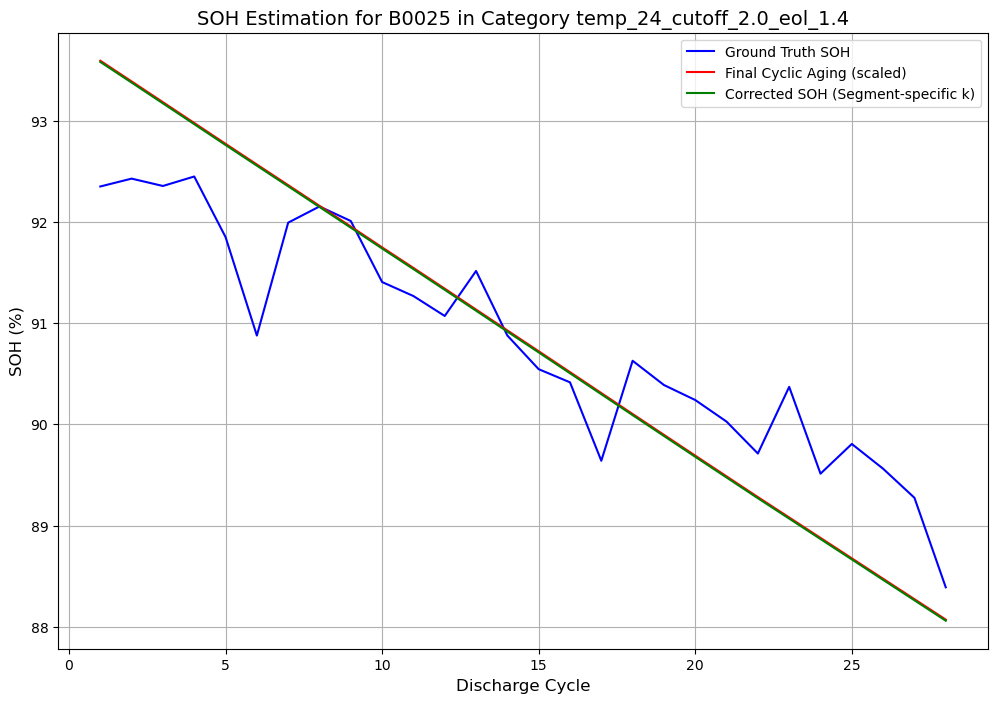

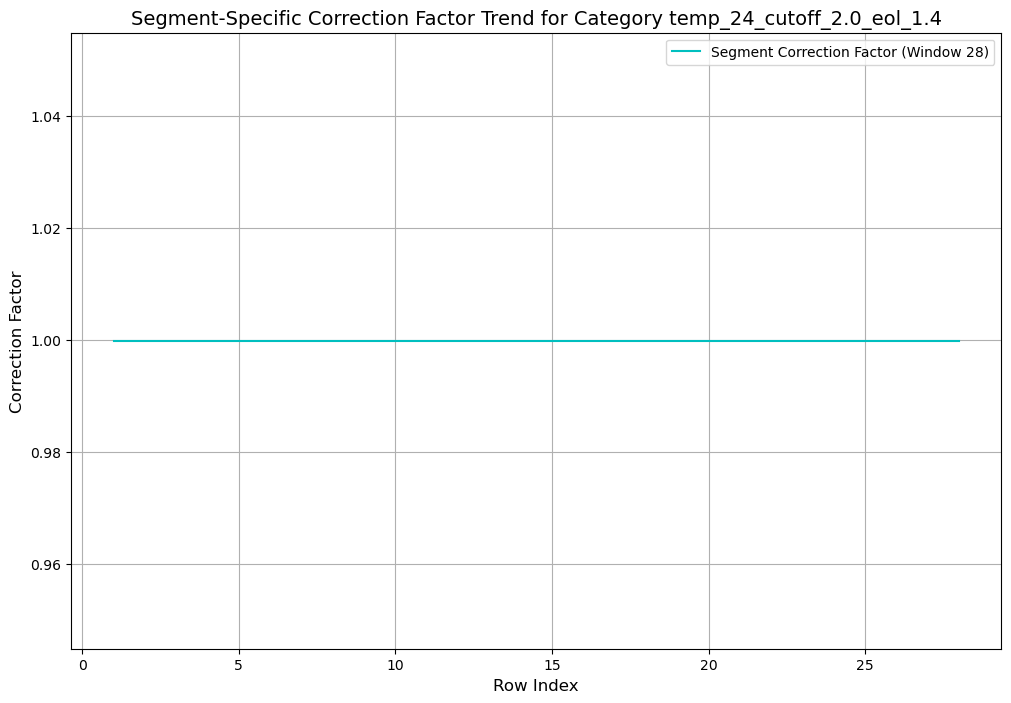


Processing category with conditions: (43, 2.0, 1.4)
Batteries: ['B0029']


[I 2025-03-25 10:26:46,167] A new study created in memory with name: no-name-513cb562-da83-435d-bbbc-b137ef87455f
[I 2025-03-25 10:26:46,182] Trial 0 finished with value: 15530.191120230693 and parameters: {'window_size': 22}. Best is trial 0 with value: 15530.191120230693.
[I 2025-03-25 10:26:46,197] Trial 1 finished with value: 15663.564365488555 and parameters: {'window_size': 14}. Best is trial 0 with value: 15530.191120230693.
[I 2025-03-25 10:26:46,215] Trial 2 finished with value: 15478.48738911667 and parameters: {'window_size': 35}. Best is trial 2 with value: 15478.48738911667.
[I 2025-03-25 10:26:46,215] Trial 3 finished with value: 15447.562413394991 and parameters: {'window_size': 39}. Best is trial 3 with value: 15447.562413394991.
[I 2025-03-25 10:26:46,232] Trial 4 finished with value: 15447.473141458448 and parameters: {'window_size': 40}. Best is trial 4 with value: 15447.473141458448.
[I 2025-03-25 10:26:46,239] Trial 5 finished with value: 15470.553984897631 and par

Cycling data saved to: battery_data\NASA_cycle_dataset_B0029.csv
Capacity data saved to: battery_data\capacity_soh_B0029.csv
Macro aging data saved to: battery_data\macro_aging_B0029.csv
Category data shape: (40, 10)


[I 2025-03-25 10:26:46,341] Trial 11 finished with value: 15447.473141458448 and parameters: {'window_size': 40}. Best is trial 4 with value: 15447.473141458448.
[I 2025-03-25 10:26:46,351] Trial 12 finished with value: 15487.66534025733 and parameters: {'window_size': 29}. Best is trial 4 with value: 15447.473141458448.
[I 2025-03-25 10:26:46,379] Trial 13 finished with value: 15447.562413394991 and parameters: {'window_size': 39}. Best is trial 4 with value: 15447.473141458448.
[I 2025-03-25 10:26:46,395] Trial 14 finished with value: 15473.271704934012 and parameters: {'window_size': 31}. Best is trial 4 with value: 15447.473141458448.
[I 2025-03-25 10:26:46,418] Trial 15 finished with value: 15447.562413394991 and parameters: {'window_size': 39}. Best is trial 4 with value: 15447.473141458448.
[I 2025-03-25 10:26:46,429] Trial 16 finished with value: 15514.220795810748 and parameters: {'window_size': 26}. Best is trial 4 with value: 15447.473141458448.
[I 2025-03-25 10:26:46,452] T


Optimal Window Size for Condition (43, 2.0, 1.4): 40
Best MSE: 15447.4731
Category corrected SOH data saved to: battery_data\category_temp_43_cutoff_2.0_eol_1.4_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.0, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9998


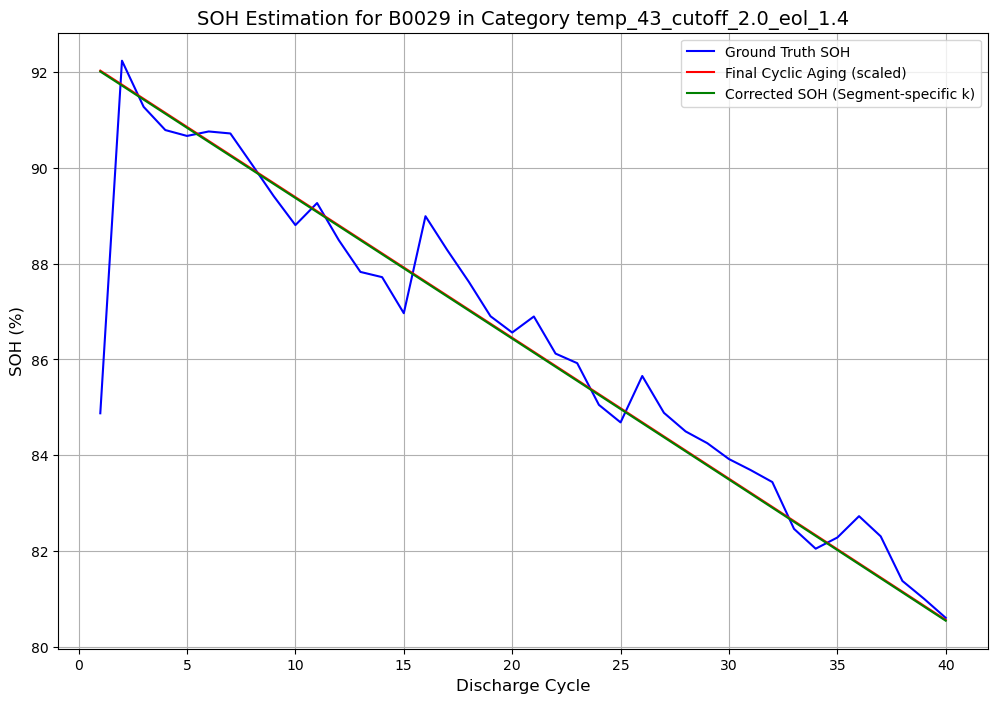

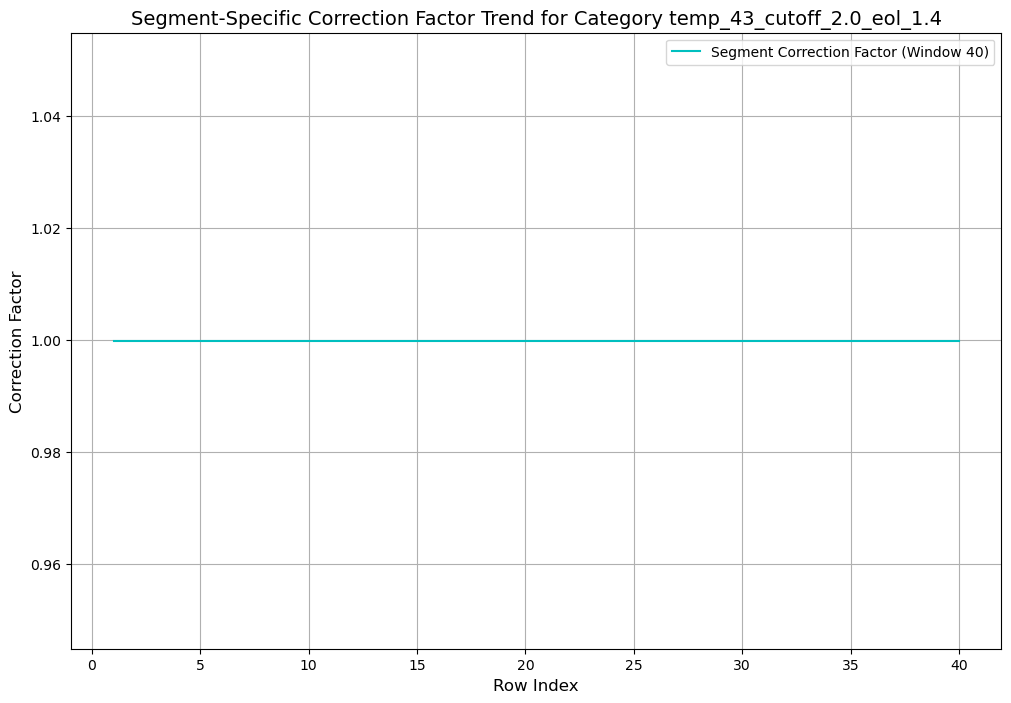


Processing category with conditions: (43, 2.2, 1.4)
Batteries: ['B0030']


[I 2025-03-25 10:26:50,603] A new study created in memory with name: no-name-6fa78dc3-a810-4f7d-9dd8-a12c4babcc0f
[I 2025-03-25 10:26:50,619] Trial 0 finished with value: 16086.552105825744 and parameters: {'window_size': 5}. Best is trial 0 with value: 16086.552105825744.
[I 2025-03-25 10:26:50,647] Trial 1 finished with value: 15904.517155009937 and parameters: {'window_size': 6}. Best is trial 1 with value: 15904.517155009937.
[I 2025-03-25 10:26:50,665] Trial 2 finished with value: 15870.528214225918 and parameters: {'window_size': 10}. Best is trial 2 with value: 15870.528214225918.
[I 2025-03-25 10:26:50,665] Trial 3 finished with value: 15680.490041838808 and parameters: {'window_size': 37}. Best is trial 3 with value: 15680.490041838808.
[I 2025-03-25 10:26:50,689] Trial 4 finished with value: 15837.7555931504 and parameters: {'window_size': 17}. Best is trial 3 with value: 15680.490041838808.
[I 2025-03-25 10:26:50,698] Trial 5 finished with value: 15905.872025549224 and param

Cycling data saved to: battery_data\NASA_cycle_dataset_B0030.csv
Capacity data saved to: battery_data\capacity_soh_B0030.csv
Macro aging data saved to: battery_data\macro_aging_B0030.csv
Category data shape: (40, 10)


[I 2025-03-25 10:26:50,782] Trial 11 finished with value: 15615.338092128215 and parameters: {'window_size': 40}. Best is trial 10 with value: 15615.338092128215.
[I 2025-03-25 10:26:50,812] Trial 12 finished with value: 15717.68918413755 and parameters: {'window_size': 31}. Best is trial 10 with value: 15615.338092128215.
[I 2025-03-25 10:26:50,827] Trial 13 finished with value: 15731.495373896136 and parameters: {'window_size': 29}. Best is trial 10 with value: 15615.338092128215.
[I 2025-03-25 10:26:50,848] Trial 14 finished with value: 15717.68918413755 and parameters: {'window_size': 31}. Best is trial 10 with value: 15615.338092128215.
[I 2025-03-25 10:26:50,865] Trial 15 finished with value: 15750.45629360503 and parameters: {'window_size': 35}. Best is trial 10 with value: 15615.338092128215.
[I 2025-03-25 10:26:50,882] Trial 16 finished with value: 15615.338092128215 and parameters: {'window_size': 40}. Best is trial 10 with value: 15615.338092128215.
[I 2025-03-25 10:26:50,89


Optimal Window Size for Condition (43, 2.2, 1.4): 40
Best MSE: 15615.3381
Category corrected SOH data saved to: battery_data\category_temp_43_cutoff_2.2_eol_1.4_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.2, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9997


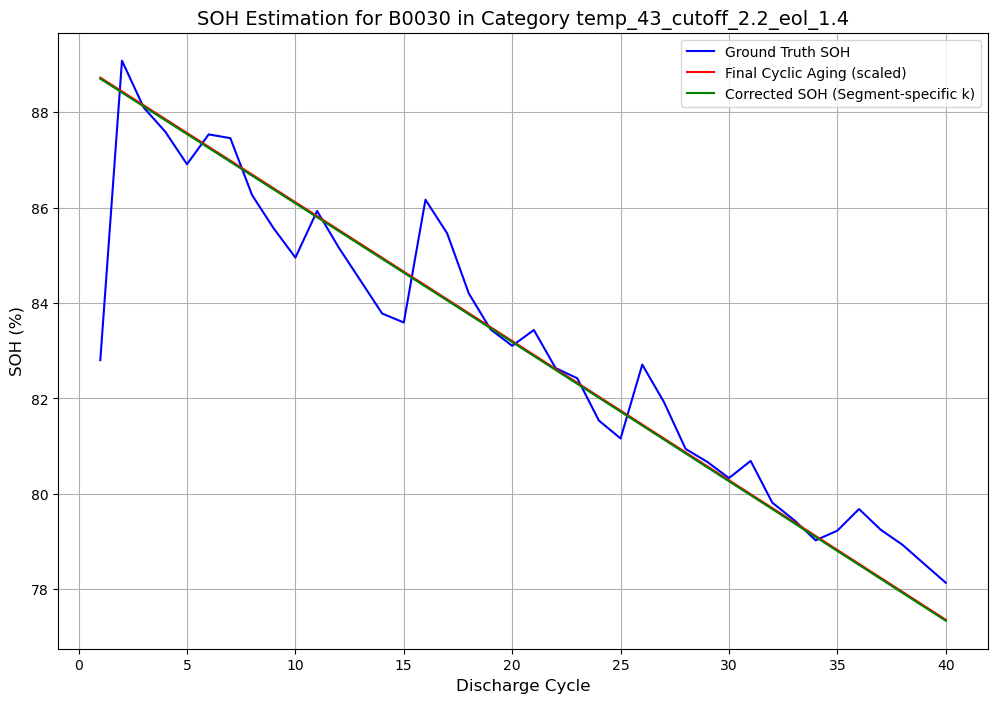

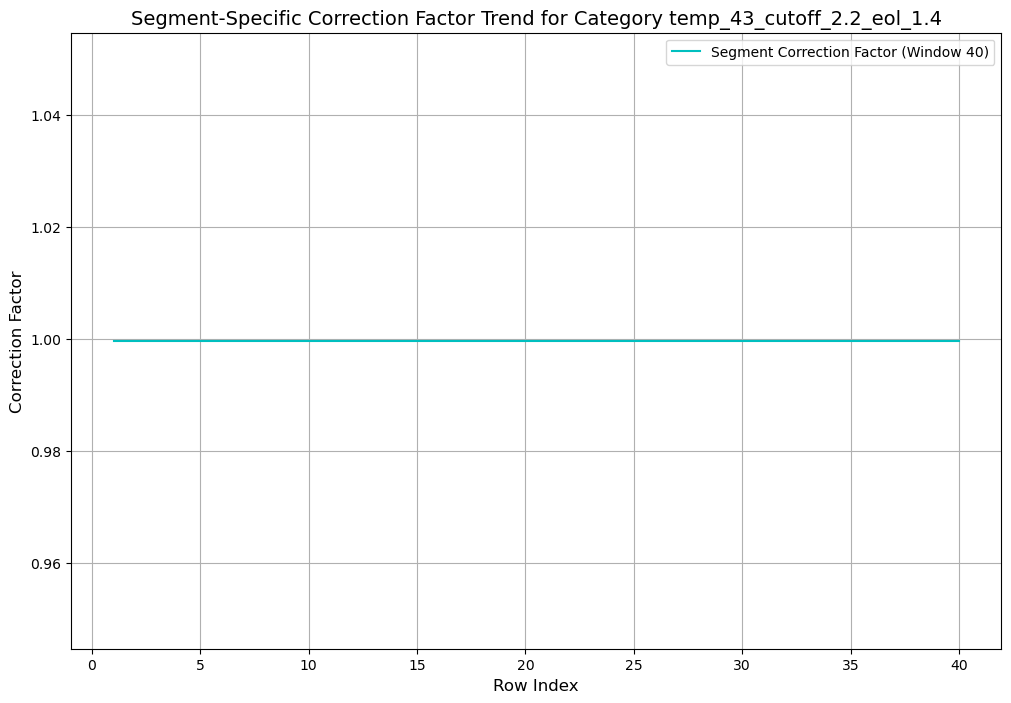


Processing category with conditions: (43, 2.5, 1.4)
Batteries: ['B0031']


[I 2025-03-25 10:26:55,104] A new study created in memory with name: no-name-5f665758-5acd-465c-87c6-3a2f6dee0236
[I 2025-03-25 10:26:55,120] Trial 0 finished with value: 14041.507735133413 and parameters: {'window_size': 27}. Best is trial 0 with value: 14041.507735133413.
[I 2025-03-25 10:26:55,132] Trial 1 finished with value: 12768.601310998813 and parameters: {'window_size': 39}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:26:55,149] Trial 2 finished with value: 15324.562053434849 and parameters: {'window_size': 8}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:26:55,166] Trial 3 finished with value: 15070.932649508684 and parameters: {'window_size': 16}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:26:55,182] Trial 4 finished with value: 14041.507735133413 and parameters: {'window_size': 27}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:26:55,198] Trial 5 finished with value: 13557.861828646908 and pa

Cycling data saved to: battery_data\NASA_cycle_dataset_B0031.csv
Capacity data saved to: battery_data\capacity_soh_B0031.csv
Macro aging data saved to: battery_data\macro_aging_B0031.csv
Category data shape: (40, 10)


[I 2025-03-25 10:26:55,301] Trial 9 finished with value: 15658.421056731484 and parameters: {'window_size': 3}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:26:55,315] Trial 10 finished with value: 12768.601310998813 and parameters: {'window_size': 39}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:26:55,332] Trial 11 finished with value: 13369.635418363217 and parameters: {'window_size': 35}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:26:55,345] Trial 12 finished with value: 12768.601310998813 and parameters: {'window_size': 39}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:26:55,361] Trial 13 finished with value: 12649.957369766193 and parameters: {'window_size': 40}. Best is trial 13 with value: 12649.957369766193.
[I 2025-03-25 10:26:55,378] Trial 14 finished with value: 13866.265879202374 and parameters: {'window_size': 30}. Best is trial 13 with value: 12649.957369766193.
[I 2025-03-25 10:26:55,383] 


Optimal Window Size for Condition (43, 2.5, 1.4): 40
Best MSE: 12649.9574
Category corrected SOH data saved to: battery_data\category_temp_43_cutoff_2.5_eol_1.4_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.5, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9992


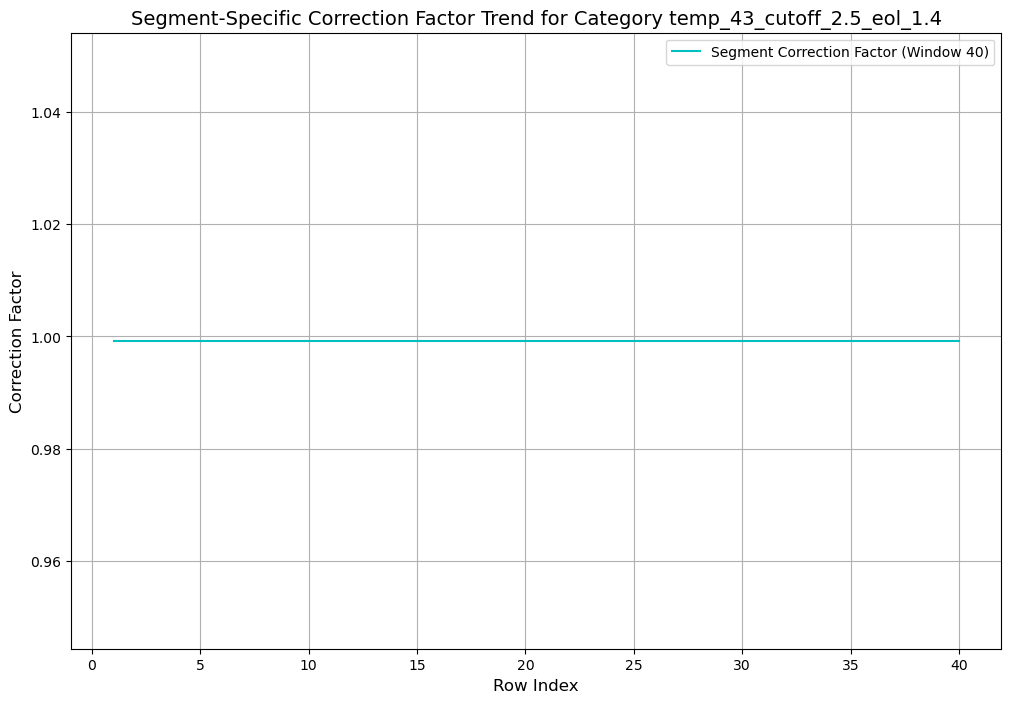


Processing category with conditions: (43, 2.7, 1.4)
Batteries: ['B0032']


[I 2025-03-25 10:26:59,624] A new study created in memory with name: no-name-fc0bdda1-d117-42aa-95da-3195cd407857
[I 2025-03-25 10:26:59,645] Trial 0 finished with value: 15061.9299135629 and parameters: {'window_size': 15}. Best is trial 0 with value: 15061.9299135629.
[I 2025-03-25 10:26:59,663] Trial 1 finished with value: 15012.702458256696 and parameters: {'window_size': 16}. Best is trial 1 with value: 15012.702458256696.
[I 2025-03-25 10:26:59,674] Trial 2 finished with value: 14959.713870136737 and parameters: {'window_size': 11}. Best is trial 2 with value: 14959.713870136737.
[I 2025-03-25 10:26:59,680] Trial 3 finished with value: 14803.39693995835 and parameters: {'window_size': 40}. Best is trial 3 with value: 14803.39693995835.
[I 2025-03-25 10:26:59,695] Trial 4 finished with value: 15049.637588385964 and parameters: {'window_size': 7}. Best is trial 3 with value: 14803.39693995835.
[I 2025-03-25 10:26:59,695] Trial 5 finished with value: 14872.390362671023 and parameter

Cycling data saved to: battery_data\NASA_cycle_dataset_B0032.csv
Capacity data saved to: battery_data\capacity_soh_B0032.csv
Macro aging data saved to: battery_data\macro_aging_B0032.csv
Category data shape: (40, 10)


[I 2025-03-25 10:26:59,778] Trial 12 finished with value: 14895.593490990761 and parameters: {'window_size': 24}. Best is trial 3 with value: 14803.39693995835.
[I 2025-03-25 10:26:59,795] Trial 13 finished with value: 14815.46454088079 and parameters: {'window_size': 37}. Best is trial 3 with value: 14803.39693995835.
[I 2025-03-25 10:26:59,810] Trial 14 finished with value: 14917.927621093475 and parameters: {'window_size': 25}. Best is trial 3 with value: 14803.39693995835.
[I 2025-03-25 10:26:59,828] Trial 15 finished with value: 14803.69126464544 and parameters: {'window_size': 39}. Best is trial 3 with value: 14803.39693995835.
[I 2025-03-25 10:26:59,845] Trial 16 finished with value: 14890.38067536103 and parameters: {'window_size': 29}. Best is trial 3 with value: 14803.39693995835.
[I 2025-03-25 10:26:59,845] Trial 17 finished with value: 14872.390362671023 and parameters: {'window_size': 34}. Best is trial 3 with value: 14803.39693995835.
[I 2025-03-25 10:26:59,878] Trial 18 


Optimal Window Size for Condition (43, 2.7, 1.4): 40
Best MSE: 14803.3969
Category corrected SOH data saved to: battery_data\category_temp_43_cutoff_2.7_eol_1.4_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.7, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9998


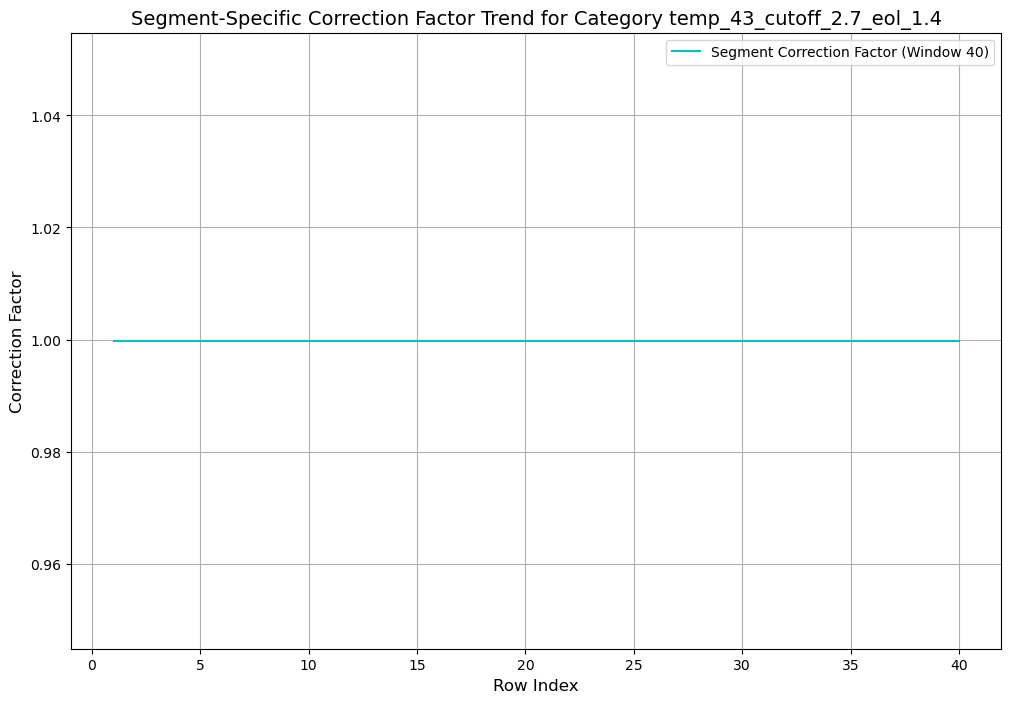


Processing category with conditions: (24, 2.0, 1.6)
Batteries: ['B0033']


[I 2025-03-25 10:27:12,585] A new study created in memory with name: no-name-56229e5a-9b91-419a-94a7-153ac12f22ee
[I 2025-03-25 10:27:12,601] Trial 0 finished with value: 142754.43437681682 and parameters: {'window_size': 36}. Best is trial 0 with value: 142754.43437681682.
[I 2025-03-25 10:27:12,601] Trial 1 finished with value: 158338.57510810826 and parameters: {'window_size': 161}. Best is trial 0 with value: 142754.43437681682.
[I 2025-03-25 10:27:12,618] Trial 2 finished with value: 146670.52771041868 and parameters: {'window_size': 42}. Best is trial 0 with value: 142754.43437681682.
[I 2025-03-25 10:27:12,632] Trial 3 finished with value: 198058.3432748275 and parameters: {'window_size': 186}. Best is trial 0 with value: 142754.43437681682.
[I 2025-03-25 10:27:12,635] Trial 4 finished with value: 188826.85252728077 and parameters: {'window_size': 97}. Best is trial 0 with value: 142754.43437681682.
[I 2025-03-25 10:27:12,652] Trial 5 finished with value: 179082.5611146508 and p

Cycling data saved to: battery_data\NASA_cycle_dataset_B0033.csv
Capacity data saved to: battery_data\capacity_soh_B0033.csv
Macro aging data saved to: battery_data\macro_aging_B0033.csv
Category data shape: (197, 10)


[I 2025-03-25 10:27:12,695] Trial 9 finished with value: 164179.26586881903 and parameters: {'window_size': 85}. Best is trial 0 with value: 142754.43437681682.
[I 2025-03-25 10:27:12,809] Trial 10 finished with value: 26926.28117731318 and parameters: {'window_size': 4}. Best is trial 10 with value: 26926.28117731318.
[I 2025-03-25 10:27:12,844] Trial 11 finished with value: 92185.5994614504 and parameters: {'window_size': 14}. Best is trial 10 with value: 26926.28117731318.
[I 2025-03-25 10:27:12,956] Trial 12 finished with value: 26926.28117731318 and parameters: {'window_size': 4}. Best is trial 10 with value: 26926.28117731318.
[I 2025-03-25 10:27:12,994] Trial 13 finished with value: 90343.21734192439 and parameters: {'window_size': 11}. Best is trial 10 with value: 26926.28117731318.
[I 2025-03-25 10:27:13,012] Trial 14 finished with value: 197809.19137563565 and parameters: {'window_size': 124}. Best is trial 10 with value: 26926.28117731318.
[I 2025-03-25 10:27:13,098] Trial 1


Optimal Window Size for Condition (24, 2.0, 1.6): 3
Best MSE: 8213.3258
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.0_eol_1.6_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.0, 1.6) (Window Size: 3):
Segment 1 (Rows 1-3): k = 0.5000
Segment 2 (Rows 4-6): k = 0.7053
Segment 3 (Rows 7-9): k = 0.8532
Segment 4 (Rows 10-12): k = 0.8952
Segment 5 (Rows 13-15): k = 0.8805
Segment 6 (Rows 16-18): k = 0.9119
Segment 7 (Rows 19-21): k = 0.9028
Segment 8 (Rows 22-24): k = 0.9583
Segment 9 (Rows 25-27): k = 0.9433
Segment 10 (Rows 28-30): k = 0.9481
Segment 11 (Rows 31-33): k = 0.9422
Segment 12 (Rows 34-36): k = 0.9408
Segment 13 (Rows 37-39): k = 0.9514
Segment 14 (Rows 40-42): k = 0.9479
Segment 15 (Rows 43-45): k = 0.9787
Segment 16 (Rows 46-48): k = 1.0468
Segment 17 (Rows 49-51): k = 0.9879
Segment 18 (Rows 52-54): k = 0.9890
Segment 19 (Rows 55-57): k = 0.9897
Segment 20 (Rows 58-60): k = 0.9788
Segment 21 (Rows 61-63): k = 0.9814


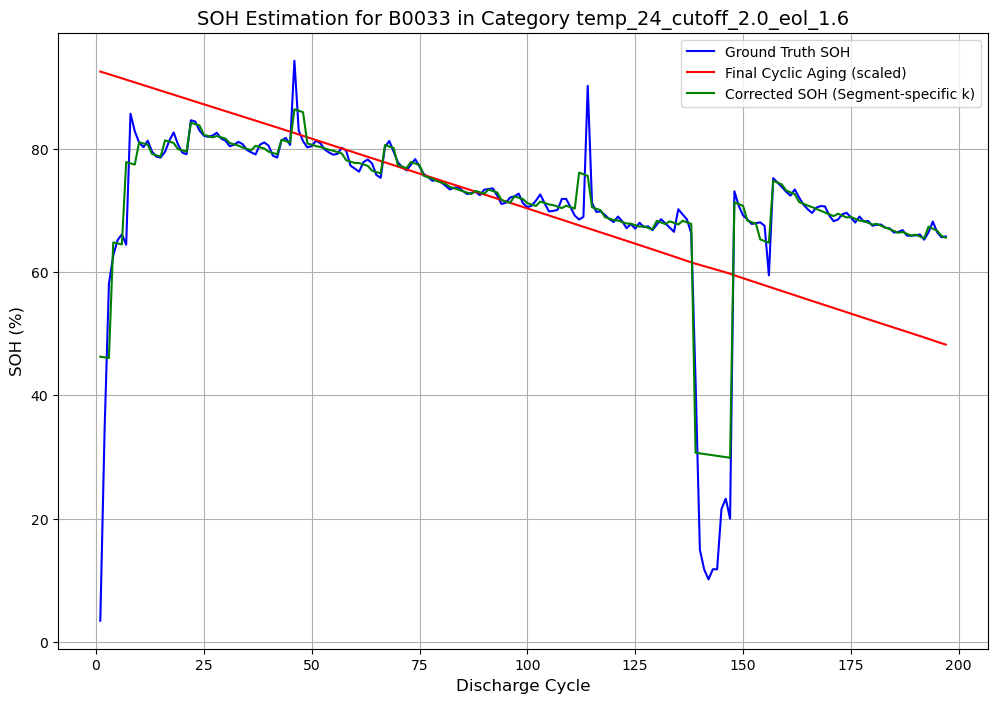

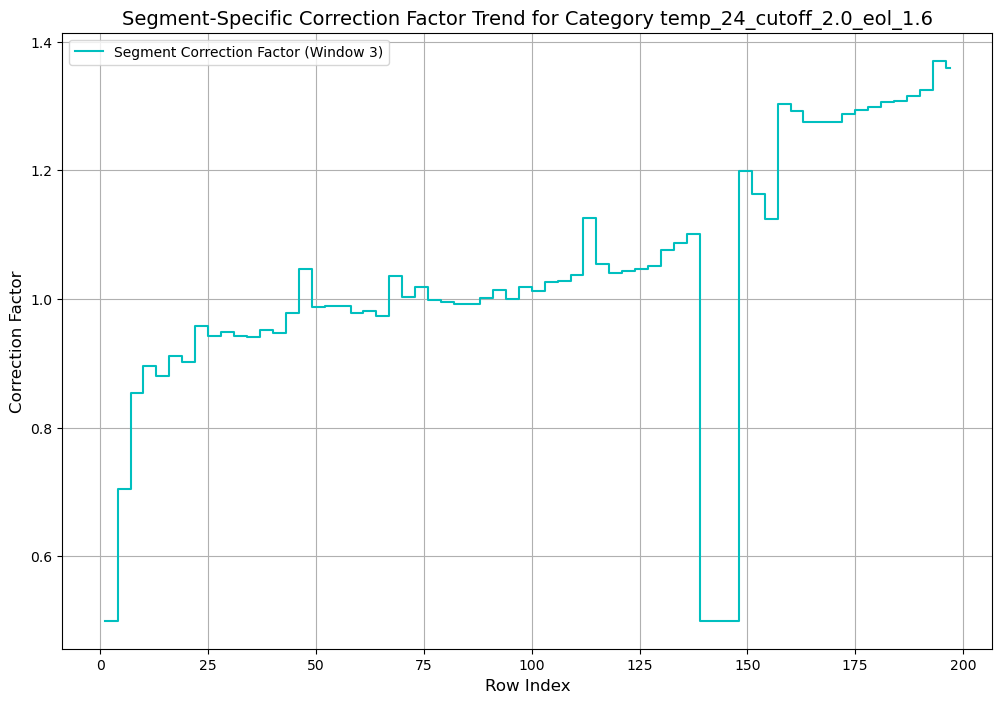


Processing category with conditions: (24, 2.2, 1.6)
Batteries: ['B0034', 'B0038']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0034.csv
Capacity data saved to: battery_data\capacity_soh_B0034.csv
Macro aging data saved to: battery_data\macro_aging_B0034.csv


[I 2025-03-25 10:27:30,620] A new study created in memory with name: no-name-fe092c62-5700-43c0-9cac-3c6b1192f50f
[I 2025-03-25 10:27:30,665] Trial 0 finished with value: 64671.201455117 and parameters: {'window_size': 23}. Best is trial 0 with value: 64671.201455117.
[I 2025-03-25 10:27:30,769] Trial 1 finished with value: 14572.27842852127 and parameters: {'window_size': 6}. Best is trial 1 with value: 14572.27842852127.


Cycling data saved to: battery_data\NASA_cycle_dataset_B0038.csv
Capacity data saved to: battery_data\capacity_soh_B0038.csv
Macro aging data saved to: battery_data\macro_aging_B0038.csv
Category data shape: (244, 10)


[I 2025-03-25 10:27:30,785] Trial 2 finished with value: 116006.21019809134 and parameters: {'window_size': 84}. Best is trial 1 with value: 14572.27842852127.
[I 2025-03-25 10:27:30,818] Trial 3 finished with value: 32591.559580708225 and parameters: {'window_size': 19}. Best is trial 1 with value: 14572.27842852127.
[I 2025-03-25 10:27:30,836] Trial 4 finished with value: 85116.5335353371 and parameters: {'window_size': 44}. Best is trial 1 with value: 14572.27842852127.
[I 2025-03-25 10:27:30,869] Trial 5 finished with value: 42409.07527032029 and parameters: {'window_size': 18}. Best is trial 1 with value: 14572.27842852127.
[I 2025-03-25 10:27:30,886] Trial 6 finished with value: 111884.86893213697 and parameters: {'window_size': 52}. Best is trial 1 with value: 14572.27842852127.
[I 2025-03-25 10:27:30,898] Trial 7 finished with value: 125736.87435933038 and parameters: {'window_size': 118}. Best is trial 1 with value: 14572.27842852127.
[I 2025-03-25 10:27:30,922] Trial 8 finish


Optimal Window Size for Condition (24, 2.2, 1.6): 4
Best MSE: 20.6982
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.2_eol_1.6_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.2, 1.6) (Window Size: 4):
Segment 1 (Rows 1-4): k = 0.7915
Segment 2 (Rows 5-8): k = 0.8514
Segment 3 (Rows 9-12): k = 0.8231
Segment 4 (Rows 13-16): k = 0.8229
Segment 5 (Rows 17-20): k = 0.8567
Segment 6 (Rows 21-24): k = 0.8983
Segment 7 (Rows 25-28): k = 0.8812
Segment 8 (Rows 29-32): k = 0.8638
Segment 9 (Rows 33-36): k = 0.8679
Segment 10 (Rows 37-40): k = 0.8959
Segment 11 (Rows 41-44): k = 0.9143
Segment 12 (Rows 45-48): k = 1.0106
Segment 13 (Rows 49-52): k = 0.9536
Segment 14 (Rows 53-56): k = 0.9296
Segment 15 (Rows 57-60): k = 0.9344
Segment 16 (Rows 61-64): k = 0.9362
Segment 17 (Rows 65-68): k = 0.9691
Segment 18 (Rows 69-72): k = 0.9671
Segment 19 (Rows 73-76): k = 0.9737
Segment 20 (Rows 77-80): k = 0.9294
Segment 21 (Rows 81-84): k = 0.9353
S

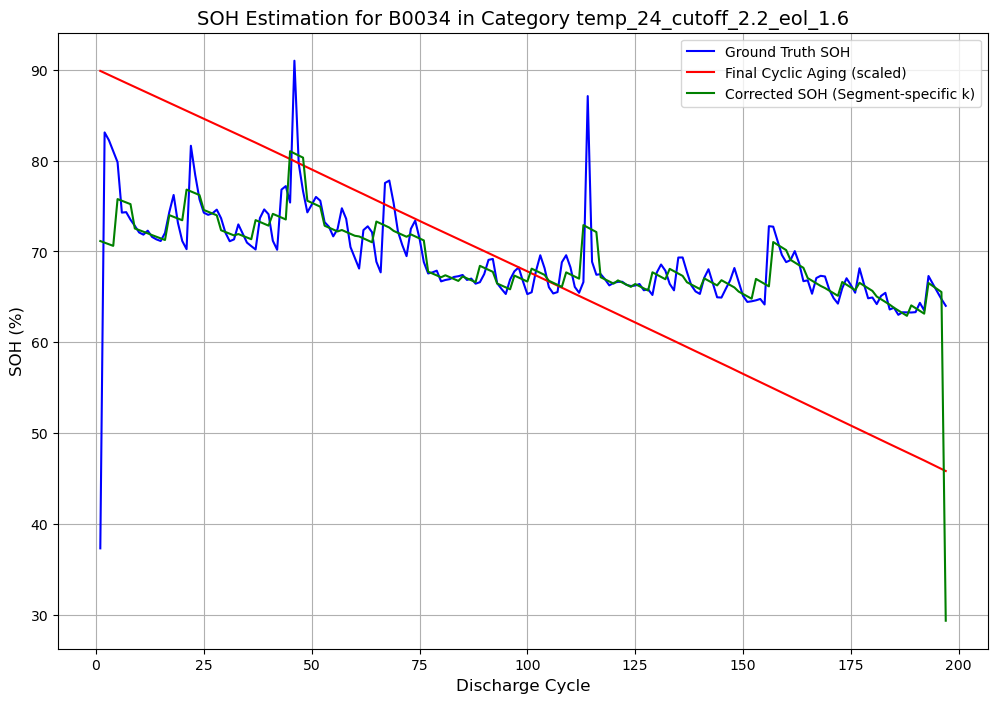

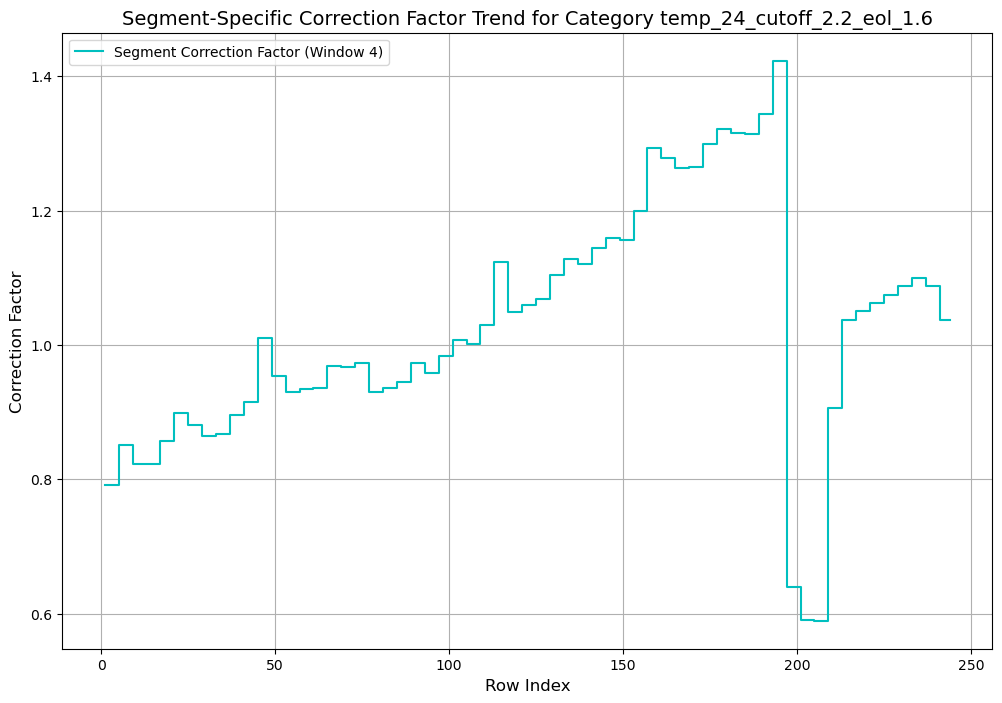


Processing category with conditions: (24, 2.7, 1.6)
Batteries: ['B0036', 'B0040']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0036.csv
Capacity data saved to: battery_data\capacity_soh_B0036.csv
Macro aging data saved to: battery_data\macro_aging_B0036.csv


[I 2025-03-25 10:27:49,812] A new study created in memory with name: no-name-7618eff8-3654-465b-b681-e232c2489c20
[I 2025-03-25 10:27:49,819] Trial 0 finished with value: 200289.4945213164 and parameters: {'window_size': 90}. Best is trial 0 with value: 200289.4945213164.
[I 2025-03-25 10:27:49,834] Trial 1 finished with value: 303413.2631923582 and parameters: {'window_size': 225}. Best is trial 0 with value: 200289.4945213164.
[I 2025-03-25 10:27:49,919] Trial 2 finished with value: 69677.63497661495 and parameters: {'window_size': 10}. Best is trial 2 with value: 69677.63497661495.


Cycling data saved to: battery_data\NASA_cycle_dataset_B0040.csv
Capacity data saved to: battery_data\capacity_soh_B0040.csv
Macro aging data saved to: battery_data\macro_aging_B0040.csv
Category data shape: (244, 10)


[I 2025-03-25 10:27:49,969] Trial 3 finished with value: 41598.06672182635 and parameters: {'window_size': 15}. Best is trial 3 with value: 41598.06672182635.
[I 2025-03-25 10:27:49,982] Trial 4 finished with value: 303412.46001229563 and parameters: {'window_size': 224}. Best is trial 3 with value: 41598.06672182635.
[I 2025-03-25 10:27:49,985] Trial 5 finished with value: 301837.10569254385 and parameters: {'window_size': 110}. Best is trial 3 with value: 41598.06672182635.
[I 2025-03-25 10:27:50,003] Trial 6 finished with value: 287705.4870315809 and parameters: {'window_size': 158}. Best is trial 3 with value: 41598.06672182635.
[I 2025-03-25 10:27:50,013] Trial 7 finished with value: 294151.6173588233 and parameters: {'window_size': 152}. Best is trial 3 with value: 41598.06672182635.
[I 2025-03-25 10:27:50,049] Trial 8 finished with value: 35701.16603376764 and parameters: {'window_size': 14}. Best is trial 8 with value: 35701.16603376764.
[I 2025-03-25 10:27:50,069] Trial 9 fini


Optimal Window Size for Condition (24, 2.7, 1.6): 4
Best MSE: 30263.9998
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.7_eol_1.6_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.7, 1.6) (Window Size: 4):
Segment 1 (Rows 1-4): k = 0.8044
Segment 2 (Rows 5-8): k = 0.9066
Segment 3 (Rows 9-12): k = 0.9099
Segment 4 (Rows 13-16): k = 0.9132
Segment 5 (Rows 17-20): k = 0.9214
Segment 6 (Rows 21-24): k = 0.9309
Segment 7 (Rows 25-28): k = 0.9369
Segment 8 (Rows 29-32): k = 0.9386
Segment 9 (Rows 33-36): k = 0.9421
Segment 10 (Rows 37-40): k = 0.9501
Segment 11 (Rows 41-44): k = 0.9557
Segment 12 (Rows 45-48): k = 1.0019
Segment 13 (Rows 49-52): k = 0.9794
Segment 14 (Rows 53-56): k = 0.9832
Segment 15 (Rows 57-60): k = 0.9902
Segment 16 (Rows 61-64): k = 0.9964
Segment 17 (Rows 65-68): k = 1.0077
Segment 18 (Rows 69-72): k = 1.0176
Segment 19 (Rows 73-76): k = 1.0250
Segment 20 (Rows 77-80): k = 1.0265
Segment 21 (Rows 81-84): k = 1.031

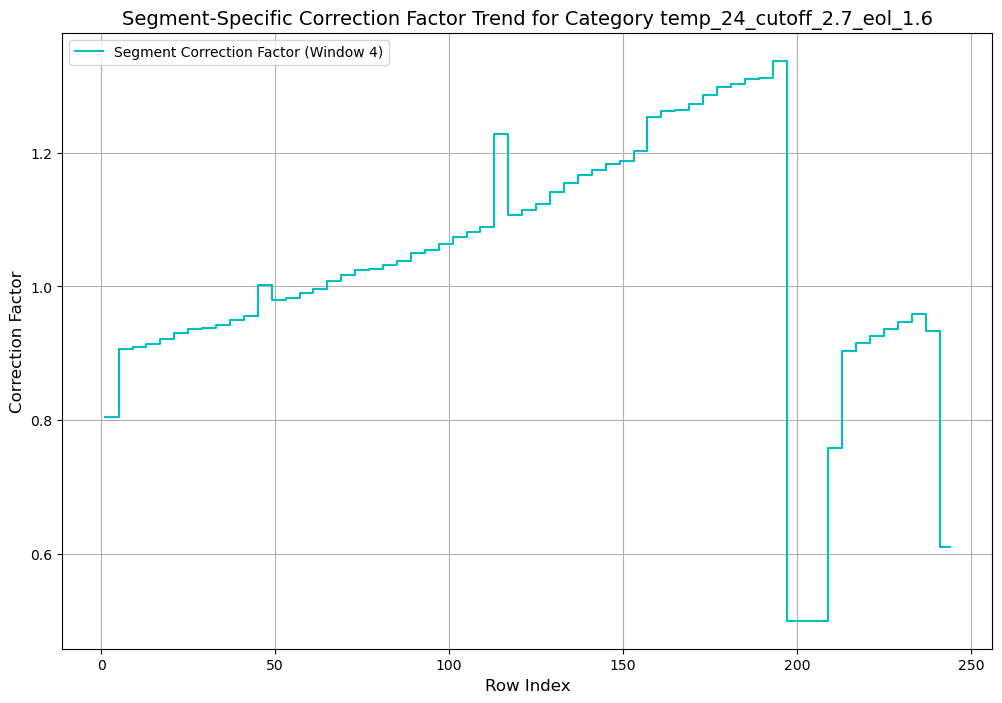


Processing category with conditions: (24, 2.5, 1.6)
Batteries: ['B0039']


[I 2025-03-25 10:27:57,315] A new study created in memory with name: no-name-9be4e266-05ea-42dd-81c2-ca10da0af726
[I 2025-03-25 10:27:57,347] Trial 0 finished with value: 176461.04434918918 and parameters: {'window_size': 7}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:27:57,347] Trial 1 finished with value: 180430.83983089752 and parameters: {'window_size': 14}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:27:57,381] Trial 2 finished with value: 240128.56680153013 and parameters: {'window_size': 9}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:27:57,381] Trial 3 finished with value: 490869.30491199176 and parameters: {'window_size': 20}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:27:57,397] Trial 4 finished with value: 766953.8179903888 and parameters: {'window_size': 30}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:27:57,430] Trial 5 finished with value: 60996.12184145834 and param

Cycling data saved to: battery_data\NASA_cycle_dataset_B0039.csv
Capacity data saved to: battery_data\capacity_soh_B0039.csv
Macro aging data saved to: battery_data\macro_aging_B0039.csv
Category data shape: (47, 10)


[I 2025-03-25 10:27:57,464] Trial 9 finished with value: 704189.0054807428 and parameters: {'window_size': 27}. Best is trial 5 with value: 60996.12184145834.
[I 2025-03-25 10:27:57,481] Trial 10 finished with value: 941137.9538680429 and parameters: {'window_size': 47}. Best is trial 5 with value: 60996.12184145834.
[I 2025-03-25 10:27:57,514] Trial 11 finished with value: 60996.12184145834 and parameters: {'window_size': 4}. Best is trial 5 with value: 60996.12184145834.
[I 2025-03-25 10:27:57,568] Trial 12 finished with value: 57879.155997385154 and parameters: {'window_size': 3}. Best is trial 12 with value: 57879.155997385154.
[I 2025-03-25 10:27:57,597] Trial 13 finished with value: 57879.155997385154 and parameters: {'window_size': 3}. Best is trial 12 with value: 57879.155997385154.
[I 2025-03-25 10:27:57,612] Trial 14 finished with value: 67932.6567627791 and parameters: {'window_size': 12}. Best is trial 12 with value: 57879.155997385154.
[I 2025-03-25 10:27:57,630] Trial 15 


Optimal Window Size for Condition (24, 2.5, 1.6): 3
Best MSE: 57879.1560
Category corrected SOH data saved to: battery_data\category_temp_24_cutoff_2.5_eol_1.6_mhe_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.5, 1.6) (Window Size: 3):
Segment 1 (Rows 1-3): k = 0.5000
Segment 2 (Rows 4-6): k = 0.5000
Segment 3 (Rows 7-9): k = 0.5000
Segment 4 (Rows 10-12): k = 0.5000
Segment 5 (Rows 13-15): k = 1.2393
Segment 6 (Rows 16-18): k = 1.2558
Segment 7 (Rows 19-21): k = 1.2659
Segment 8 (Rows 22-24): k = 1.2750
Segment 9 (Rows 25-27): k = 1.2856
Segment 10 (Rows 28-30): k = 1.2935
Segment 11 (Rows 31-33): k = 1.3035
Segment 12 (Rows 34-36): k = 1.3120
Segment 13 (Rows 37-39): k = 1.3205
Segment 14 (Rows 40-42): k = 1.2566
Segment 15 (Rows 43-45): k = 1.2498
Segment 16 (Rows 46-47): k = 1.0283


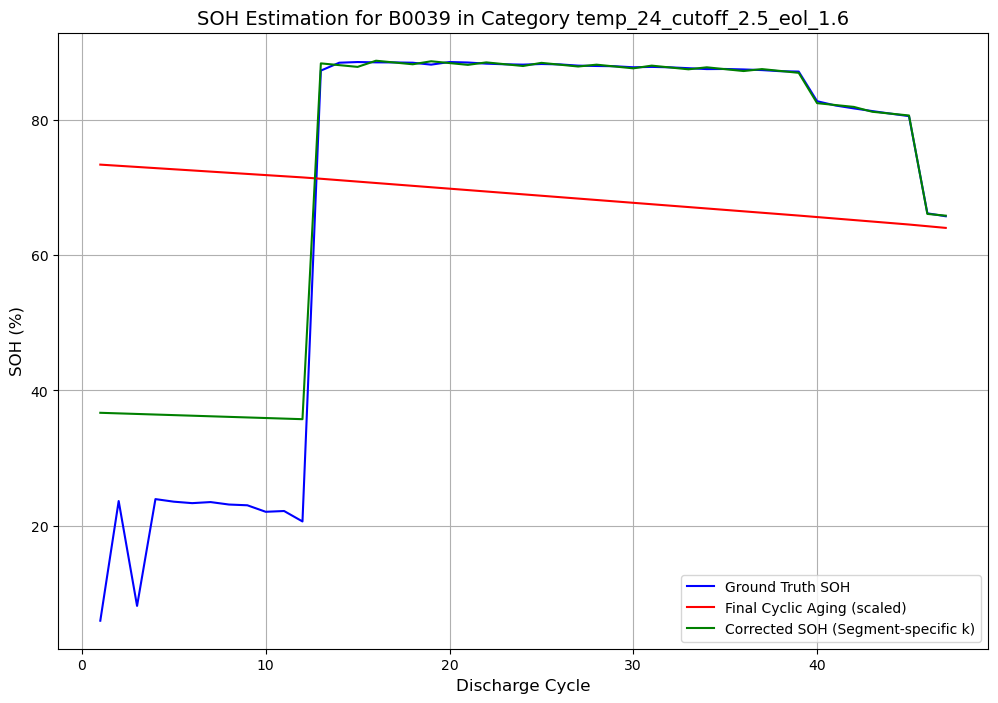


Processing category with conditions: (4, 2.0, 1.4)
Batteries: ['B0041', 'B0045', 'B0049', 'B0053']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0041.csv
Capacity data saved to: battery_data\capacity_soh_B0041.csv
Macro aging data saved to: battery_data\macro_aging_B0041.csv
Cycling data saved to: battery_data\NASA_cycle_dataset_B0045.csv
Capacity data saved to: battery_data\capacity_soh_B0045.csv
Macro aging data saved to: battery_data\macro_aging_B0045.csv


FileNotFoundError: [Errno 2] No such file or directory: 'battery_data\\B0049.mat'

In [24]:
with open("battery_params.json", 'r') as json_file:
    battery_params = json.load(json_file)
dataset_folder = 'battery_data'
results = process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials=50)

In [25]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import optuna
import os
from collections import defaultdict

# Objective function for Optuna to optimize MHE window size per category
def mhe_category_objective(trial, category_df):
    num_cycles = len(category_df)
    window_size = trial.suggest_int('window_size', 3, num_cycles)
    
    # Scale Final_cyclic_aging for the category
    scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
    category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
    
    # Apply local correction with suggested window size
    segment_starts = list(range(0, num_cycles, window_size))
    corrected_soh = []
    
    for start in segment_starts:
        end = min(start + window_size, num_cycles)
        segment_df = category_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        ground_truth_segment = segment_df['ground_truth_soh'].values
        
        def segment_cost(k):
            return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
        
        result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
        k_opt = result.x[0]
        corrected_soh.extend(k_opt * predicted_soh_segment)
    
    # Calculate MSE for the category
    mse = np.mean((np.array(corrected_soh) - category_df['ground_truth_soh'])**2)
    
    # Enforce MSE between 9 and 25 %² (RMSE 3% to 5%)
    if mse < 9 or mse > 25:
        penalty = abs(mse - 17)
        return mse + penalty * 1000
    
    return mse

# EKF implementation for smoothing
def ekf_smooth(segment_soh, Q, R):
    n = len(segment_soh)
    if n == 0:
        return segment_soh
    
    # State transition model: x_k = x_{k-1} + w_k (simple persistence model)
    # Measurement model: z_k = x_k + v_k
    x = segment_soh[0]  # Initial state estimate
    P = 1.0  # Initial covariance
    
    smoothed_soh = []
    for z in segment_soh:
        # Prediction step
        x_pred = x  # State prediction (no dynamics, just persistence)
        P_pred = P + Q  # Covariance prediction
        
        # Update step
        K = P_pred / (P_pred + R)  # Kalman gain
        x = x_pred + K * (z - x_pred)  # State update
        P = (1 - K) * P_pred  # Covariance update
        
        smoothed_soh.append(x)
    
    return np.array(smoothed_soh)

# Objective function for Optuna to optimize EKF parameters (Q, R) per segment
def ekf_objective(trial, segment_soh, ground_truth_segment):
    Q = trial.suggest_float('Q', 1e-6, 1e-2, log=True)  # Process noise
    R = trial.suggest_float('R', 1e-4, 1e-1, log=True)  # Measurement noise
    
    smoothed_soh = ekf_smooth(segment_soh, Q, R)
    mse = np.mean((smoothed_soh - ground_truth_segment)**2)
    return mse

# Process all batteries by test condition categories with MHE and EKF
def process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials_mhe=50, n_trials_ekf=20):
    # Load battery parameters
    with open("battery_params.json", 'r') as json_file:
        params = json.load(json_file)
    
    # Categorize batteries by test conditions
    categories = defaultdict(list)
    for battery_name, param in params.items():
        key = (param['ambient_temp_celsius'], param['cutoff_voltage'], param['eol_capacity'])
        categories[key].append(battery_name)
    
    # Process each category
    all_results = {}
    
    for test_condition, battery_names in categories.items():
        print(f"\nProcessing category with conditions: {test_condition}")
        print(f"Batteries: {battery_names}")
        
        category_dfs = []
        for battery_name in battery_names:
            macro_df = process_battery(dataset_folder, battery_name, params)
            category_dfs.append(macro_df)
        
        # Combine data for this category
        category_df = pd.concat(category_dfs, ignore_index=True)
        print(f"Category data shape: {category_df.shape}")
        
        # Optimize window size for this category with MHE
        study_mhe = optuna.create_study(direction='minimize')
        study_mhe.optimize(lambda trial: mhe_category_objective(trial, category_df.copy()), n_trials=n_trials_mhe)
        
        best_window_size = study_mhe.best_params['window_size']
        best_mhe_mse = study_mhe.best_value
        
        print(f"\nOptimal Window Size for Condition {test_condition}: {best_window_size}")
        print(f"Best MHE MSE: {best_mhe_mse:.4f}")
        
        # Apply MHE correction with optimized window size
        scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
        category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
        num_cycles = len(category_df)
        segment_starts = list(range(0, num_cycles, best_window_size))
        corrected_soh = []
        segment_correction_factors = []
        
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = category_df.iloc[start:end]
            predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
            ground_truth_segment = segment_df['ground_truth_soh'].values
            
            # Optimize k for this segment
            def segment_cost(k):
                return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
            
            result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
            k_opt = result.x[0]
            segment_correction_factors.extend([k_opt] * len(segment_df))
            corrected_soh.extend(k_opt * predicted_soh_segment)
        
        category_df['Local_Corrected_SOH'] = corrected_soh
        category_df['Segment_Correction_Factor'] = segment_correction_factors
        
        # Apply EKF smoothing per segment with Optuna optimization
        smoothed_soh = []
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = category_df.iloc[start:end]
            segment_soh = segment_df['Local_Corrected_SOH'].values
            ground_truth_segment = segment_df['ground_truth_soh'].values
            
            # Optimize EKF parameters
            study_ekf = optuna.create_study(direction='minimize')
            study_ekf.optimize(lambda trial: ekf_objective(trial, segment_soh, ground_truth_segment), n_trials=n_trials_ekf)
            
            best_Q = study_ekf.best_params['Q']
            best_R = study_ekf.best_params['R']
            
            # Apply EKF with best parameters
            smoothed_segment = ekf_smooth(segment_soh, best_Q, best_R)
            smoothed_soh.extend(smoothed_segment)
        
        category_df['Smoothed_SOH'] = smoothed_soh
        
        # Calculate MSE and RMSE for comparisons
        mse_ground_truth = np.mean((category_df['Smoothed_SOH'] - category_df['ground_truth_soh'])**2)
        rmse_ground_truth = np.sqrt(mse_ground_truth)
        mse_final_cyclic = np.mean((category_df['Smoothed_SOH'] - category_df['Final_cyclic_aging_scaled'])**2)
        rmse_final_cyclic = np.sqrt(mse_final_cyclic)
        
        # Save results for this category
        condition_str = f"temp_{test_condition[0]}_cutoff_{test_condition[1]}_eol_{test_condition[2]}"
        output_file = os.path.join(dataset_folder, f"category_{condition_str}_mhe_ekf_optuna.csv")
        category_df.to_csv(output_file, index=False)
        print(f"Category corrected and smoothed SOH data saved to: {output_file}")
        
        # Store results
        all_results[condition_str] = {
            'window_size': best_window_size,
            'mse_mhe': best_mhe_mse,
            'mse_ground_truth': mse_ground_truth,
            'rmse_ground_truth': rmse_ground_truth,
            'mse_final_cyclic': mse_final_cyclic,
            'rmse_final_cyclic': rmse_final_cyclic,
            'df': category_df
        }
        
        # Print segment-specific correction factors and error metrics
        print(f"\nSegment-Specific Correction Factors for Condition {test_condition} (Window Size: {best_window_size}):")
        for i, start in enumerate(segment_starts):
            end = min(start + best_window_size, num_cycles)
            k_value = segment_correction_factors[start]
            print(f"Segment {i+1} (Rows {start+1}-{end}): k = {k_value:.4f}")
        
        print(f"\nError Metrics for Condition {test_condition}:")
        print(f"MSE (Smoothed vs Ground Truth): {mse_ground_truth:.4f}")
        print(f"RMSE (Smoothed vs Ground Truth): {rmse_ground_truth:.4f}")
        print(f"MSE (Smoothed vs Final Cyclic Aging): {mse_final_cyclic:.4f}")
        print(f"RMSE (Smoothed vs Final Cyclic Aging): {rmse_final_cyclic:.4f}")
        
        # Plot for the first battery in the category
        sample_df = category_df[category_df['battery_id'] == battery_names[0]]
        plt.figure(figsize=(12, 8))
        plt.plot(sample_df['cycle'], sample_df['ground_truth_soh'], label='Ground Truth SOH', color='b')
        plt.plot(sample_df['cycle'], sample_df['Final_cyclic_aging_scaled'], label='Final Cyclic Aging (scaled)', color='r')
        plt.plot(sample_df['cycle'], sample_df['Local_Corrected_SOH'], label='MHE Corrected SOH', color='g')
        plt.plot(sample_df['cycle'], sample_df['Smoothed_SOH'], label='EKF Smoothed SOH', color='m')
        plt.title(f'SOH Estimation for {battery_names[0]} in Category {condition_str}', fontsize=14)
        plt.xlabel('Discharge Cycle', fontsize=12)
        plt.ylabel('SOH (%)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot segment-specific correction factors
        plt.figure(figsize=(12, 8))
        plt.step(range(1, num_cycles + 1), category_df['Segment_Correction_Factor'], label=f'Segment Correction Factor (Window {best_window_size})', color='c', where='post')
        plt.title(f'Segment-Specific Correction Factor Trend for Category {condition_str}', fontsize=14)
        plt.xlabel('Row Index', fontsize=12)
        plt.ylabel('Correction Factor', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return all_results


Processing category with conditions: (24, 2.7, 1.4)
Batteries: ['B0005', 'B0028']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0005.csv
Capacity data saved to: battery_data\capacity_soh_B0005.csv
Macro aging data saved to: battery_data\macro_aging_B0005.csv


[I 2025-03-25 10:44:38,070] A new study created in memory with name: no-name-bf628297-099a-4b1d-95b2-e16f972902e0
[I 2025-03-25 10:44:38,092] Trial 0 finished with value: 13354.249961622658 and parameters: {'window_size': 160}. Best is trial 0 with value: 13354.249961622658.
[I 2025-03-25 10:44:38,130] Trial 1 finished with value: 13912.672056853431 and parameters: {'window_size': 31}. Best is trial 0 with value: 13354.249961622658.
[I 2025-03-25 10:44:38,146] Trial 2 finished with value: 13973.656571235872 and parameters: {'window_size': 171}. Best is trial 0 with value: 13354.249961622658.
[I 2025-03-25 10:44:38,166] Trial 3 finished with value: 13925.733850338027 and parameters: {'window_size': 40}. Best is trial 0 with value: 13354.249961622658.
[I 2025-03-25 10:44:38,179] Trial 4 finished with value: 12221.476695277432 and parameters: {'window_size': 96}. Best is trial 4 with value: 12221.476695277432.
[I 2025-03-25 10:44:38,197] Trial 5 finished with value: 12280.44067842725 and 

Cycling data saved to: battery_data\NASA_cycle_dataset_B0028.csv
Capacity data saved to: battery_data\capacity_soh_B0028.csv
Macro aging data saved to: battery_data\macro_aging_B0028.csv
Category data shape: (196, 10)


[I 2025-03-25 10:44:38,277] Trial 8 finished with value: 12294.545928840731 and parameters: {'window_size': 139}. Best is trial 6 with value: 12054.939729632455.
[I 2025-03-25 10:44:38,311] Trial 9 finished with value: 13205.099254609953 and parameters: {'window_size': 59}. Best is trial 6 with value: 12054.939729632455.
[I 2025-03-25 10:44:38,339] Trial 10 finished with value: 12132.348152239505 and parameters: {'window_size': 127}. Best is trial 6 with value: 12054.939729632455.
[I 2025-03-25 10:44:38,362] Trial 11 finished with value: 12125.945262907779 and parameters: {'window_size': 126}. Best is trial 6 with value: 12054.939729632455.
[I 2025-03-25 10:44:38,380] Trial 12 finished with value: 12143.289799141645 and parameters: {'window_size': 129}. Best is trial 6 with value: 12054.939729632455.
[I 2025-03-25 10:44:38,400] Trial 13 finished with value: 12319.139768709054 and parameters: {'window_size': 187}. Best is trial 6 with value: 12054.939729632455.
[I 2025-03-25 10:44:38,41


Optimal Window Size for Condition (24, 2.7, 1.4): 119
Best MHE MSE: 12054.2690


[I 2025-03-25 10:44:39,480] Trial 19 finished with value: 2.4730334457079546 and parameters: {'Q': 3.1161995118182554e-05, 'R': 0.00018151579363479456}. Best is trial 13 with value: 2.388700948585503.
[I 2025-03-25 10:44:39,492] A new study created in memory with name: no-name-1cc64263-66eb-44c0-8af2-579557e97b59
[I 2025-03-25 10:44:39,496] Trial 0 finished with value: 78.62671772516201 and parameters: {'Q': 1.4809295363045094e-05, 'R': 0.01047787395470672}. Best is trial 0 with value: 78.62671772516201.
[I 2025-03-25 10:44:39,498] Trial 1 finished with value: 18.079417680243303 and parameters: {'Q': 3.338342963411397e-05, 'R': 0.0004944540631094625}. Best is trial 1 with value: 18.079417680243303.
[I 2025-03-25 10:44:39,501] Trial 2 finished with value: 94.4165141748207 and parameters: {'Q': 1.854356744591476e-05, 'R': 0.027568366836821415}. Best is trial 1 with value: 18.079417680243303.
[I 2025-03-25 10:44:39,504] Trial 3 finished with value: 8.591206584731456 and parameters: {'Q': 

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.7_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.7, 1.4) (Window Size: 119):
Segment 1 (Rows 1-119): k = 1.0022
Segment 2 (Rows 120-196): k = 0.9892

Error Metrics for Condition (24, 2.7, 1.4):
MSE (Smoothed vs Ground Truth): 4.8254
RMSE (Smoothed vs Ground Truth): 2.1967
MSE (Smoothed vs Final Cyclic Aging): 0.5643
RMSE (Smoothed vs Final Cyclic Aging): 0.7512



Processing category with conditions: (24, 2.5, 1.4)
Batteries: ['B0006', 'B0018', 'B0027']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0006.csv
Capacity data saved to: battery_data\capacity_soh_B0006.csv
Macro aging data saved to: battery_data\macro_aging_B0006.csv
Cycling data saved to: battery_data\NASA_cycle_dataset_B0018.csv
Capacity data saved to: battery_data\capacity_soh_B0018.csv
Macro aging data saved to: battery_data\macro_aging_B0018.csv


[I 2025-03-25 10:45:08,857] A new study created in memory with name: no-name-f39e6427-48e0-4983-8f7f-d1995d539d9c
[I 2025-03-25 10:45:08,880] Trial 0 finished with value: 9902.56041117579 and parameters: {'window_size': 145}. Best is trial 0 with value: 9902.56041117579.
[I 2025-03-25 10:45:08,897] Trial 1 finished with value: 9557.570803878933 and parameters: {'window_size': 161}. Best is trial 1 with value: 9557.570803878933.
[I 2025-03-25 10:45:08,904] Trial 2 finished with value: 9.19115504386266 and parameters: {'window_size': 225}. Best is trial 2 with value: 9.19115504386266.
[I 2025-03-25 10:45:08,914] Trial 3 finished with value: 9116.525871472484 and parameters: {'window_size': 177}. Best is trial 2 with value: 9.19115504386266.
[I 2025-03-25 10:45:08,932] Trial 4 finished with value: 9222.16450694734 and parameters: {'window_size': 166}. Best is trial 2 with value: 9.19115504386266.
[I 2025-03-25 10:45:08,943] Trial 5 finished with value: 8931.665900773936 and parameters: {'

Cycling data saved to: battery_data\NASA_cycle_dataset_B0027.csv
Capacity data saved to: battery_data\capacity_soh_B0027.csv
Macro aging data saved to: battery_data\macro_aging_B0027.csv
Category data shape: (328, 10)


[I 2025-03-25 10:45:09,066] Trial 8 finished with value: 15778.151403993761 and parameters: {'window_size': 11}. Best is trial 7 with value: 9.136517038371915.
[I 2025-03-25 10:45:09,083] Trial 9 finished with value: 9875.298259709909 and parameters: {'window_size': 109}. Best is trial 7 with value: 9.136517038371915.
[I 2025-03-25 10:45:09,112] Trial 10 finished with value: 10.43158730950902 and parameters: {'window_size': 326}. Best is trial 7 with value: 9.136517038371915.
[I 2025-03-25 10:45:09,130] Trial 11 finished with value: 10.43471412308838 and parameters: {'window_size': 268}. Best is trial 7 with value: 9.136517038371915.
[I 2025-03-25 10:45:09,148] Trial 12 finished with value: 10.059978325644487 and parameters: {'window_size': 249}. Best is trial 7 with value: 9.136517038371915.
[I 2025-03-25 10:45:09,166] Trial 13 finished with value: 9.503525041378794 and parameters: {'window_size': 235}. Best is trial 7 with value: 9.136517038371915.
[I 2025-03-25 10:45:09,195] Trial 1


Optimal Window Size for Condition (24, 2.5, 1.4): 209
Best MHE MSE: 9.0927


[I 2025-03-25 10:45:10,127] Trial 18 finished with value: 12.74975779944892 and parameters: {'Q': 0.0007399394807074555, 'R': 0.001252202008900078}. Best is trial 16 with value: 11.432227349635102.
[I 2025-03-25 10:45:10,143] Trial 19 finished with value: 11.417738867575633 and parameters: {'Q': 0.004580541380301679, 'R': 0.00033644861848103943}. Best is trial 19 with value: 11.417738867575633.
[I 2025-03-25 10:45:10,145] A new study created in memory with name: no-name-e86b570c-944a-4f78-8bf6-b86ce16a2ad1
[I 2025-03-25 10:45:10,147] Trial 0 finished with value: 42.88888918701159 and parameters: {'Q': 5.677807707900116e-05, 'R': 0.015316886830095574}. Best is trial 0 with value: 42.88888918701159.
[I 2025-03-25 10:45:10,149] Trial 1 finished with value: 39.08545229877299 and parameters: {'Q': 0.00038358594134810925, 'R': 0.07880773535137452}. Best is trial 1 with value: 39.08545229877299.
[I 2025-03-25 10:45:10,149] Trial 2 finished with value: 18.171463714071507 and parameters: {'Q': 

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.5_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.5, 1.4) (Window Size: 209):
Segment 1 (Rows 1-209): k = 1.0127
Segment 2 (Rows 210-328): k = 0.9821

Error Metrics for Condition (24, 2.5, 1.4):
MSE (Smoothed vs Ground Truth): 9.0961
RMSE (Smoothed vs Ground Truth): 3.0160
MSE (Smoothed vs Final Cyclic Aging): 1.3866
RMSE (Smoothed vs Final Cyclic Aging): 1.1775


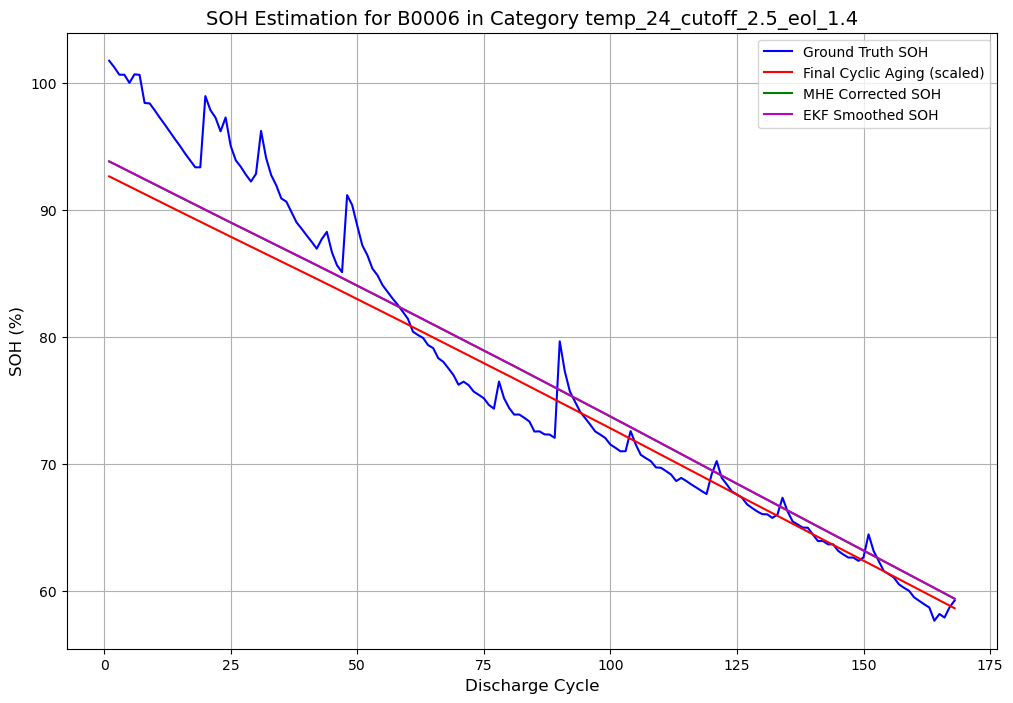


Processing category with conditions: (24, 2.2, 1.4)
Batteries: ['B0007', 'B0026']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0007.csv
Capacity data saved to: battery_data\capacity_soh_B0007.csv
Macro aging data saved to: battery_data\macro_aging_B0007.csv


[I 2025-03-25 10:45:30,540] A new study created in memory with name: no-name-bf993f73-6c9a-4f44-82ad-625f6b3c0195
[I 2025-03-25 10:45:30,554] Trial 0 finished with value: 14.92917994259141 and parameters: {'window_size': 47}. Best is trial 0 with value: 14.92917994259141.
[I 2025-03-25 10:45:30,563] Trial 1 finished with value: 17.460969454911965 and parameters: {'window_size': 133}. Best is trial 0 with value: 14.92917994259141.
[I 2025-03-25 10:45:30,580] Trial 2 finished with value: 14.687806544837652 and parameters: {'window_size': 46}. Best is trial 2 with value: 14.687806544837652.
[I 2025-03-25 10:45:30,597] Trial 3 finished with value: 13.783024493466884 and parameters: {'window_size': 174}. Best is trial 3 with value: 13.783024493466884.
[I 2025-03-25 10:45:30,658] Trial 4 finished with value: 14258.251244300753 and parameters: {'window_size': 12}. Best is trial 3 with value: 13.783024493466884.
[I 2025-03-25 10:45:30,668] Trial 5 finished with value: 11.097362250649896 and pa

Cycling data saved to: battery_data\NASA_cycle_dataset_B0026.csv
Capacity data saved to: battery_data\capacity_soh_B0026.csv
Macro aging data saved to: battery_data\macro_aging_B0026.csv
Category data shape: (196, 10)


[I 2025-03-25 10:45:30,720] Trial 8 finished with value: 11.222542361961073 and parameters: {'window_size': 171}. Best is trial 5 with value: 11.097362250649896.
[I 2025-03-25 10:45:30,751] Trial 9 finished with value: 10.14833109837757 and parameters: {'window_size': 26}. Best is trial 9 with value: 10.14833109837757.
[I 2025-03-25 10:45:30,764] Trial 10 finished with value: 17.797875192336704 and parameters: {'window_size': 101}. Best is trial 9 with value: 10.14833109837757.
[I 2025-03-25 10:45:30,783] Trial 11 finished with value: 17.691612300638276 and parameters: {'window_size': 126}. Best is trial 9 with value: 10.14833109837757.
[I 2025-03-25 10:45:30,797] Trial 12 finished with value: 17.35572009423769 and parameters: {'window_size': 191}. Best is trial 9 with value: 10.14833109837757.
[I 2025-03-25 10:45:30,827] Trial 13 finished with value: 12.849658643842536 and parameters: {'window_size': 88}. Best is trial 9 with value: 10.14833109837757.
[I 2025-03-25 10:45:30,849] Trial


Optimal Window Size for Condition (24, 2.2, 1.4): 168
Best MHE MSE: 10.0215


[I 2025-03-25 10:45:32,199] Trial 18 finished with value: 8.290322783509685 and parameters: {'Q': 0.0015134696138182123, 'R': 0.005497323400730485}. Best is trial 16 with value: 8.222933546570516.
[I 2025-03-25 10:45:32,214] Trial 19 finished with value: 8.418369456278901 and parameters: {'Q': 0.0025068608174832266, 'R': 0.0012732926352958095}. Best is trial 16 with value: 8.222933546570516.
[I 2025-03-25 10:45:32,215] A new study created in memory with name: no-name-96865a25-fc5c-4897-bbb1-afc35e115ce3
[I 2025-03-25 10:45:32,217] Trial 0 finished with value: 18.78015052518729 and parameters: {'Q': 0.00012309821011268689, 'R': 0.0560608258828402}. Best is trial 0 with value: 18.78015052518729.
[I 2025-03-25 10:45:32,217] Trial 1 finished with value: 18.81443726023494 and parameters: {'Q': 3.62869768209025e-05, 'R': 0.002635506210334018}. Best is trial 0 with value: 18.78015052518729.
[I 2025-03-25 10:45:32,226] Trial 2 finished with value: 18.79642447698322 and parameters: {'Q': 2.3718

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.2_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.2, 1.4) (Window Size: 168):
Segment 1 (Rows 1-168): k = 1.0106
Segment 2 (Rows 169-196): k = 0.9251

Error Metrics for Condition (24, 2.2, 1.4):
MSE (Smoothed vs Ground Truth): 9.7278
RMSE (Smoothed vs Ground Truth): 3.1189
MSE (Smoothed vs Final Cyclic Aging): 7.1333
RMSE (Smoothed vs Final Cyclic Aging): 2.6708


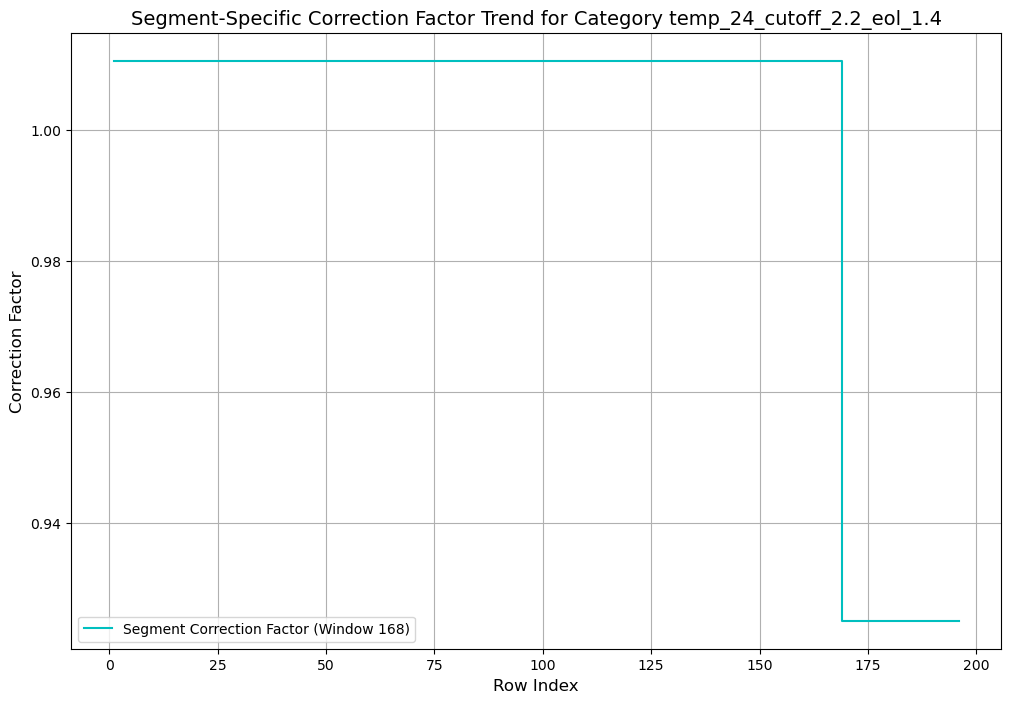


Processing category with conditions: (24, 2.0, 1.4)
Batteries: ['B0025']


[I 2025-03-25 10:45:36,234] A new study created in memory with name: no-name-6184afb3-c5e7-4945-97bc-53b88dd5c5e5
[I 2025-03-25 10:45:36,251] Trial 0 finished with value: 16747.954816498623 and parameters: {'window_size': 19}. Best is trial 0 with value: 16747.954816498623.
[I 2025-03-25 10:45:36,267] Trial 1 finished with value: 16830.870654609986 and parameters: {'window_size': 8}. Best is trial 0 with value: 16747.954816498623.
[I 2025-03-25 10:45:36,284] Trial 2 finished with value: 16614.499888598486 and parameters: {'window_size': 23}. Best is trial 2 with value: 16614.499888598486.
[I 2025-03-25 10:45:36,296] Trial 3 finished with value: 16699.50841528927 and parameters: {'window_size': 21}. Best is trial 2 with value: 16614.499888598486.
[I 2025-03-25 10:45:36,316] Trial 4 finished with value: 16921.50329916514 and parameters: {'window_size': 3}. Best is trial 2 with value: 16614.499888598486.
[I 2025-03-25 10:45:36,334] Trial 5 finished with value: 16838.73161403653 and parame

Cycling data saved to: battery_data\NASA_cycle_dataset_B0025.csv
Capacity data saved to: battery_data\capacity_soh_B0025.csv
Macro aging data saved to: battery_data\macro_aging_B0025.csv
Category data shape: (28, 10)


[I 2025-03-25 10:45:36,396] Trial 9 finished with value: 16812.506999196565 and parameters: {'window_size': 11}. Best is trial 2 with value: 16614.499888598486.
[I 2025-03-25 10:45:36,418] Trial 10 finished with value: 16593.35839696456 and parameters: {'window_size': 24}. Best is trial 10 with value: 16593.35839696456.
[I 2025-03-25 10:45:36,431] Trial 11 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 11 with value: 16460.772432039776.
[I 2025-03-25 10:45:36,444] Trial 12 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 11 with value: 16460.772432039776.
[I 2025-03-25 10:45:36,447] Trial 13 finished with value: 16464.796564314256 and parameters: {'window_size': 27}. Best is trial 11 with value: 16460.772432039776.
[I 2025-03-25 10:45:36,461] Trial 14 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 11 with value: 16460.772432039776.
[I 2025-03-25 10:45:36,494


Optimal Window Size for Condition (24, 2.0, 1.4): 28
Best MHE MSE: 16460.7724
Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.0_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.0, 1.4) (Window Size: 28):
Segment 1 (Rows 1-28): k = 0.9999

Error Metrics for Condition (24, 2.0, 1.4):
MSE (Smoothed vs Ground Truth): 0.5347
RMSE (Smoothed vs Ground Truth): 0.7312
MSE (Smoothed vs Final Cyclic Aging): 0.0081
RMSE (Smoothed vs Final Cyclic Aging): 0.0899


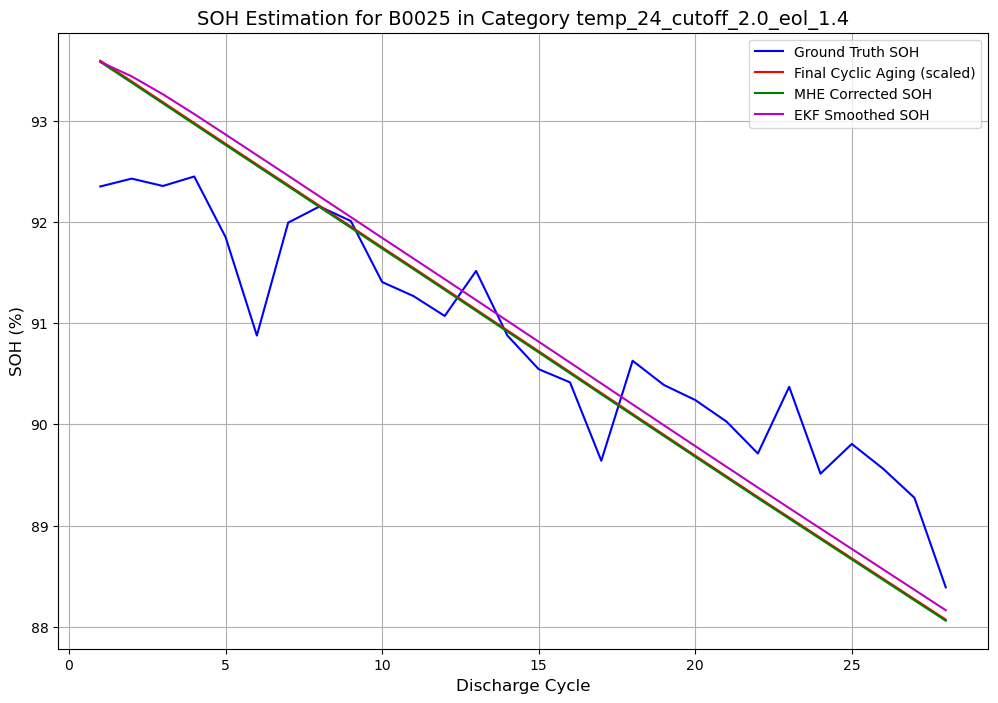

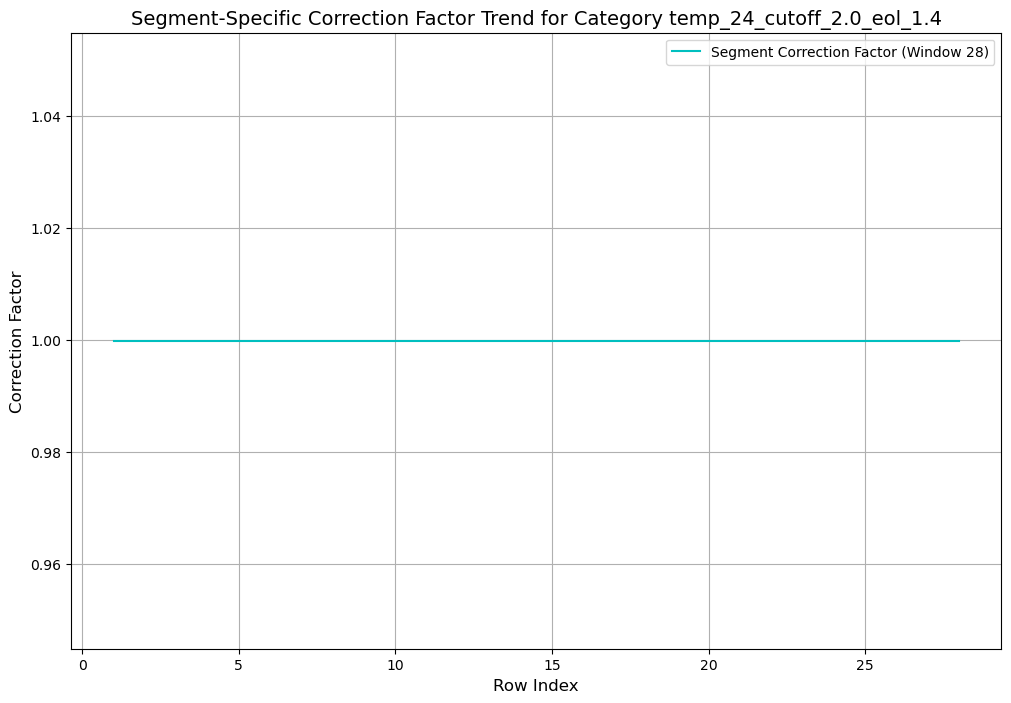


Processing category with conditions: (43, 2.0, 1.4)
Batteries: ['B0029']


[I 2025-03-25 10:45:40,966] A new study created in memory with name: no-name-428da738-07c7-4cd9-a55a-582a07be99e0
[I 2025-03-25 10:45:40,983] Trial 0 finished with value: 15706.846676770869 and parameters: {'window_size': 7}. Best is trial 0 with value: 15706.846676770869.
[I 2025-03-25 10:45:41,014] Trial 1 finished with value: 15862.594692335333 and parameters: {'window_size': 4}. Best is trial 0 with value: 15706.846676770869.
[I 2025-03-25 10:45:41,017] Trial 2 finished with value: 15448.116406216881 and parameters: {'window_size': 38}. Best is trial 2 with value: 15448.116406216881.
[I 2025-03-25 10:45:41,034] Trial 3 finished with value: 15495.8748441016 and parameters: {'window_size': 28}. Best is trial 2 with value: 15448.116406216881.
[I 2025-03-25 10:45:41,045] Trial 4 finished with value: 15465.614527856857 and parameters: {'window_size': 32}. Best is trial 2 with value: 15448.116406216881.
[I 2025-03-25 10:45:41,050] Trial 5 finished with value: 15470.553984897631 and param

Cycling data saved to: battery_data\NASA_cycle_dataset_B0029.csv
Capacity data saved to: battery_data\capacity_soh_B0029.csv
Macro aging data saved to: battery_data\macro_aging_B0029.csv
Category data shape: (40, 10)


[I 2025-03-25 10:45:41,126] Trial 11 finished with value: 15447.473141458448 and parameters: {'window_size': 40}. Best is trial 11 with value: 15447.473141458448.
[I 2025-03-25 10:45:41,145] Trial 12 finished with value: 15447.562413394991 and parameters: {'window_size': 39}. Best is trial 11 with value: 15447.473141458448.
[I 2025-03-25 10:45:41,165] Trial 13 finished with value: 15447.562413394991 and parameters: {'window_size': 39}. Best is trial 11 with value: 15447.473141458448.
[I 2025-03-25 10:45:41,179] Trial 14 finished with value: 15540.18072883144 and parameters: {'window_size': 25}. Best is trial 11 with value: 15447.473141458448.
[I 2025-03-25 10:45:41,200] Trial 15 finished with value: 15595.134279754142 and parameters: {'window_size': 17}. Best is trial 11 with value: 15447.473141458448.
[I 2025-03-25 10:45:41,230] Trial 16 finished with value: 15650.293248545588 and parameters: {'window_size': 13}. Best is trial 11 with value: 15447.473141458448.
[I 2025-03-25 10:45:41,


Optimal Window Size for Condition (43, 2.0, 1.4): 40
Best MHE MSE: 15447.4731
Category corrected and smoothed SOH data saved to: battery_data\category_temp_43_cutoff_2.0_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.0, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9998

Error Metrics for Condition (43, 2.0, 1.4):
MSE (Smoothed vs Ground Truth): 1.5152
RMSE (Smoothed vs Ground Truth): 1.2309
MSE (Smoothed vs Final Cyclic Aging): 0.0385
RMSE (Smoothed vs Final Cyclic Aging): 0.1963


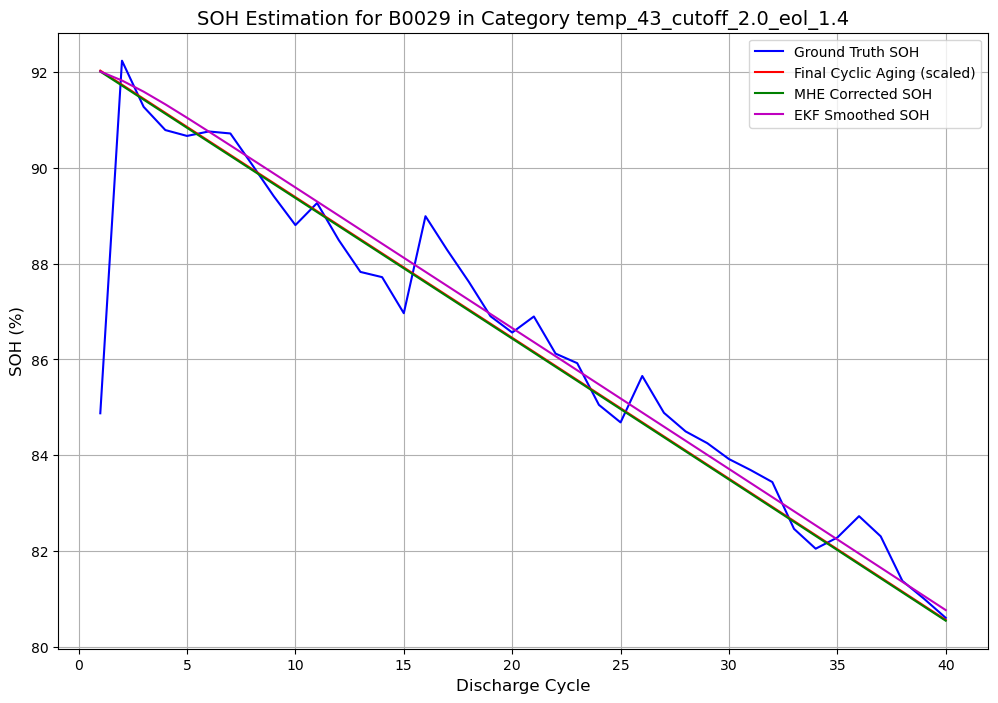

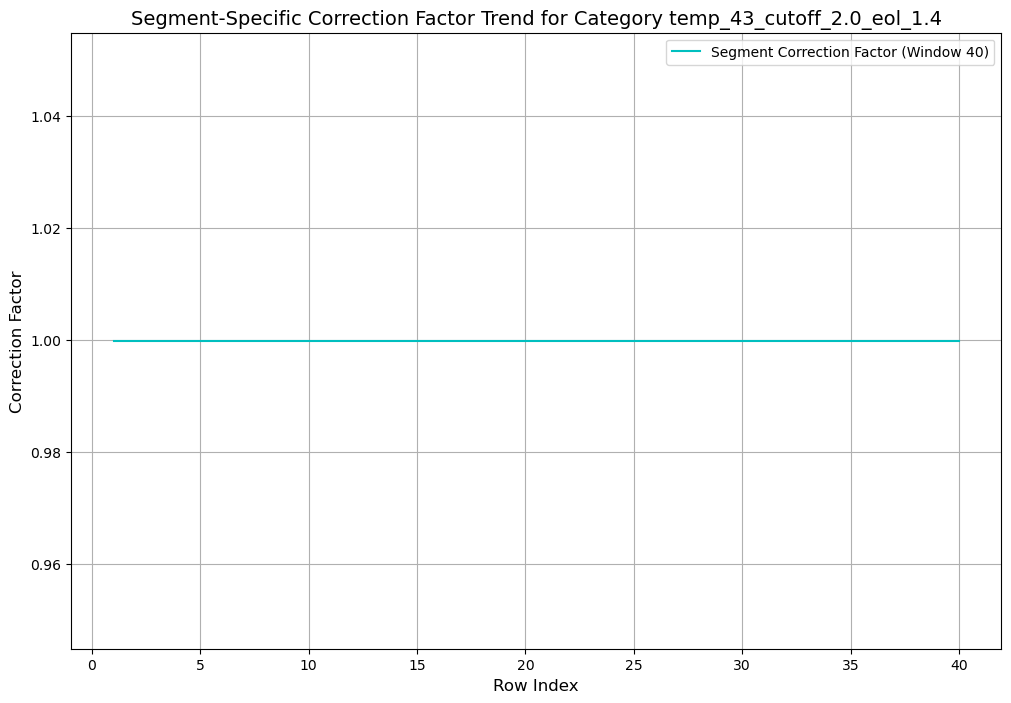


Processing category with conditions: (43, 2.2, 1.4)
Batteries: ['B0030']


[I 2025-03-25 10:45:45,410] A new study created in memory with name: no-name-f2c32f6c-2b59-405d-9688-0df3e6a90b90
[I 2025-03-25 10:45:45,425] Trial 0 finished with value: 15960.533799758721 and parameters: {'window_size': 15}. Best is trial 0 with value: 15960.533799758721.
[I 2025-03-25 10:45:45,441] Trial 1 finished with value: 15797.505651121939 and parameters: {'window_size': 25}. Best is trial 1 with value: 15797.505651121939.
[I 2025-03-25 10:45:45,470] Trial 2 finished with value: 15988.0630804122 and parameters: {'window_size': 4}. Best is trial 1 with value: 15797.505651121939.
[I 2025-03-25 10:45:45,481] Trial 3 finished with value: 15837.7555931504 and parameters: {'window_size': 17}. Best is trial 1 with value: 15797.505651121939.
[I 2025-03-25 10:45:45,495] Trial 4 finished with value: 15680.490041838808 and parameters: {'window_size': 37}. Best is trial 4 with value: 15680.490041838808.
[I 2025-03-25 10:45:45,513] Trial 5 finished with value: 15957.488930092259 and parame

Cycling data saved to: battery_data\NASA_cycle_dataset_B0030.csv
Capacity data saved to: battery_data\capacity_soh_B0030.csv
Macro aging data saved to: battery_data\macro_aging_B0030.csv
Category data shape: (40, 10)


[I 2025-03-25 10:45:45,597] Trial 11 finished with value: 15615.338092128215 and parameters: {'window_size': 40}. Best is trial 11 with value: 15615.338092128215.
[I 2025-03-25 10:45:45,614] Trial 12 finished with value: 15615.338092128215 and parameters: {'window_size': 40}. Best is trial 11 with value: 15615.338092128215.
[I 2025-03-25 10:45:45,631] Trial 13 finished with value: 15731.5913987474 and parameters: {'window_size': 33}. Best is trial 11 with value: 15615.338092128215.
[I 2025-03-25 10:45:45,648] Trial 14 finished with value: 15615.338092128215 and parameters: {'window_size': 40}. Best is trial 11 with value: 15615.338092128215.
[I 2025-03-25 10:45:45,666] Trial 15 finished with value: 15731.5913987474 and parameters: {'window_size': 33}. Best is trial 11 with value: 15615.338092128215.
[I 2025-03-25 10:45:45,695] Trial 16 finished with value: 15767.135316422882 and parameters: {'window_size': 20}. Best is trial 11 with value: 15615.338092128215.
[I 2025-03-25 10:45:45,714


Optimal Window Size for Condition (43, 2.2, 1.4): 40
Best MHE MSE: 15615.3381
Category corrected and smoothed SOH data saved to: battery_data\category_temp_43_cutoff_2.2_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.2, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9997

Error Metrics for Condition (43, 2.2, 1.4):
MSE (Smoothed vs Ground Truth): 1.3587
RMSE (Smoothed vs Ground Truth): 1.1656
MSE (Smoothed vs Final Cyclic Aging): 0.0135
RMSE (Smoothed vs Final Cyclic Aging): 0.1162


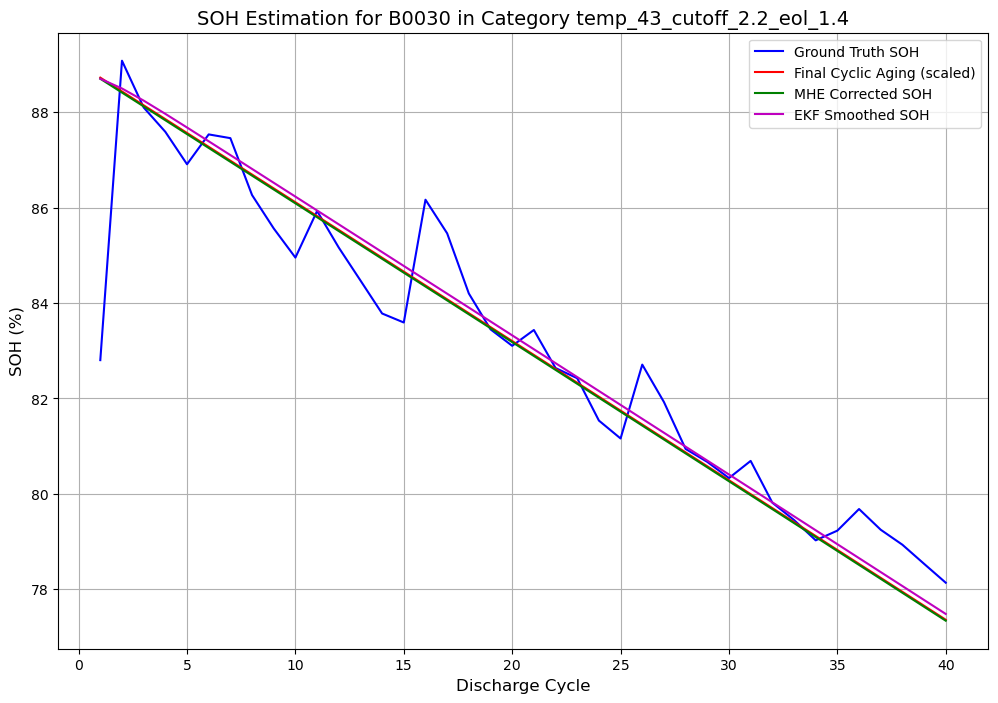

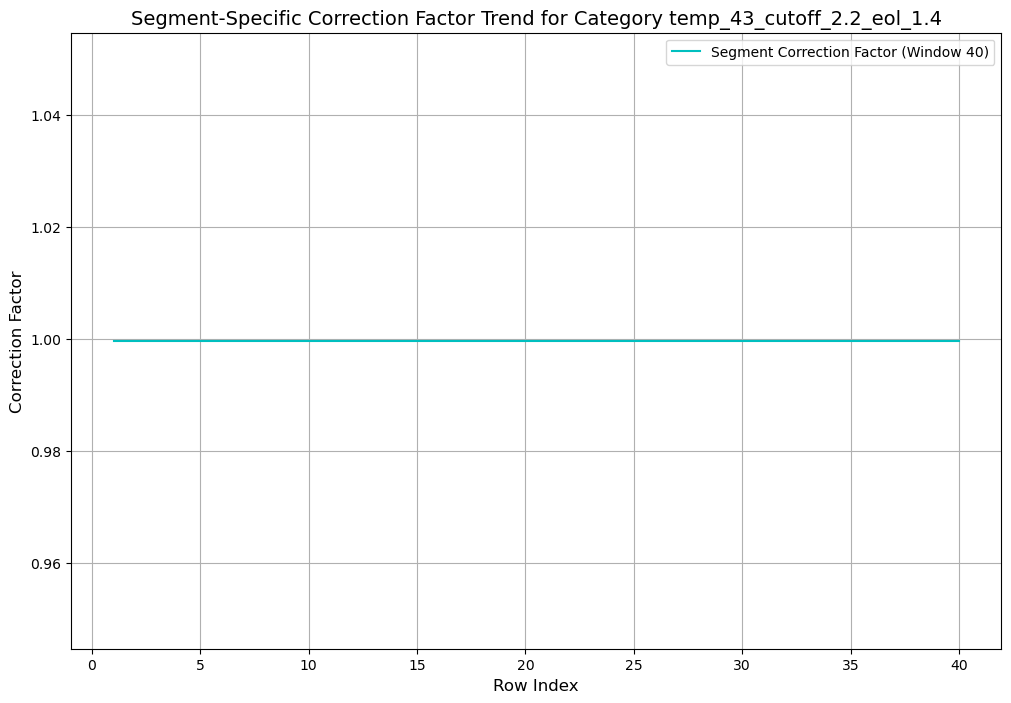


Processing category with conditions: (43, 2.5, 1.4)
Batteries: ['B0031']


[I 2025-03-25 10:45:50,114] A new study created in memory with name: no-name-2adf4065-f8b9-4584-a065-9f4c83f6168a
[I 2025-03-25 10:45:50,114] Trial 0 finished with value: 14932.269095781805 and parameters: {'window_size': 17}. Best is trial 0 with value: 14932.269095781805.
[I 2025-03-25 10:45:50,133] Trial 1 finished with value: 12768.601310998813 and parameters: {'window_size': 39}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:45:50,148] Trial 2 finished with value: 13602.285877821323 and parameters: {'window_size': 32}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:45:50,164] Trial 3 finished with value: 15070.932649508684 and parameters: {'window_size': 16}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:45:50,181] Trial 4 finished with value: 15324.562053434849 and parameters: {'window_size': 8}. Best is trial 1 with value: 12768.601310998813.
[I 2025-03-25 10:45:50,197] Trial 5 finished with value: 13047.668180691524 and pa

Cycling data saved to: battery_data\NASA_cycle_dataset_B0031.csv
Capacity data saved to: battery_data\capacity_soh_B0031.csv
Macro aging data saved to: battery_data\macro_aging_B0031.csv
Category data shape: (40, 10)


[I 2025-03-25 10:45:50,281] Trial 11 finished with value: 12649.957369766193 and parameters: {'window_size': 40}. Best is trial 10 with value: 12649.957369766193.
[I 2025-03-25 10:45:50,297] Trial 12 finished with value: 13981.929427427902 and parameters: {'window_size': 28}. Best is trial 10 with value: 12649.957369766193.
[I 2025-03-25 10:45:50,320] Trial 13 finished with value: 12768.601310998813 and parameters: {'window_size': 39}. Best is trial 10 with value: 12649.957369766193.
[I 2025-03-25 10:45:50,335] Trial 14 finished with value: 13557.861828646908 and parameters: {'window_size': 33}. Best is trial 10 with value: 12649.957369766193.
[I 2025-03-25 10:45:50,350] Trial 15 finished with value: 14325.7548355016 and parameters: {'window_size': 23}. Best is trial 10 with value: 12649.957369766193.
[I 2025-03-25 10:45:50,363] Trial 16 finished with value: 12649.957369766193 and parameters: {'window_size': 40}. Best is trial 10 with value: 12649.957369766193.
[I 2025-03-25 10:45:50,3


Optimal Window Size for Condition (43, 2.5, 1.4): 40
Best MHE MSE: 12649.9574
Category corrected and smoothed SOH data saved to: battery_data\category_temp_43_cutoff_2.5_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.5, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9992

Error Metrics for Condition (43, 2.5, 1.4):
MSE (Smoothed vs Ground Truth): 4.1856
RMSE (Smoothed vs Ground Truth): 2.0459
MSE (Smoothed vs Final Cyclic Aging): 0.2166
RMSE (Smoothed vs Final Cyclic Aging): 0.4654


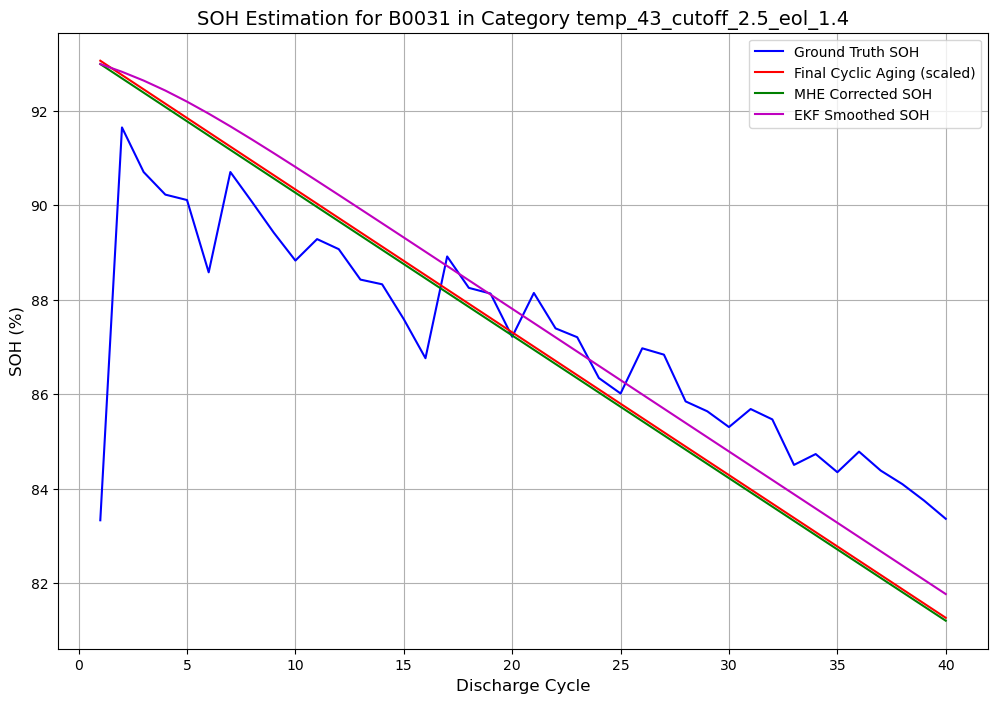

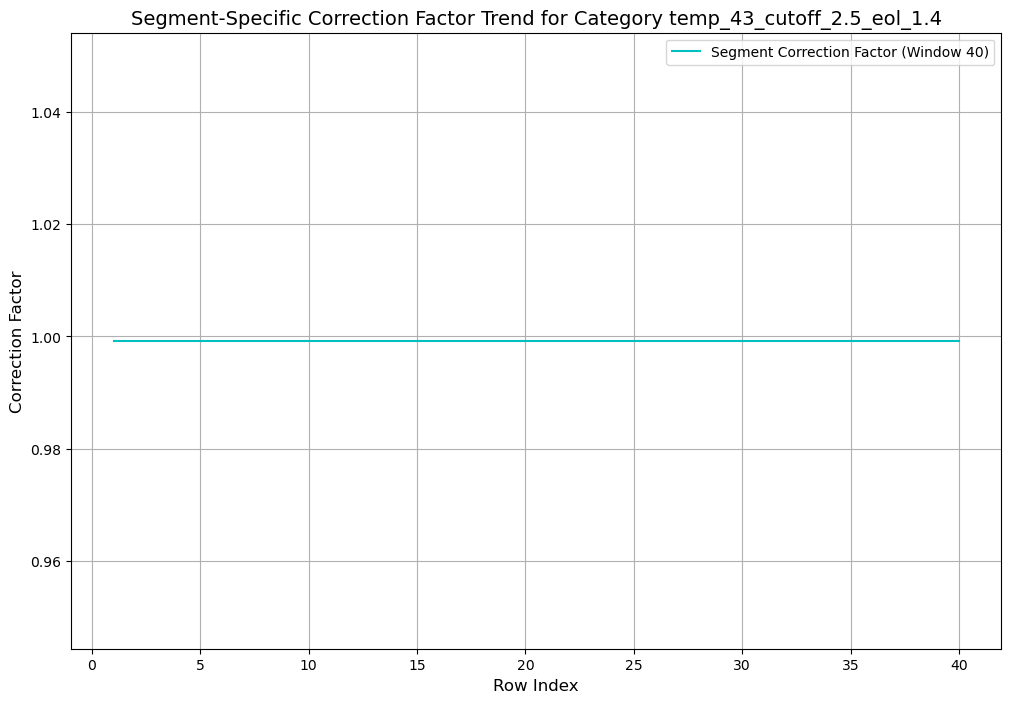


Processing category with conditions: (43, 2.7, 1.4)
Batteries: ['B0032']


[I 2025-03-25 10:45:54,964] A new study created in memory with name: no-name-a87ba0fd-c9b7-4fbb-9676-48ed9bfcceb4
[I 2025-03-25 10:45:54,980] Trial 0 finished with value: 14972.223785845666 and parameters: {'window_size': 9}. Best is trial 0 with value: 14972.223785845666.
[I 2025-03-25 10:45:54,997] Trial 1 finished with value: 14892.531539371874 and parameters: {'window_size': 22}. Best is trial 1 with value: 14892.531539371874.
[I 2025-03-25 10:45:55,017] Trial 2 finished with value: 15022.13248038778 and parameters: {'window_size': 8}. Best is trial 1 with value: 14892.531539371874.
[I 2025-03-25 10:45:55,027] Trial 3 finished with value: 14890.38067536103 and parameters: {'window_size': 29}. Best is trial 3 with value: 14890.38067536103.
[I 2025-03-25 10:45:55,034] Trial 4 finished with value: 14858.203125171782 and parameters: {'window_size': 32}. Best is trial 4 with value: 14858.203125171782.
[I 2025-03-25 10:45:55,049] Trial 5 finished with value: 14876.202619041731 and parame

Cycling data saved to: battery_data\NASA_cycle_dataset_B0032.csv
Capacity data saved to: battery_data\capacity_soh_B0032.csv
Macro aging data saved to: battery_data\macro_aging_B0032.csv
Category data shape: (40, 10)


[I 2025-03-25 10:45:55,123] Trial 9 finished with value: 15365.597666687154 and parameters: {'window_size': 3}. Best is trial 4 with value: 14858.203125171782.
[I 2025-03-25 10:45:55,135] Trial 10 finished with value: 14803.69126464544 and parameters: {'window_size': 39}. Best is trial 10 with value: 14803.69126464544.
[I 2025-03-25 10:45:55,147] Trial 11 finished with value: 14803.39693995835 and parameters: {'window_size': 40}. Best is trial 11 with value: 14803.39693995835.
[I 2025-03-25 10:45:55,157] Trial 12 finished with value: 14803.39693995835 and parameters: {'window_size': 40}. Best is trial 11 with value: 14803.39693995835.
[I 2025-03-25 10:45:55,168] Trial 13 finished with value: 14803.39693995835 and parameters: {'window_size': 40}. Best is trial 11 with value: 14803.39693995835.
[I 2025-03-25 10:45:55,182] Trial 14 finished with value: 14875.06310804192 and parameters: {'window_size': 28}. Best is trial 11 with value: 14803.39693995835.
[I 2025-03-25 10:45:55,195] Trial 1


Optimal Window Size for Condition (43, 2.7, 1.4): 40
Best MHE MSE: 14803.3969
Category corrected and smoothed SOH data saved to: battery_data\category_temp_43_cutoff_2.7_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.7, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9998

Error Metrics for Condition (43, 2.7, 1.4):
MSE (Smoothed vs Ground Truth): 2.1523
RMSE (Smoothed vs Ground Truth): 1.4671
MSE (Smoothed vs Final Cyclic Aging): 0.0377
RMSE (Smoothed vs Final Cyclic Aging): 0.1941


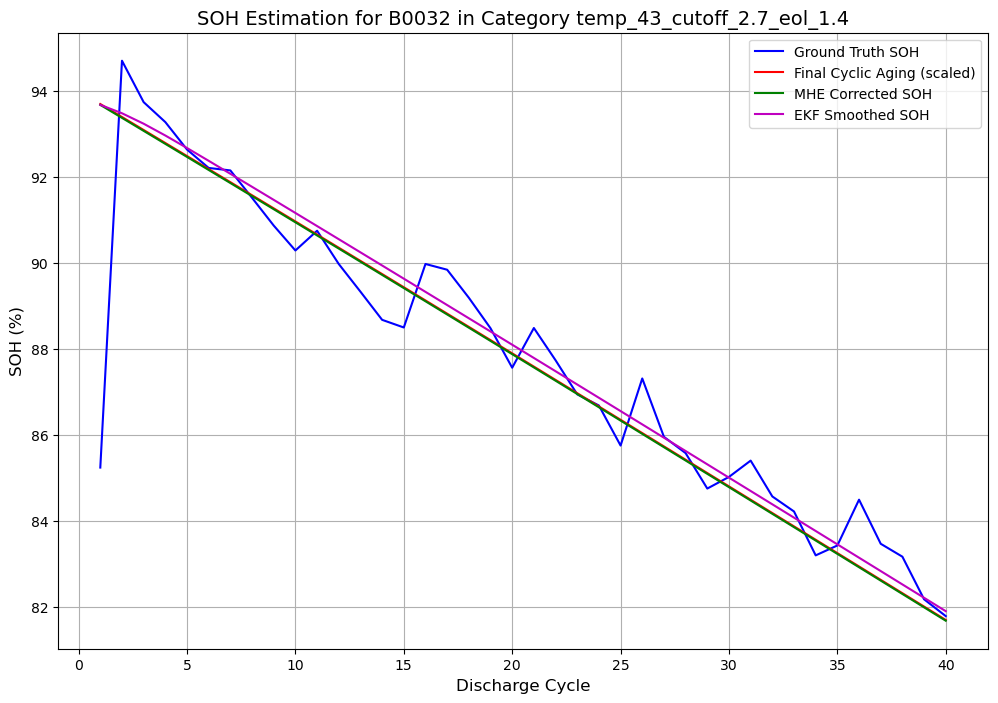

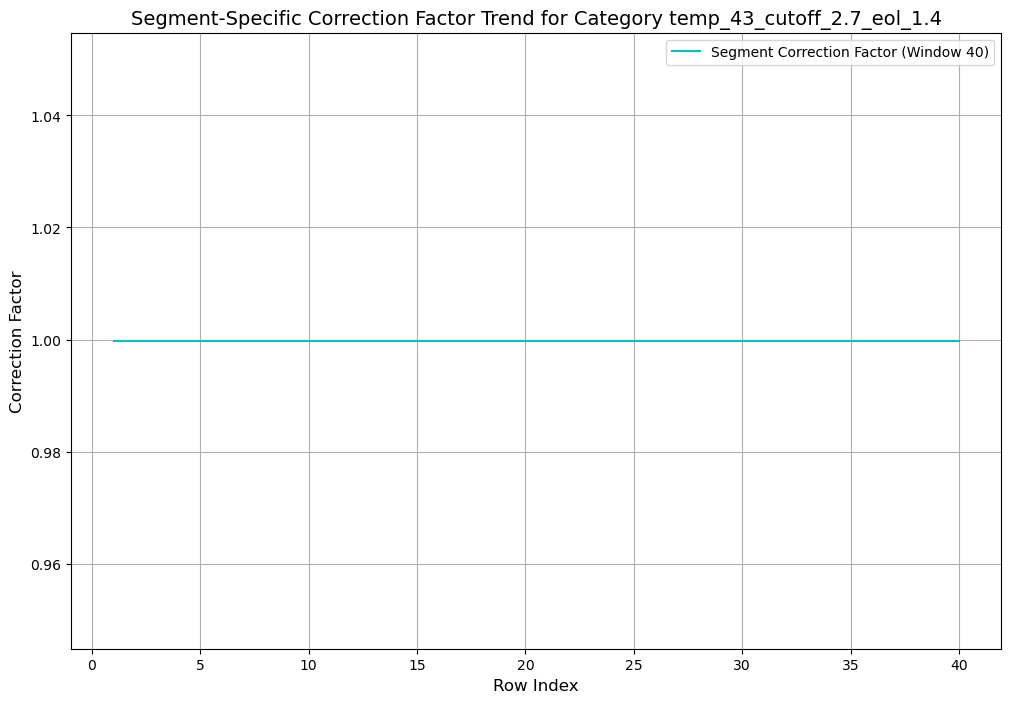


Processing category with conditions: (24, 2.0, 1.6)
Batteries: ['B0033']


[I 2025-03-25 10:46:08,443] A new study created in memory with name: no-name-ffb62c9b-b0df-45bf-87d3-38b4b9fd4f5f
[I 2025-03-25 10:46:08,458] Trial 0 finished with value: 161830.65017762408 and parameters: {'window_size': 84}. Best is trial 0 with value: 161830.65017762408.
[I 2025-03-25 10:46:08,473] Trial 1 finished with value: 141241.072269585 and parameters: {'window_size': 74}. Best is trial 1 with value: 141241.072269585.
[I 2025-03-25 10:46:08,481] Trial 2 finished with value: 159303.95572794208 and parameters: {'window_size': 83}. Best is trial 1 with value: 141241.072269585.
[I 2025-03-25 10:46:08,484] Trial 3 finished with value: 202593.421330379 and parameters: {'window_size': 189}. Best is trial 1 with value: 141241.072269585.
[I 2025-03-25 10:46:08,501] Trial 4 finished with value: 192665.7414081194 and parameters: {'window_size': 104}. Best is trial 1 with value: 141241.072269585.
[I 2025-03-25 10:46:08,513] Trial 5 finished with value: 145025.7086766924 and parameters: {

Cycling data saved to: battery_data\NASA_cycle_dataset_B0033.csv
Capacity data saved to: battery_data\capacity_soh_B0033.csv
Macro aging data saved to: battery_data\macro_aging_B0033.csv
Category data shape: (197, 10)


[I 2025-03-25 10:46:08,550] Trial 9 finished with value: 196680.2681976314 and parameters: {'window_size': 117}. Best is trial 1 with value: 141241.072269585.
[I 2025-03-25 10:46:08,581] Trial 10 finished with value: 117799.34717935181 and parameters: {'window_size': 20}. Best is trial 10 with value: 117799.34717935181.
[I 2025-03-25 10:46:08,629] Trial 11 finished with value: 107246.49681246272 and parameters: {'window_size': 16}. Best is trial 11 with value: 107246.49681246272.
[I 2025-03-25 10:46:08,729] Trial 12 finished with value: 37445.384344614875 and parameters: {'window_size': 5}. Best is trial 12 with value: 37445.384344614875.
[I 2025-03-25 10:46:08,815] Trial 13 finished with value: 32471.459708251972 and parameters: {'window_size': 6}. Best is trial 13 with value: 32471.459708251972.
[I 2025-03-25 10:46:08,835] Trial 14 finished with value: 151648.7301551364 and parameters: {'window_size': 43}. Best is trial 13 with value: 32471.459708251972.
[I 2025-03-25 10:46:08,983] T


Optimal Window Size for Condition (24, 2.0, 1.6): 3
Best MHE MSE: 8213.3258


[I 2025-03-25 10:46:11,067] Trial 9 finished with value: 704.5246507424246 and parameters: {'Q': 2.141083316068062e-05, 'R': 0.00015653216777804002}. Best is trial 0 with value: 704.443660608876.
[I 2025-03-25 10:46:11,082] Trial 10 finished with value: 704.449641313653 and parameters: {'Q': 1.520730172866428e-06, 'R': 0.0010483215859529423}. Best is trial 0 with value: 704.443660608876.
[I 2025-03-25 10:46:11,093] Trial 11 finished with value: 704.4424477013281 and parameters: {'Q': 0.0001877891659676788, 'R': 0.0992393765584774}. Best is trial 11 with value: 704.4424477013281.
[I 2025-03-25 10:46:11,106] Trial 12 finished with value: 704.4433362443411 and parameters: {'Q': 0.0002545583884265314, 'R': 0.09471501215769139}. Best is trial 11 with value: 704.4424477013281.
[I 2025-03-25 10:46:11,117] Trial 13 finished with value: 704.4584417495092 and parameters: {'Q': 0.000508599566617323, 'R': 0.027707204560344065}. Best is trial 11 with value: 704.4424477013281.
[I 2025-03-25 10:46:11

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.0_eol_1.6_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.0, 1.6) (Window Size: 3):
Segment 1 (Rows 1-3): k = 0.5000
Segment 2 (Rows 4-6): k = 0.7053
Segment 3 (Rows 7-9): k = 0.8532
Segment 4 (Rows 10-12): k = 0.8952
Segment 5 (Rows 13-15): k = 0.8805
Segment 6 (Rows 16-18): k = 0.9119
Segment 7 (Rows 19-21): k = 0.9028
Segment 8 (Rows 22-24): k = 0.9583
Segment 9 (Rows 25-27): k = 0.9433
Segment 10 (Rows 28-30): k = 0.9481
Segment 11 (Rows 31-33): k = 0.9422
Segment 12 (Rows 34-36): k = 0.9408
Segment 13 (Rows 37-39): k = 0.9514
Segment 14 (Rows 40-42): k = 0.9479
Segment 15 (Rows 43-45): k = 0.9787
Segment 16 (Rows 46-48): k = 1.0468
Segment 17 (Rows 49-51): k = 0.9879
Segment 18 (Rows 52-54): k = 0.9890
Segment 19 (Rows 55-57): k = 0.9897
Segment 20 (Rows 58-60): k = 0.9788
Segment 21 (Rows 61-63): k = 0.9814
Segment 22 (Rows 64-66): k = 0.9741
Segment 23 (Rows 67-

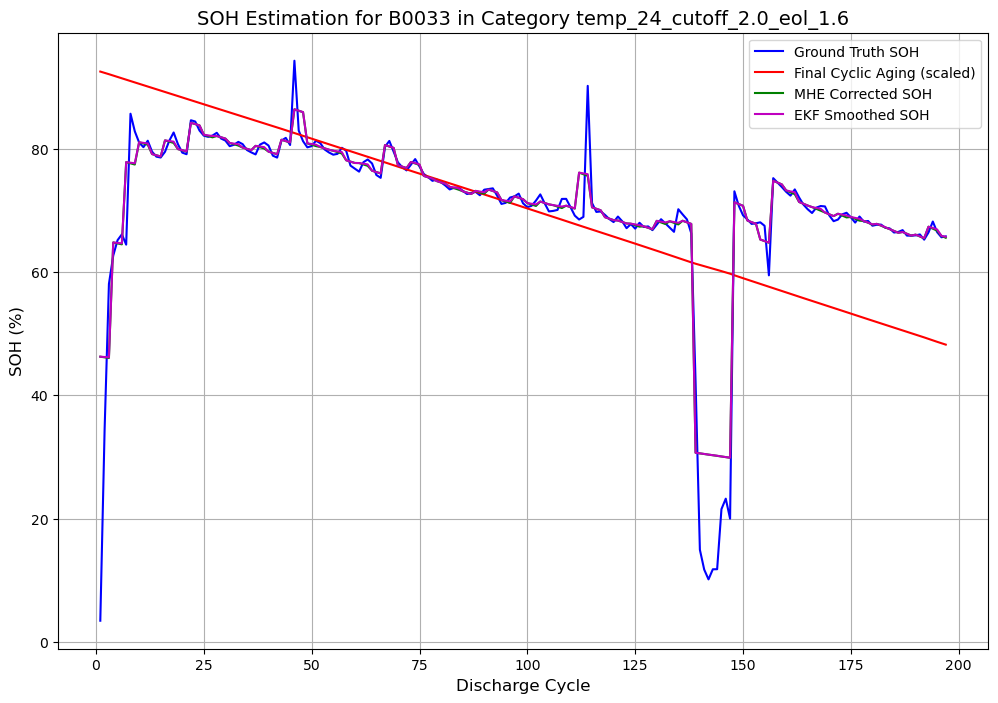

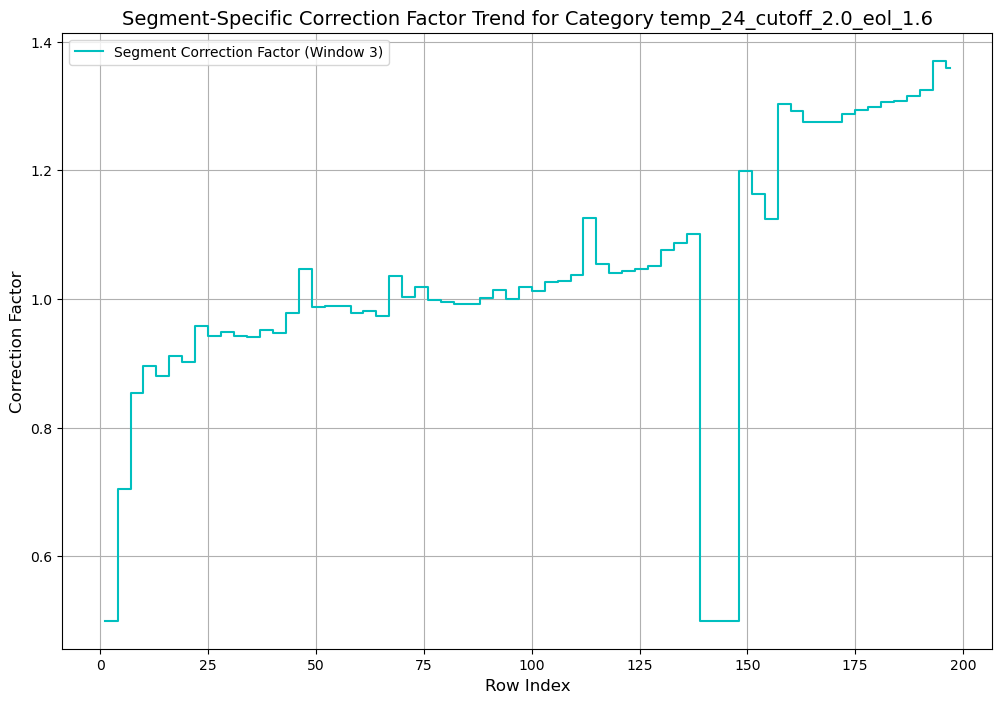


Processing category with conditions: (24, 2.2, 1.6)
Batteries: ['B0034', 'B0038']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0034.csv
Capacity data saved to: battery_data\capacity_soh_B0034.csv
Macro aging data saved to: battery_data\macro_aging_B0034.csv


[I 2025-03-25 10:46:43,301] A new study created in memory with name: no-name-859b8cf8-049b-49e6-8fc1-03ccae8c3e50
[I 2025-03-25 10:46:43,320] Trial 0 finished with value: 144166.3039051727 and parameters: {'window_size': 240}. Best is trial 0 with value: 144166.3039051727.
[I 2025-03-25 10:46:43,332] Trial 1 finished with value: 136516.03821172295 and parameters: {'window_size': 217}. Best is trial 1 with value: 136516.03821172295.
[I 2025-03-25 10:46:43,348] Trial 2 finished with value: 117384.90752126211 and parameters: {'window_size': 68}. Best is trial 2 with value: 117384.90752126211.
[I 2025-03-25 10:46:43,386] Trial 3 finished with value: 66896.93228618642 and parameters: {'window_size': 30}. Best is trial 3 with value: 66896.93228618642.
[I 2025-03-25 10:46:43,399] Trial 4 finished with value: 141160.70611359162 and parameters: {'window_size': 195}. Best is trial 3 with value: 66896.93228618642.


Cycling data saved to: battery_data\NASA_cycle_dataset_B0038.csv
Capacity data saved to: battery_data\capacity_soh_B0038.csv
Macro aging data saved to: battery_data\macro_aging_B0038.csv
Category data shape: (244, 10)


[I 2025-03-25 10:46:43,438] Trial 5 finished with value: 96428.66138791513 and parameters: {'window_size': 60}. Best is trial 3 with value: 66896.93228618642.
[I 2025-03-25 10:46:43,468] Trial 6 finished with value: 60763.15507417435 and parameters: {'window_size': 31}. Best is trial 6 with value: 60763.15507417435.
[I 2025-03-25 10:46:43,479] Trial 7 finished with value: 141224.68798870058 and parameters: {'window_size': 232}. Best is trial 6 with value: 60763.15507417435.
[I 2025-03-25 10:46:43,493] Trial 8 finished with value: 96428.66138791513 and parameters: {'window_size': 60}. Best is trial 6 with value: 60763.15507417435.
[I 2025-03-25 10:46:43,503] Trial 9 finished with value: 144341.29026798462 and parameters: {'window_size': 201}. Best is trial 6 with value: 60763.15507417435.
[I 2025-03-25 10:46:43,518] Trial 10 finished with value: 127497.58958966547 and parameters: {'window_size': 124}. Best is trial 6 with value: 60763.15507417435.
[I 2025-03-25 10:46:43,638] Trial 11 fi


Optimal Window Size for Condition (24, 2.2, 1.6): 4
Best MHE MSE: 20.6982


[I 2025-03-25 10:46:46,673] Trial 13 finished with value: 380.3521700993003 and parameters: {'Q': 0.0002475547157998313, 'R': 0.08593078324500199}. Best is trial 11 with value: 380.3303506791238.
[I 2025-03-25 10:46:46,685] Trial 14 finished with value: 380.40511760740156 and parameters: {'Q': 1.4716893680569587e-06, 'R': 0.015765595747232745}. Best is trial 11 with value: 380.3303506791238.
[I 2025-03-25 10:46:46,701] Trial 15 finished with value: 380.33136255306624 and parameters: {'Q': 1.5643318399243832e-05, 'R': 0.09818510220171515}. Best is trial 11 with value: 380.3303506791238.
[I 2025-03-25 10:46:46,720] Trial 16 finished with value: 380.44795056308504 and parameters: {'Q': 0.00021775775973648283, 'R': 0.01708758461067508}. Best is trial 11 with value: 380.3303506791238.
[I 2025-03-25 10:46:46,732] Trial 17 finished with value: 380.4705362779894 and parameters: {'Q': 2.2266015140053965e-05, 'R': 0.0014574787187441888}. Best is trial 11 with value: 380.3303506791238.
[I 2025-03

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.2_eol_1.6_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.2, 1.6) (Window Size: 4):
Segment 1 (Rows 1-4): k = 0.7915
Segment 2 (Rows 5-8): k = 0.8514
Segment 3 (Rows 9-12): k = 0.8231
Segment 4 (Rows 13-16): k = 0.8229
Segment 5 (Rows 17-20): k = 0.8567
Segment 6 (Rows 21-24): k = 0.8983
Segment 7 (Rows 25-28): k = 0.8812
Segment 8 (Rows 29-32): k = 0.8638
Segment 9 (Rows 33-36): k = 0.8679
Segment 10 (Rows 37-40): k = 0.8959
Segment 11 (Rows 41-44): k = 0.9143
Segment 12 (Rows 45-48): k = 1.0106
Segment 13 (Rows 49-52): k = 0.9536
Segment 14 (Rows 53-56): k = 0.9296
Segment 15 (Rows 57-60): k = 0.9344
Segment 16 (Rows 61-64): k = 0.9362
Segment 17 (Rows 65-68): k = 0.9691
Segment 18 (Rows 69-72): k = 0.9671
Segment 19 (Rows 73-76): k = 0.9737
Segment 20 (Rows 77-80): k = 0.9294
Segment 21 (Rows 81-84): k = 0.9353
Segment 22 (Rows 85-88): k = 0.9451
Segment 23 (Rows 89

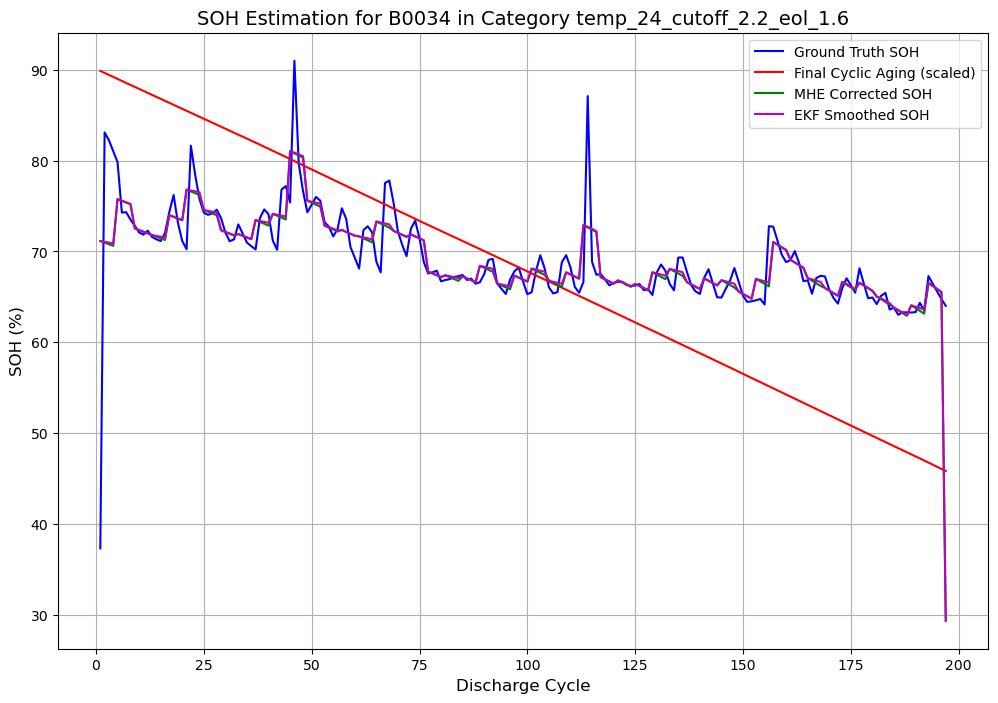

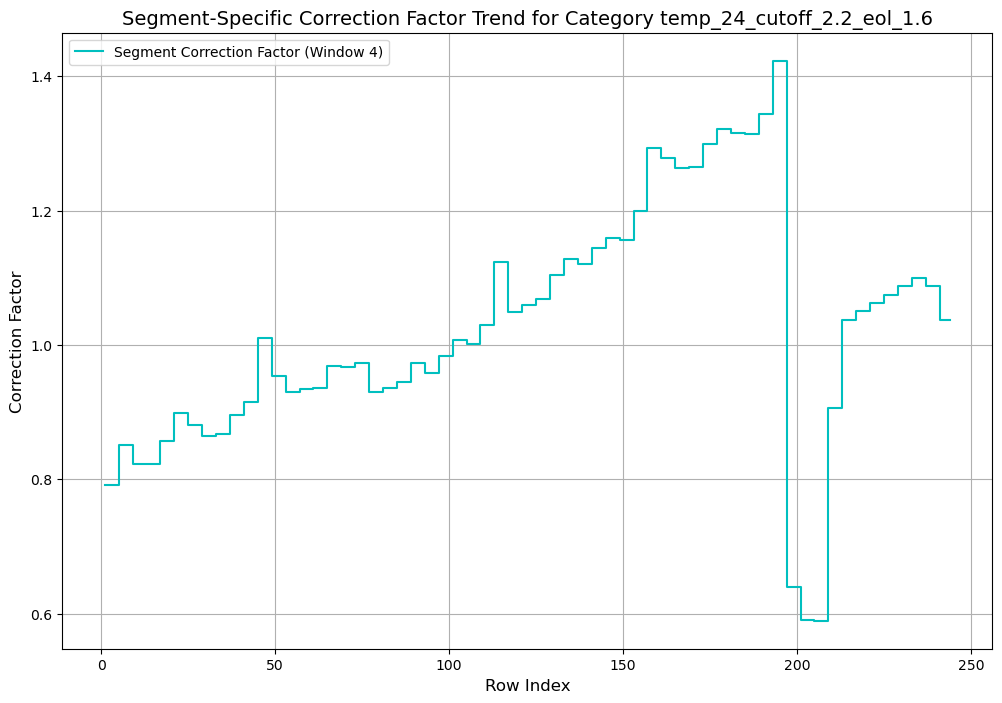


Processing category with conditions: (24, 2.7, 1.6)
Batteries: ['B0036', 'B0040']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0036.csv
Capacity data saved to: battery_data\capacity_soh_B0036.csv
Macro aging data saved to: battery_data\macro_aging_B0036.csv


[I 2025-03-25 10:47:19,206] A new study created in memory with name: no-name-ecaf0e50-5834-4831-8816-dfbcce89917c
[I 2025-03-25 10:47:19,218] Trial 0 finished with value: 194871.1183830141 and parameters: {'window_size': 197}. Best is trial 0 with value: 194871.1183830141.
[I 2025-03-25 10:47:19,242] Trial 1 finished with value: 160591.20755365188 and parameters: {'window_size': 26}. Best is trial 1 with value: 160591.20755365188.
[I 2025-03-25 10:47:19,268] Trial 2 finished with value: 137806.32042002986 and parameters: {'window_size': 33}. Best is trial 2 with value: 137806.32042002986.
[I 2025-03-25 10:47:19,285] Trial 3 finished with value: 308766.32103252487 and parameters: {'window_size': 123}. Best is trial 2 with value: 137806.32042002986.
[I 2025-03-25 10:47:19,296] Trial 4 finished with value: 302530.65274669725 and parameters: {'window_size': 231}. Best is trial 2 with value: 137806.32042002986.
[I 2025-03-25 10:47:19,306] Trial 5 finished with value: 219740.9048071976 and p

Cycling data saved to: battery_data\NASA_cycle_dataset_B0040.csv
Capacity data saved to: battery_data\capacity_soh_B0040.csv
Macro aging data saved to: battery_data\macro_aging_B0040.csv
Category data shape: (244, 10)


[I 2025-03-25 10:47:19,437] Trial 10 finished with value: 69677.63497661495 and parameters: {'window_size': 10}. Best is trial 10 with value: 69677.63497661495.
[I 2025-03-25 10:47:19,542] Trial 11 finished with value: 63757.89691156977 and parameters: {'window_size': 8}. Best is trial 11 with value: 63757.89691156977.
[I 2025-03-25 10:47:19,568] Trial 12 finished with value: 181935.5113908074 and parameters: {'window_size': 61}. Best is trial 11 with value: 63757.89691156977.
[I 2025-03-25 10:47:19,585] Trial 13 finished with value: 244519.24205725396 and parameters: {'window_size': 68}. Best is trial 11 with value: 63757.89691156977.
[I 2025-03-25 10:47:19,765] Trial 14 finished with value: 38678.60623900961 and parameters: {'window_size': 5}. Best is trial 14 with value: 38678.60623900961.
[I 2025-03-25 10:47:19,781] Trial 15 finished with value: 230355.40389909878 and parameters: {'window_size': 85}. Best is trial 14 with value: 38678.60623900961.
[I 2025-03-25 10:47:19,921] Trial 


Optimal Window Size for Condition (24, 2.7, 1.6): 4
Best MHE MSE: 30263.9998


[I 2025-03-25 10:47:22,760] Trial 1 finished with value: 304.584522611895 and parameters: {'Q': 0.00043427792798829716, 'R': 0.0003907328472224722}. Best is trial 0 with value: 303.58509777297996.
[I 2025-03-25 10:47:22,764] Trial 2 finished with value: 303.4721305958699 and parameters: {'Q': 2.3923976883800666e-05, 'R': 0.00037244271562943316}. Best is trial 2 with value: 303.4721305958699.
[I 2025-03-25 10:47:22,766] Trial 3 finished with value: 304.20215736434653 and parameters: {'Q': 0.00036517669575431526, 'R': 0.0006656203545061405}. Best is trial 2 with value: 303.4721305958699.
[I 2025-03-25 10:47:22,768] Trial 4 finished with value: 303.2743423628686 and parameters: {'Q': 5.826325709469374e-06, 'R': 0.041310188468743334}. Best is trial 4 with value: 303.2743423628686.
[I 2025-03-25 10:47:22,770] Trial 5 finished with value: 303.2824727383073 and parameters: {'Q': 6.945312288926548e-05, 'R': 0.03701548877424937}. Best is trial 4 with value: 303.2743423628686.
[I 2025-03-25 10:4

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.7_eol_1.6_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.7, 1.6) (Window Size: 4):
Segment 1 (Rows 1-4): k = 0.8044
Segment 2 (Rows 5-8): k = 0.9066
Segment 3 (Rows 9-12): k = 0.9099
Segment 4 (Rows 13-16): k = 0.9132
Segment 5 (Rows 17-20): k = 0.9214
Segment 6 (Rows 21-24): k = 0.9309
Segment 7 (Rows 25-28): k = 0.9369
Segment 8 (Rows 29-32): k = 0.9386
Segment 9 (Rows 33-36): k = 0.9421
Segment 10 (Rows 37-40): k = 0.9501
Segment 11 (Rows 41-44): k = 0.9557
Segment 12 (Rows 45-48): k = 1.0019
Segment 13 (Rows 49-52): k = 0.9794
Segment 14 (Rows 53-56): k = 0.9832
Segment 15 (Rows 57-60): k = 0.9902
Segment 16 (Rows 61-64): k = 0.9964
Segment 17 (Rows 65-68): k = 1.0077
Segment 18 (Rows 69-72): k = 1.0176
Segment 19 (Rows 73-76): k = 1.0250
Segment 20 (Rows 77-80): k = 1.0265
Segment 21 (Rows 81-84): k = 1.0316
Segment 22 (Rows 85-88): k = 1.0384
Segment 23 (Rows 89

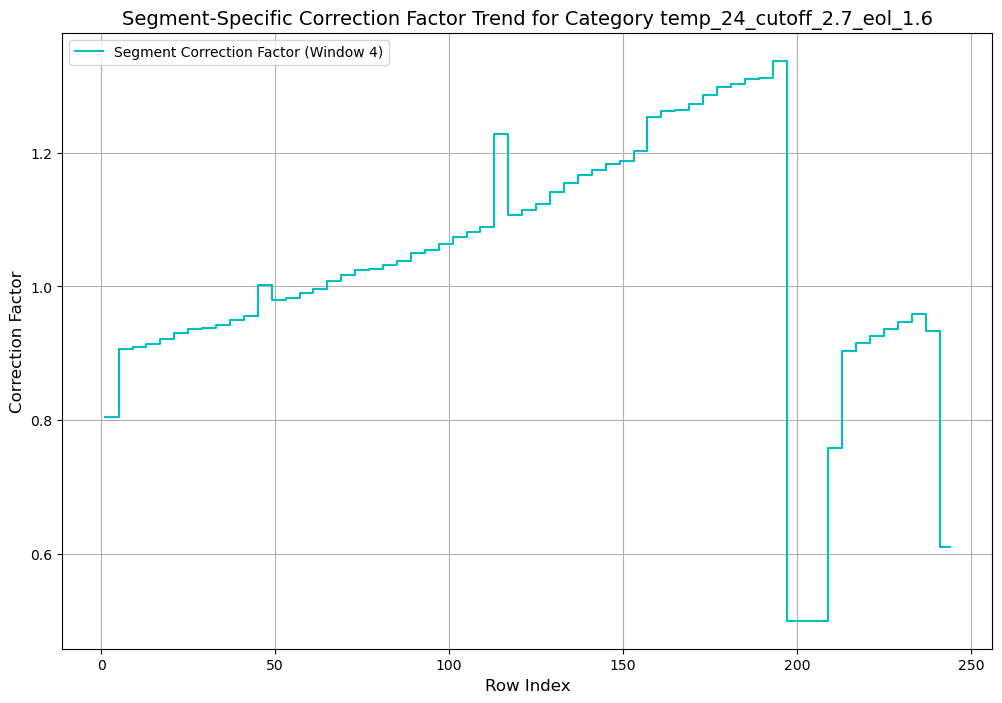


Processing category with conditions: (24, 2.5, 1.6)
Batteries: ['B0039']


[I 2025-03-25 10:47:40,354] A new study created in memory with name: no-name-5fe6570a-fe5c-4a68-a537-8cfc4f77454f
[I 2025-03-25 10:47:40,375] Trial 0 finished with value: 176461.04434918918 and parameters: {'window_size': 7}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:47:40,388] Trial 1 finished with value: 180430.83983089752 and parameters: {'window_size': 14}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:47:40,400] Trial 2 finished with value: 527304.6449770974 and parameters: {'window_size': 21}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:47:40,407] Trial 3 finished with value: 891658.4187052881 and parameters: {'window_size': 38}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:47:40,415] Trial 4 finished with value: 490869.30491199176 and parameters: {'window_size': 20}. Best is trial 0 with value: 176461.04434918918.
[I 2025-03-25 10:47:40,431] Trial 5 finished with value: 680563.1751806351 and param

Cycling data saved to: battery_data\NASA_cycle_dataset_B0039.csv
Capacity data saved to: battery_data\capacity_soh_B0039.csv
Macro aging data saved to: battery_data\macro_aging_B0039.csv
Category data shape: (47, 10)


[I 2025-03-25 10:47:40,493] Trial 9 finished with value: 926167.5688455531 and parameters: {'window_size': 42}. Best is trial 8 with value: 60996.12184145834.
[I 2025-03-25 10:47:40,532] Trial 10 finished with value: 57879.155997385154 and parameters: {'window_size': 3}. Best is trial 10 with value: 57879.155997385154.
[I 2025-03-25 10:47:40,589] Trial 11 finished with value: 57879.155997385154 and parameters: {'window_size': 3}. Best is trial 10 with value: 57879.155997385154.
[I 2025-03-25 10:47:40,622] Trial 12 finished with value: 213318.10505558562 and parameters: {'window_size': 10}. Best is trial 10 with value: 57879.155997385154.
[I 2025-03-25 10:47:40,666] Trial 13 finished with value: 57879.155997385154 and parameters: {'window_size': 3}. Best is trial 10 with value: 57879.155997385154.
[I 2025-03-25 10:47:40,690] Trial 14 finished with value: 180430.83983089752 and parameters: {'window_size': 14}. Best is trial 10 with value: 57879.155997385154.
[I 2025-03-25 10:47:40,718] T


Optimal Window Size for Condition (24, 2.5, 1.6): 3
Best MHE MSE: 57879.1560


[I 2025-03-25 10:47:42,199] A new study created in memory with name: no-name-e187a690-e7ca-42b7-a999-ffccf4b8f4b0
[I 2025-03-25 10:47:42,202] Trial 0 finished with value: 162.6295004850926 and parameters: {'Q': 0.0017675383692125736, 'R': 0.00015250446083014095}. Best is trial 0 with value: 162.6295004850926.
[I 2025-03-25 10:47:42,204] Trial 1 finished with value: 163.65910170150718 and parameters: {'Q': 0.00020056932127584962, 'R': 0.08800549560219785}. Best is trial 0 with value: 162.6295004850926.
[I 2025-03-25 10:47:42,207] Trial 2 finished with value: 162.66824140742264 and parameters: {'Q': 0.0013906176772435423, 'R': 0.00016854078479606687}. Best is trial 0 with value: 162.6295004850926.
[I 2025-03-25 10:47:42,209] Trial 3 finished with value: 163.66215222441772 and parameters: {'Q': 9.831935229712407e-05, 'R': 0.09259697933026183}. Best is trial 0 with value: 162.6295004850926.
[I 2025-03-25 10:47:42,211] Trial 4 finished with value: 163.6133895639908 and parameters: {'Q': 3.3

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.5_eol_1.6_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.5, 1.6) (Window Size: 3):
Segment 1 (Rows 1-3): k = 0.5000
Segment 2 (Rows 4-6): k = 0.5000
Segment 3 (Rows 7-9): k = 0.5000
Segment 4 (Rows 10-12): k = 0.5000
Segment 5 (Rows 13-15): k = 1.2393
Segment 6 (Rows 16-18): k = 1.2558
Segment 7 (Rows 19-21): k = 1.2659
Segment 8 (Rows 22-24): k = 1.2750
Segment 9 (Rows 25-27): k = 1.2856
Segment 10 (Rows 28-30): k = 1.2935
Segment 11 (Rows 31-33): k = 1.3035
Segment 12 (Rows 34-36): k = 1.3120
Segment 13 (Rows 37-39): k = 1.3205
Segment 14 (Rows 40-42): k = 1.2566
Segment 15 (Rows 43-45): k = 1.2498
Segment 16 (Rows 46-47): k = 1.0283

Error Metrics for Condition (24, 2.5, 1.6):
MSE (Smoothed vs Ground Truth): 74.7958
RMSE (Smoothed vs Ground Truth): 8.6485
MSE (Smoothed vs Final Cyclic Aging): 589.3093
RMSE (Smoothed vs Final Cyclic Aging): 24.2757



Processing category with conditions: (4, 2.0, 1.4)
Batteries: ['B0041', 'B0045', 'B0049', 'B0053']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0041.csv
Capacity data saved to: battery_data\capacity_soh_B0041.csv
Macro aging data saved to: battery_data\macro_aging_B0041.csv
Cycling data saved to: battery_data\NASA_cycle_dataset_B0045.csv
Capacity data saved to: battery_data\capacity_soh_B0045.csv
Macro aging data saved to: battery_data\macro_aging_B0045.csv


FileNotFoundError: [Errno 2] No such file or directory: 'battery_data\\B0049.mat'

In [27]:
with open("battery_params.json", 'r') as json_file:
    battery_params = json.load(json_file)
dataset_folder = 'battery_data'
results = process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials_mhe=50, n_trials_ekf=20)

In [28]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import optuna
import os
from collections import defaultdict

# Objective function for Optuna to optimize MHE window size per category
def mhe_category_objective(trial, category_df):
    num_cycles = len(category_df)
    window_size = trial.suggest_int('window_size', 3, num_cycles)
    
    # Scale Final_cyclic_aging for the category
    scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
    category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
    
    # Apply local correction with suggested window size
    segment_starts = list(range(0, num_cycles, window_size))
    corrected_soh = []
    
    for start in segment_starts:
        end = min(start + window_size, num_cycles)
        segment_df = category_df.iloc[start:end]
        predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
        ground_truth_segment = segment_df['ground_truth_soh'].values
        
        # Optimize a single k for the entire segment
        def segment_cost(k):
            return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
        
        result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
        k_opt = result.x[0]
        corrected_soh.extend(k_opt * predicted_soh_segment)
    
    # Calculate MSE for the category
    mse = np.mean((np.array(corrected_soh) - category_df['ground_truth_soh'])**2)
    
    # Enforce MSE between 9 and 25 %² (RMSE 3% to 5%)
    if mse < 9 or mse > 25:
        penalty = abs(mse - 17)
        return mse + penalty * 1000
    
    return mse

# EKF implementation with improved dynamic model
def ekf_smooth(segment_soh, ground_truth_segment, Q, R, trend_rate):
    n = len(segment_soh)
    if n == 0:
        return segment_soh
    
    x = segment_soh[0]  # Initial state estimate
    P = 1.0  # Initial covariance
    
    smoothed_soh = []
    for z in segment_soh:
        # Prediction step with trend (allows increase/decrease)
        x_pred = x + trend_rate  # Trend rate can be positive or negative
        P_pred = P + Q
        
        # Update step
        K = P_pred / (P_pred + R)
        x = x_pred + K * (z - x_pred)
        P = (1 - K) * P_pred
        
        smoothed_soh.append(x)
    
    return np.array(smoothed_soh)

# Objective function for Optuna to optimize EKF parameters per segment
def ekf_objective(trial, segment_soh, ground_truth_segment):
    Q = trial.suggest_float('Q', 1e-6, 1e-2, log=True)  # Process noise
    R = trial.suggest_float('R', 1e-4, 1e-1, log=True)  # Measurement noise
    trend_rate = trial.suggest_float('trend_rate', -0.1, 0.1)  # Allow increase or decrease
    
    smoothed_soh = ekf_smooth(segment_soh, ground_truth_segment, Q, R, trend_rate)
    mse = np.mean((smoothed_soh - ground_truth_segment)**2)
    return mse

# Process all batteries by test condition categories with MHE and EKF
def process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials_mhe=100, n_trials_ekf=50):
    # Load battery parameters
    with open("battery_params.json", 'r') as json_file:
        params = json.load(json_file)
    
    # Categorize batteries by test conditions
    categories = defaultdict(list)
    for battery_name, param in params.items():
        key = (param['ambient_temp_celsius'], param['cutoff_voltage'], param['eol_capacity'])
        categories[key].append(battery_name)
    
    # Process each category
    all_results = {}
    
    for test_condition, battery_names in categories.items():
        print(f"\nProcessing category with conditions: {test_condition}")
        print(f"Batteries: {battery_names}")
        
        category_dfs = []
        for battery_name in battery_names:
            macro_df = process_battery(dataset_folder, battery_name, params)
            category_dfs.append(macro_df)
        
        # Combine data for this category
        category_df = pd.concat(category_dfs, ignore_index=True)
        print(f"Category data shape: {category_df.shape}")
        
        # Optimize window size for this category with MHE
        study_mhe = optuna.create_study(direction='minimize')
        study_mhe.optimize(lambda trial: mhe_category_objective(trial, category_df.copy()), n_trials=n_trials_mhe)
        
        best_window_size = study_mhe.best_params['window_size']
        best_mhe_mse = study_mhe.best_value
        
        print(f"\nOptimal Window Size for Condition {test_condition}: {best_window_size}")
        print(f"Best MHE MSE: {best_mhe_mse:.4f}")
        
        # Apply MHE correction with optimized window size and single k per segment
        scaling_factor = category_df['ground_truth_soh'].mean() / category_df['Final_cyclic_aging'].mean()
        category_df['Final_cyclic_aging_scaled'] = category_df['Final_cyclic_aging'] * scaling_factor
        num_cycles = len(category_df)
        segment_starts = list(range(0, num_cycles, best_window_size))
        corrected_soh = []
        segment_correction_factors = []
        
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = category_df.iloc[start:end]
            predicted_soh_segment = segment_df['Final_cyclic_aging_scaled'].values
            ground_truth_segment = segment_df['ground_truth_soh'].values
            
            # Optimize a single k for the segment
            def segment_cost(k):
                return np.sum((k * predicted_soh_segment - ground_truth_segment)**2)
            
            result = minimize(segment_cost, 1.0, bounds=[(0.5, 1.5)], method='L-BFGS-B')
            k_opt = result.x[0]
            segment_correction_factors.extend([k_opt] * len(segment_df))
            corrected_soh.extend(k_opt * predicted_soh_segment)
        
        category_df['Local_Corrected_SOH'] = corrected_soh
        category_df['Segment_Correction_Factor'] = segment_correction_factors
        
        # Apply EKF smoothing per segment with Optuna optimization
        smoothed_soh = []
        for start in segment_starts:
            end = min(start + best_window_size, num_cycles)
            segment_df = category_df.iloc[start:end]
            segment_soh = segment_df['Local_Corrected_SOH'].values
            ground_truth_segment = segment_df['ground_truth_soh'].values
            
            # Optimize EKF parameters
            study_ekf = optuna.create_study(direction='minimize')
            study_ekf.optimize(lambda trial: ekf_objective(trial, segment_soh, ground_truth_segment), n_trials=n_trials_ekf)
            
            best_Q = study_ekf.best_params['Q']
            best_R = study_ekf.best_params['R']
            best_trend_rate = study_ekf.best_params['trend_rate']
            
            # Apply EKF with best parameters
            smoothed_segment = ekf_smooth(segment_soh, ground_truth_segment, best_Q, best_R, best_trend_rate)
            smoothed_soh.extend(smoothed_segment)
        
        category_df['Smoothed_SOH'] = smoothed_soh
        
        # Calculate MSE and RMSE for comparisons
        mse_ground_truth = np.mean((category_df['Smoothed_SOH'] - category_df['ground_truth_soh'])**2)
        rmse_ground_truth = np.sqrt(mse_ground_truth)
        mse_final_cyclic = np.mean((category_df['Smoothed_SOH'] - category_df['Final_cyclic_aging_scaled'])**2)
        rmse_final_cyclic = np.sqrt(mse_final_cyclic)
        
        # Save results for this category
        condition_str = f"temp_{test_condition[0]}_cutoff_{test_condition[1]}_eol_{test_condition[2]}"
        output_file = os.path.join(dataset_folder, f"category_{condition_str}_mhe_ekf_optuna.csv")
        category_df.to_csv(output_file, index=False)
        print(f"Category corrected and smoothed SOH data saved to: {output_file}")
        
        # Store results
        all_results[condition_str] = {
            'window_size': best_window_size,
            'mse_mhe': best_mhe_mse,
            'mse_ground_truth': mse_ground_truth,
            'rmse_ground_truth': rmse_ground_truth,
            'mse_final_cyclic': mse_final_cyclic,
            'rmse_final_cyclic': rmse_final_cyclic,
            'df': category_df
        }
        
        # Print segment-specific correction factors and error metrics
        print(f"\nSegment-Specific Correction Factors for Condition {test_condition} (Window Size: {best_window_size}):")
        for i, start in enumerate(segment_starts):
            end = min(start + best_window_size, num_cycles)
            k_value = segment_correction_factors[start]
            print(f"Segment {i+1} (Rows {start+1}-{end}): k = {k_value:.4f}")
        
        print(f"\nError Metrics for Condition {test_condition}:")
        print(f"MSE (Smoothed vs Ground Truth): {mse_ground_truth:.4f}")
        print(f"RMSE (Smoothed vs Ground Truth): {rmse_ground_truth:.4f}")
        print(f"MSE (Smoothed vs Final Cyclic Aging): {mse_final_cyclic:.4f}")
        print(f"RMSE (Smoothed vs Final Cyclic Aging): {rmse_final_cyclic:.4f}")
        
        # Plot for the first battery in the category
        sample_df = category_df[category_df['battery_id'] == battery_names[0]]
        plt.figure(figsize=(12, 8))
        plt.plot(sample_df['cycle'], sample_df['ground_truth_soh'], label='Ground Truth SOH', color='b')
        plt.plot(sample_df['cycle'], sample_df['Final_cyclic_aging_scaled'], label='Final Cyclic Aging (scaled)', color='r')
        plt.plot(sample_df['cycle'], sample_df['Local_Corrected_SOH'], label='MHE Corrected SOH', color='g')
        plt.plot(sample_df['cycle'], sample_df['Smoothed_SOH'], label='EKF Smoothed SOH', color='m')
        plt.title(f'SOH Estimation for {battery_names[0]} in Category {condition_str}', fontsize=14)
        plt.xlabel('Discharge Cycle', fontsize=12)
        plt.ylabel('SOH (%)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Plot segment-specific correction factors
        plt.figure(figsize=(12, 8))
        plt.step(range(1, num_cycles + 1), category_df['Segment_Correction_Factor'], label=f'Segment Correction Factor (Window {best_window_size})', color='c', where='post')
        plt.title(f'Segment-Specific Correction Factor Trend for Category {condition_str}', fontsize=14)
        plt.xlabel('Row Index', fontsize=12)
        plt.ylabel('Correction Factor', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return all_results


Processing category with conditions: (24, 2.7, 1.4)
Batteries: ['B0005', 'B0028']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0005.csv
Capacity data saved to: battery_data\capacity_soh_B0005.csv
Macro aging data saved to: battery_data\macro_aging_B0005.csv


[I 2025-03-25 14:36:18,374] A new study created in memory with name: no-name-09e948f5-b719-4675-8337-63232487401f
[I 2025-03-25 14:36:18,409] Trial 0 finished with value: 14819.29589802082 and parameters: {'window_size': 56}. Best is trial 0 with value: 14819.29589802082.
[I 2025-03-25 14:36:18,425] Trial 1 finished with value: 14192.41889023273 and parameters: {'window_size': 85}. Best is trial 1 with value: 14192.41889023273.
[I 2025-03-25 14:36:18,471] Trial 2 finished with value: 16384.28709942558 and parameters: {'window_size': 21}. Best is trial 1 with value: 14192.41889023273.
[I 2025-03-25 14:36:18,491] Trial 3 finished with value: 13371.048024695943 and parameters: {'window_size': 80}. Best is trial 3 with value: 13371.048024695943.
[I 2025-03-25 14:36:18,508] Trial 4 finished with value: 12740.710927064685 and parameters: {'window_size': 76}. Best is trial 4 with value: 12740.710927064685.
[I 2025-03-25 14:36:18,522] Trial 5 finished with value: 12595.638657678137 and paramet

Cycling data saved to: battery_data\NASA_cycle_dataset_B0028.csv
Capacity data saved to: battery_data\capacity_soh_B0028.csv
Macro aging data saved to: battery_data\macro_aging_B0028.csv
Category data shape: (196, 10)


[I 2025-03-25 14:36:18,542] Trial 6 finished with value: 12630.274734618915 and parameters: {'window_size': 92}. Best is trial 5 with value: 12595.638657678137.
[I 2025-03-25 14:36:18,544] Trial 7 finished with value: 12221.216553154998 and parameters: {'window_size': 135}. Best is trial 7 with value: 12221.216553154998.
[I 2025-03-25 14:36:18,561] Trial 8 finished with value: 12221.216553154998 and parameters: {'window_size': 135}. Best is trial 7 with value: 12221.216553154998.
[I 2025-03-25 14:36:18,594] Trial 9 finished with value: 14289.42523572838 and parameters: {'window_size': 25}. Best is trial 7 with value: 12221.216553154998.
[I 2025-03-25 14:36:18,619] Trial 10 finished with value: 12575.872033500955 and parameters: {'window_size': 184}. Best is trial 7 with value: 12221.216553154998.
[I 2025-03-25 14:36:18,638] Trial 11 finished with value: 12434.935479418447 and parameters: {'window_size': 145}. Best is trial 7 with value: 12221.216553154998.
[I 2025-03-25 14:36:18,659] T


Optimal Window Size for Condition (24, 2.7, 1.4): 196
Best MHE MSE: 11802.7299


[I 2025-03-25 14:36:21,146] Trial 17 finished with value: 5.016824458050214 and parameters: {'Q': 0.00101518615014952, 'R': 0.00023287985287444516, 'trend_rate': 0.06781095034693503}. Best is trial 13 with value: 5.006569890778887.
[I 2025-03-25 14:36:21,156] Trial 18 finished with value: 9.214197571443691 and parameters: {'Q': 0.0011553427130075445, 'R': 0.026733141102471523, 'trend_rate': 0.06345730806586858}. Best is trial 13 with value: 5.006569890778887.
[I 2025-03-25 14:36:21,188] Trial 19 finished with value: 6.561434779996594 and parameters: {'Q': 6.096019586698374e-05, 'R': 0.0003837718415908711, 'trend_rate': 0.027047241141630228}. Best is trial 13 with value: 5.006569890778887.
[I 2025-03-25 14:36:21,208] Trial 20 finished with value: 5.16308483352141 and parameters: {'Q': 0.000894576130557291, 'R': 0.0008548665902254732, 'trend_rate': -0.09867382591962433}. Best is trial 13 with value: 5.006569890778887.
[I 2025-03-25 14:36:21,226] Trial 21 finished with value: 5.0625401083

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.7_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.7, 1.4) (Window Size: 196):
Segment 1 (Rows 1-196): k = 0.9977

Error Metrics for Condition (24, 2.7, 1.4):
MSE (Smoothed vs Ground Truth): 5.0008
RMSE (Smoothed vs Ground Truth): 2.2362
MSE (Smoothed vs Final Cyclic Aging): 0.3640
RMSE (Smoothed vs Final Cyclic Aging): 0.6033


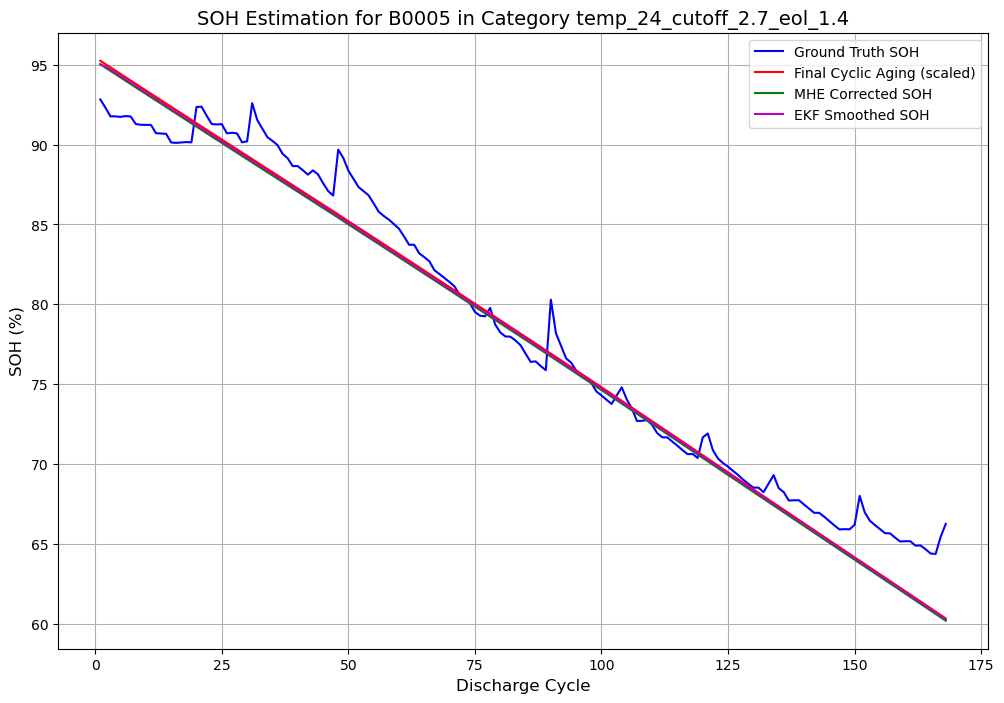

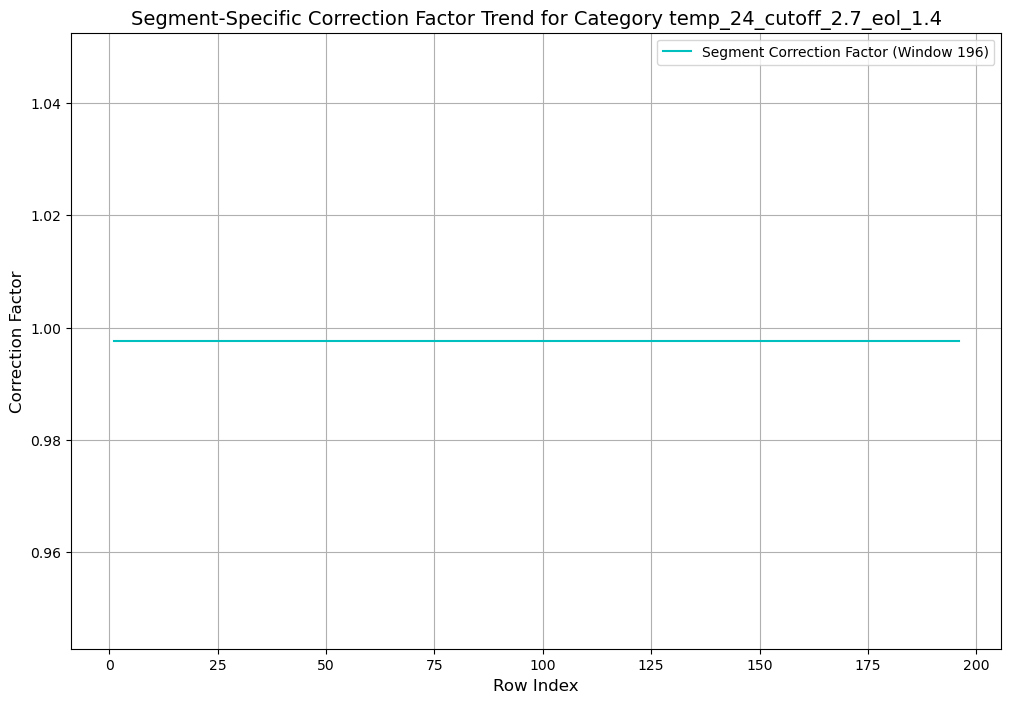


Processing category with conditions: (24, 2.5, 1.4)
Batteries: ['B0006', 'B0018', 'B0027']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0006.csv
Capacity data saved to: battery_data\capacity_soh_B0006.csv
Macro aging data saved to: battery_data\macro_aging_B0006.csv
Cycling data saved to: battery_data\NASA_cycle_dataset_B0018.csv
Capacity data saved to: battery_data\capacity_soh_B0018.csv
Macro aging data saved to: battery_data\macro_aging_B0018.csv


[I 2025-03-25 14:36:50,321] A new study created in memory with name: no-name-b5b1958b-e228-477c-91d6-5d052a8b314d
[I 2025-03-25 14:36:50,345] Trial 0 finished with value: 9116.525871472484 and parameters: {'window_size': 177}. Best is trial 0 with value: 9116.525871472484.
[I 2025-03-25 14:36:50,345] Trial 1 finished with value: 10.389383825813837 and parameters: {'window_size': 322}. Best is trial 1 with value: 10.389383825813837.
[I 2025-03-25 14:36:50,375] Trial 2 finished with value: 9871.473096367203 and parameters: {'window_size': 156}. Best is trial 1 with value: 10.389383825813837.
[I 2025-03-25 14:36:50,394] Trial 3 finished with value: 9772.503326956768 and parameters: {'window_size': 158}. Best is trial 1 with value: 10.389383825813837.
[I 2025-03-25 14:36:50,407] Trial 4 finished with value: 10.383368330206878 and parameters: {'window_size': 321}. Best is trial 4 with value: 10.383368330206878.
[I 2025-03-25 14:36:50,429] Trial 5 finished with value: 13403.249947015214 and 

Cycling data saved to: battery_data\NASA_cycle_dataset_B0027.csv
Capacity data saved to: battery_data\capacity_soh_B0027.csv
Macro aging data saved to: battery_data\macro_aging_B0027.csv
Category data shape: (328, 10)


[I 2025-03-25 14:36:50,511] Trial 10 finished with value: 10.059978325644487 and parameters: {'window_size': 249}. Best is trial 10 with value: 10.059978325644487.
[I 2025-03-25 14:36:50,529] Trial 11 finished with value: 10.239199611198577 and parameters: {'window_size': 255}. Best is trial 10 with value: 10.059978325644487.
[I 2025-03-25 14:36:50,546] Trial 12 finished with value: 10.097516182354989 and parameters: {'window_size': 250}. Best is trial 10 with value: 10.059978325644487.
[I 2025-03-25 14:36:50,563] Trial 13 finished with value: 9.822855017914325 and parameters: {'window_size': 243}. Best is trial 13 with value: 9.822855017914325.
[I 2025-03-25 14:36:50,590] Trial 14 finished with value: 9.373557859049031 and parameters: {'window_size': 232}. Best is trial 14 with value: 9.373557859049031.
[I 2025-03-25 14:36:50,607] Trial 15 finished with value: 9.174254614724305 and parameters: {'window_size': 219}. Best is trial 15 with value: 9.174254614724305.
[I 2025-03-25 14:36:50


Optimal Window Size for Condition (24, 2.5, 1.4): 207
Best MHE MSE: 9.0421


[I 2025-03-25 14:36:52,948] Trial 17 finished with value: 11.463086566405709 and parameters: {'Q': 0.0026639597473477397, 'R': 0.0003151586388361707, 'trend_rate': 0.02419173243634933}. Best is trial 16 with value: 11.435675212516967.
[I 2025-03-25 14:36:52,978] Trial 18 finished with value: 24.705268391851337 and parameters: {'Q': 8.822776482061863e-05, 'R': 0.0038902869480714375, 'trend_rate': 0.009609232306530645}. Best is trial 16 with value: 11.435675212516967.
[I 2025-03-25 14:36:52,995] Trial 19 finished with value: 11.907944931278719 and parameters: {'Q': 0.0003752771774100797, 'R': 0.00024965486039680874, 'trend_rate': -0.05929248745367262}. Best is trial 16 with value: 11.435675212516967.
[I 2025-03-25 14:36:53,018] Trial 20 finished with value: 16.978524091893757 and parameters: {'Q': 6.9634540731378e-05, 'R': 0.0006867238593268297, 'trend_rate': 0.047212082743163394}. Best is trial 16 with value: 11.435675212516967.
[I 2025-03-25 14:36:53,041] Trial 21 finished with value: 

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.5_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.5, 1.4) (Window Size: 207):
Segment 1 (Rows 1-207): k = 1.0130
Segment 2 (Rows 208-328): k = 0.9821

Error Metrics for Condition (24, 2.5, 1.4):
MSE (Smoothed vs Ground Truth): 9.0401
RMSE (Smoothed vs Ground Truth): 3.0067
MSE (Smoothed vs Final Cyclic Aging): 1.4239
RMSE (Smoothed vs Final Cyclic Aging): 1.1933


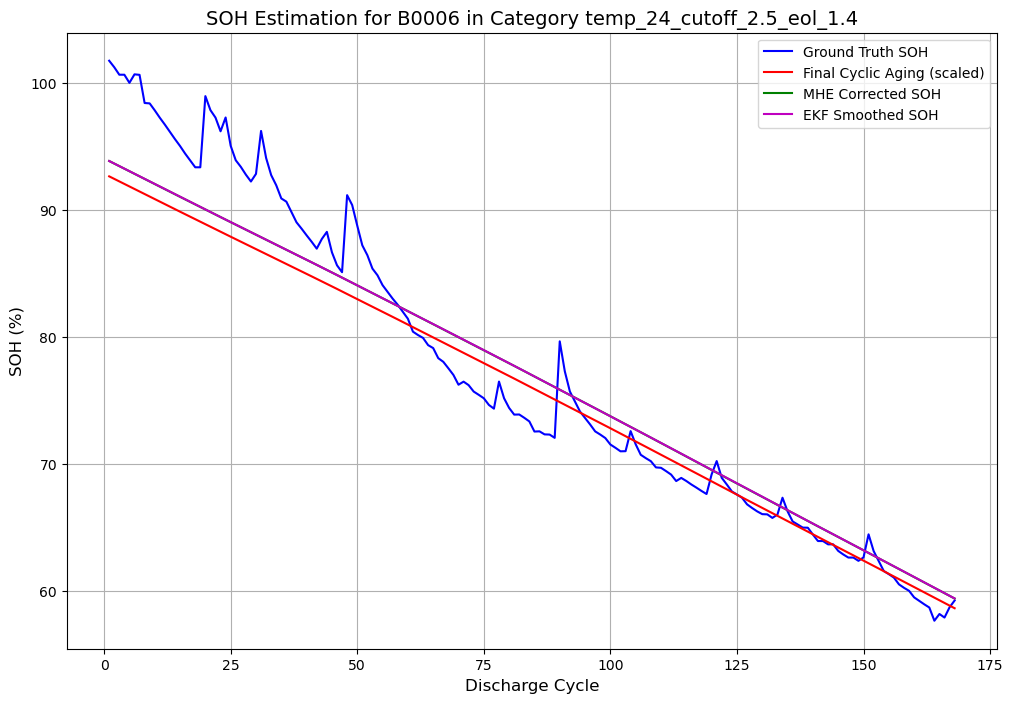

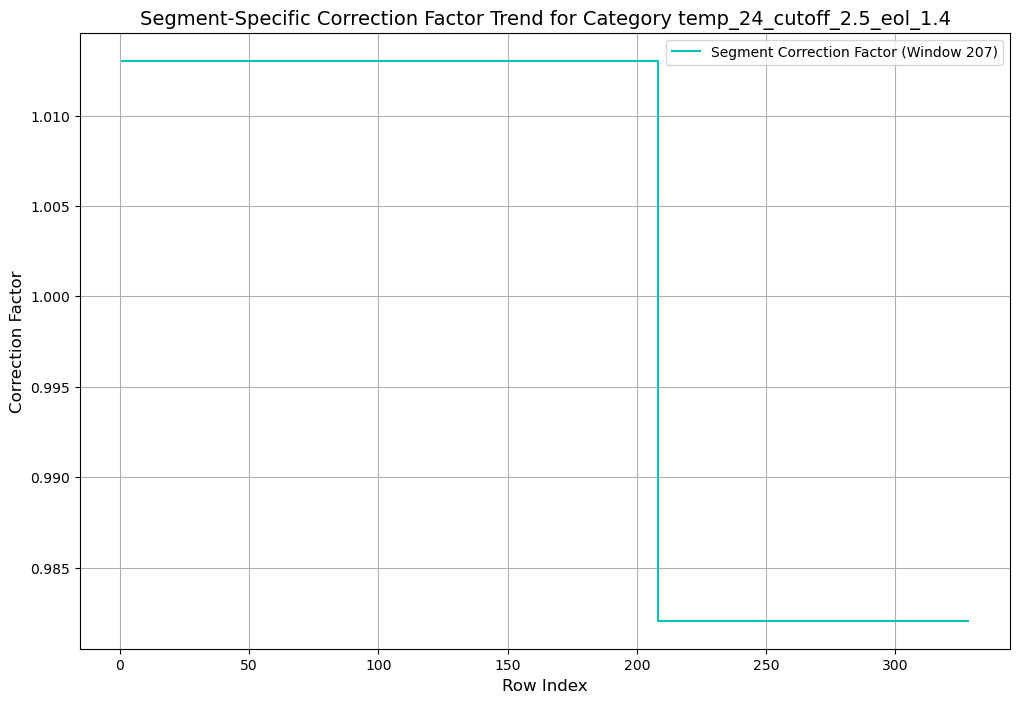


Processing category with conditions: (24, 2.2, 1.4)
Batteries: ['B0007', 'B0026']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0007.csv
Capacity data saved to: battery_data\capacity_soh_B0007.csv
Macro aging data saved to: battery_data\macro_aging_B0007.csv


[I 2025-03-25 14:37:14,731] A new study created in memory with name: no-name-1c7165f6-8a1e-4fd0-8209-0966b7329d4a
[I 2025-03-25 14:37:14,756] Trial 0 finished with value: 17.057239068277823 and parameters: {'window_size': 65}. Best is trial 0 with value: 17.057239068277823.
[I 2025-03-25 14:37:14,779] Trial 1 finished with value: 9813.352770762236 and parameters: {'window_size': 41}. Best is trial 0 with value: 17.057239068277823.
[I 2025-03-25 14:37:14,794] Trial 2 finished with value: 11856.70888409028 and parameters: {'window_size': 56}. Best is trial 0 with value: 17.057239068277823.
[I 2025-03-25 14:37:14,811] Trial 3 finished with value: 9115.279520025855 and parameters: {'window_size': 23}. Best is trial 0 with value: 17.057239068277823.
[I 2025-03-25 14:37:14,847] Trial 4 finished with value: 10601.95217176579 and parameters: {'window_size': 34}. Best is trial 0 with value: 17.057239068277823.
[I 2025-03-25 14:37:14,855] Trial 5 finished with value: 17.801369709669313 and param

Cycling data saved to: battery_data\NASA_cycle_dataset_B0026.csv
Capacity data saved to: battery_data\capacity_soh_B0026.csv
Macro aging data saved to: battery_data\macro_aging_B0026.csv
Category data shape: (196, 10)


[I 2025-03-25 14:37:14,941] Trial 6 finished with value: 14526.740687738838 and parameters: {'window_size': 7}. Best is trial 0 with value: 17.057239068277823.
[I 2025-03-25 14:37:14,946] Trial 7 finished with value: 16.38535365803965 and parameters: {'window_size': 146}. Best is trial 7 with value: 16.38535365803965.
[I 2025-03-25 14:37:14,984] Trial 8 finished with value: 12.33803807322322 and parameters: {'window_size': 38}. Best is trial 8 with value: 12.33803807322322.
[I 2025-03-25 14:37:14,994] Trial 9 finished with value: 17.506310040252178 and parameters: {'window_size': 132}. Best is trial 8 with value: 12.33803807322322.
[I 2025-03-25 14:37:15,010] Trial 10 finished with value: 15.23380017467496 and parameters: {'window_size': 91}. Best is trial 8 with value: 12.33803807322322.
[I 2025-03-25 14:37:15,028] Trial 11 finished with value: 17.35572009423769 and parameters: {'window_size': 191}. Best is trial 8 with value: 12.33803807322322.
[I 2025-03-25 14:37:15,044] Trial 12 fi


Optimal Window Size for Condition (24, 2.2, 1.4): 168
Best MHE MSE: 10.0215


[I 2025-03-25 14:37:17,278] Trial 17 finished with value: 8.327319666719678 and parameters: {'Q': 0.0024010794748340635, 'R': 0.0046577430925213515, 'trend_rate': 0.03326957730587256}. Best is trial 14 with value: 8.239618236140732.
[I 2025-03-25 14:37:17,295] Trial 18 finished with value: 8.284058126374138 and parameters: {'Q': 0.00027979455419482787, 'R': 0.0329440128700646, 'trend_rate': -0.07285534867779911}. Best is trial 14 with value: 8.239618236140732.
[I 2025-03-25 14:37:17,328] Trial 19 finished with value: 8.296370267902107 and parameters: {'Q': 0.0034203561300627868, 'R': 0.011516594727941325, 'trend_rate': 0.0001485190385954946}. Best is trial 14 with value: 8.239618236140732.
[I 2025-03-25 14:37:17,349] Trial 20 finished with value: 20.59105684392222 and parameters: {'Q': 0.0002837886801049484, 'R': 0.09377446345337162, 'trend_rate': 0.07056555307077225}. Best is trial 14 with value: 8.239618236140732.
[I 2025-03-25 14:37:17,372] Trial 21 finished with value: 8.3257188218

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.2_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.2, 1.4) (Window Size: 168):
Segment 1 (Rows 1-168): k = 1.0106
Segment 2 (Rows 169-196): k = 0.9251

Error Metrics for Condition (24, 2.2, 1.4):
MSE (Smoothed vs Ground Truth): 9.6643
RMSE (Smoothed vs Ground Truth): 3.1087
MSE (Smoothed vs Final Cyclic Aging): 7.5532
RMSE (Smoothed vs Final Cyclic Aging): 2.7483


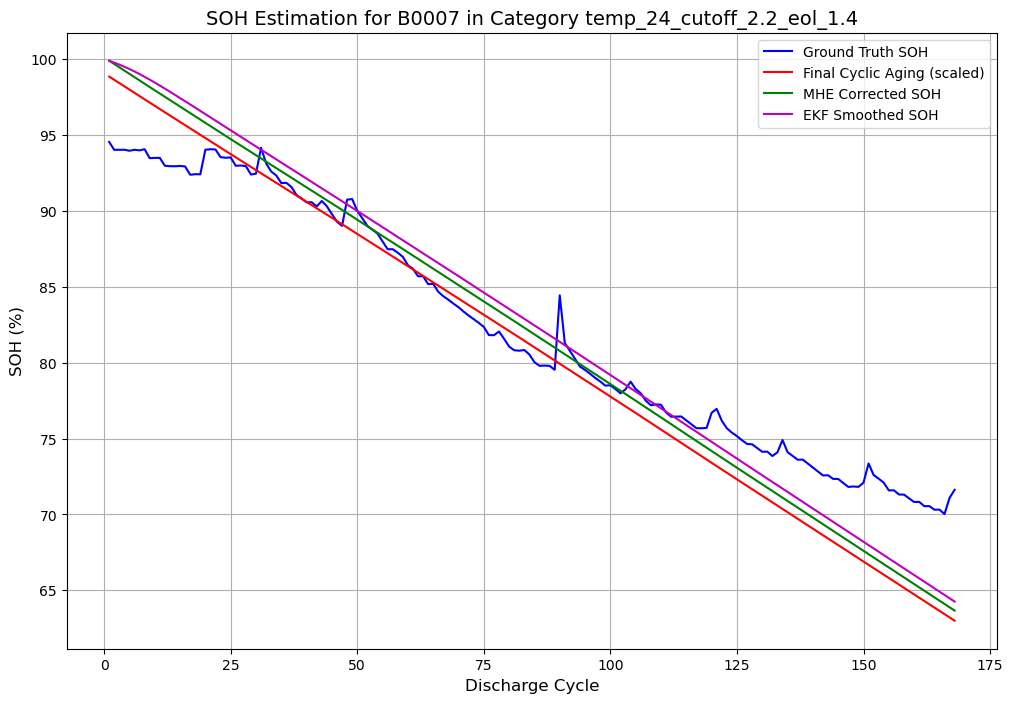

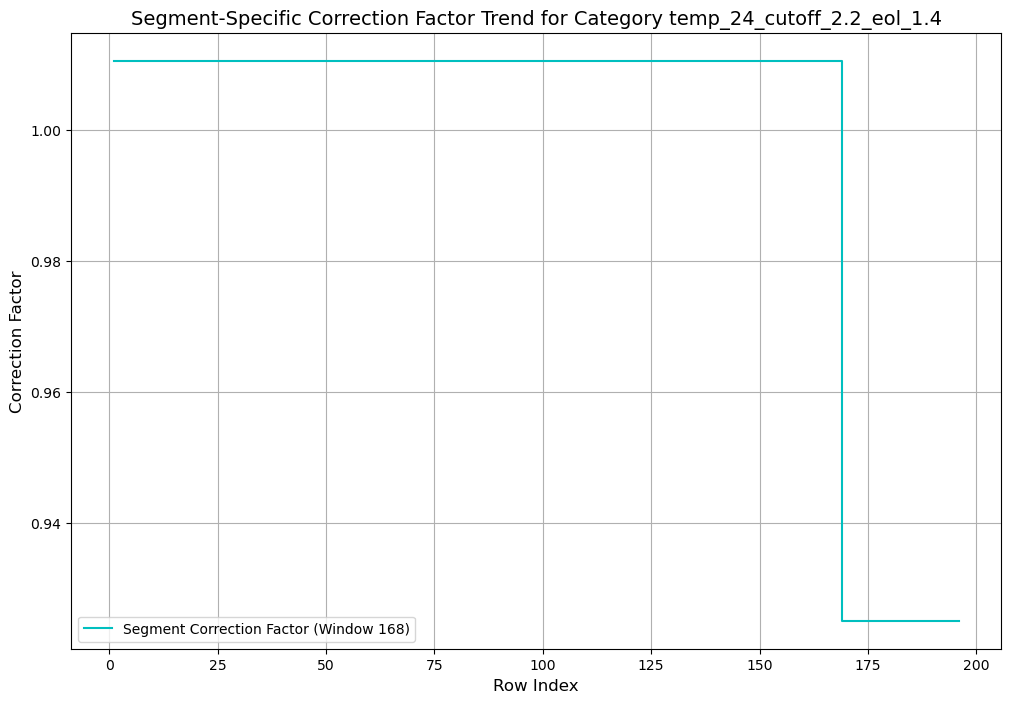


Processing category with conditions: (24, 2.0, 1.4)
Batteries: ['B0025']


[I 2025-03-25 14:37:22,512] A new study created in memory with name: no-name-cd0ba9d2-a884-4e07-bf19-4c0e6c555f61
[I 2025-03-25 14:37:22,535] Trial 0 finished with value: 16689.534796383592 and parameters: {'window_size': 22}. Best is trial 0 with value: 16689.534796383592.
[I 2025-03-25 14:37:22,547] Trial 1 finished with value: 16779.34464983984 and parameters: {'window_size': 12}. Best is trial 0 with value: 16689.534796383592.
[I 2025-03-25 14:37:22,565] Trial 2 finished with value: 16715.23478428774 and parameters: {'window_size': 13}. Best is trial 0 with value: 16689.534796383592.
[I 2025-03-25 14:37:22,580] Trial 3 finished with value: 16593.35839696456 and parameters: {'window_size': 24}. Best is trial 3 with value: 16593.35839696456.
[I 2025-03-25 14:37:22,580] Trial 4 finished with value: 16614.499888598486 and parameters: {'window_size': 23}. Best is trial 3 with value: 16593.35839696456.
[I 2025-03-25 14:37:22,611] Trial 5 finished with value: 16853.840120502733 and parame

Cycling data saved to: battery_data\NASA_cycle_dataset_B0025.csv
Capacity data saved to: battery_data\capacity_soh_B0025.csv
Macro aging data saved to: battery_data\macro_aging_B0025.csv
Category data shape: (28, 10)


[I 2025-03-25 14:37:22,678] Trial 10 finished with value: 16804.251506231863 and parameters: {'window_size': 17}. Best is trial 6 with value: 16539.74278877139.
[I 2025-03-25 14:37:22,696] Trial 11 finished with value: 16464.796564314256 and parameters: {'window_size': 27}. Best is trial 11 with value: 16464.796564314256.
[I 2025-03-25 14:37:22,712] Trial 12 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 12 with value: 16460.772432039776.
[I 2025-03-25 14:37:22,726] Trial 13 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 12 with value: 16460.772432039776.
[I 2025-03-25 14:37:22,744] Trial 14 finished with value: 16772.844517539354 and parameters: {'window_size': 18}. Best is trial 12 with value: 16460.772432039776.
[I 2025-03-25 14:37:22,760] Trial 15 finished with value: 16460.772432039776 and parameters: {'window_size': 28}. Best is trial 12 with value: 16460.772432039776.
[I 2025-03-25 14:37:22,7


Optimal Window Size for Condition (24, 2.0, 1.4): 28
Best MHE MSE: 16460.7724


[I 2025-03-25 14:37:24,491] Trial 17 finished with value: 0.5340107734246825 and parameters: {'Q': 0.0016616388904340926, 'R': 0.0013965964103985521, 'trend_rate': -0.0684349065990228}. Best is trial 14 with value: 0.5313460408672067.
[I 2025-03-25 14:37:24,514] Trial 18 finished with value: 0.534033908681887 and parameters: {'Q': 0.001553002938848452, 'R': 0.0015383765393146296, 'trend_rate': -0.02401371875159137}. Best is trial 14 with value: 0.5313460408672067.
[I 2025-03-25 14:37:24,532] Trial 19 finished with value: 0.5217432615267243 and parameters: {'Q': 0.00012739909244601738, 'R': 0.001541874277339082, 'trend_rate': -0.09186197544322605}. Best is trial 19 with value: 0.5217432615267243.
[I 2025-03-25 14:37:24,541] Trial 20 finished with value: 0.5527541658139602 and parameters: {'Q': 9.473080880690781e-05, 'R': 0.00753125696906127, 'trend_rate': -0.09766768004241413}. Best is trial 19 with value: 0.5217432615267243.
[I 2025-03-25 14:37:24,564] Trial 21 finished with value: 0.5

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.0_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.0, 1.4) (Window Size: 28):
Segment 1 (Rows 1-28): k = 0.9999

Error Metrics for Condition (24, 2.0, 1.4):
MSE (Smoothed vs Ground Truth): 0.5217
RMSE (Smoothed vs Ground Truth): 0.7223
MSE (Smoothed vs Final Cyclic Aging): 0.0802
RMSE (Smoothed vs Final Cyclic Aging): 0.2831


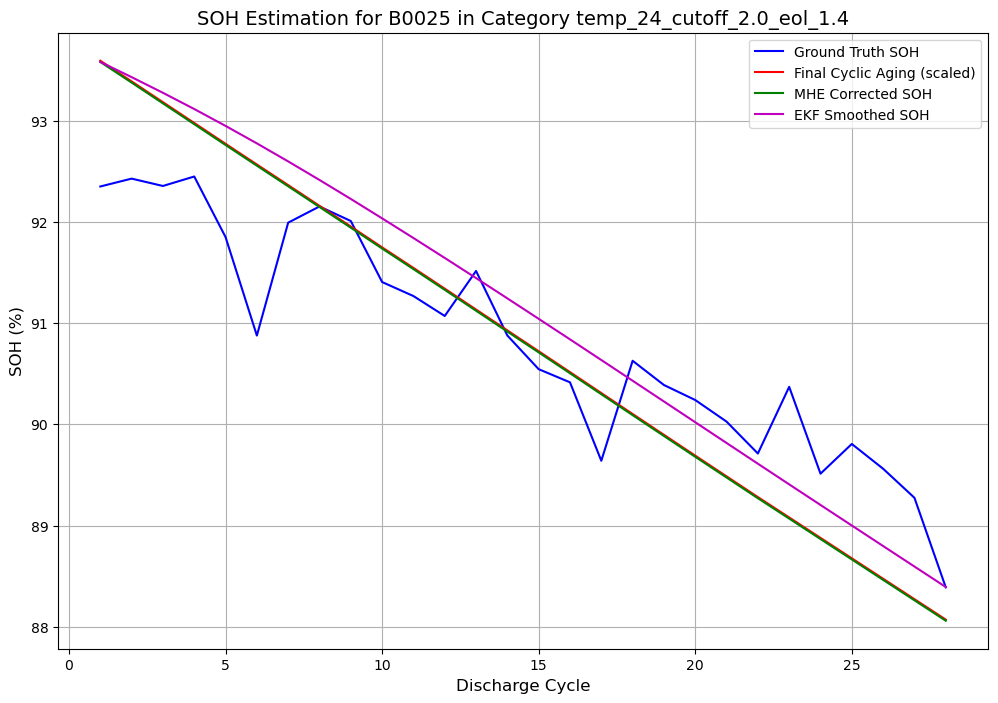

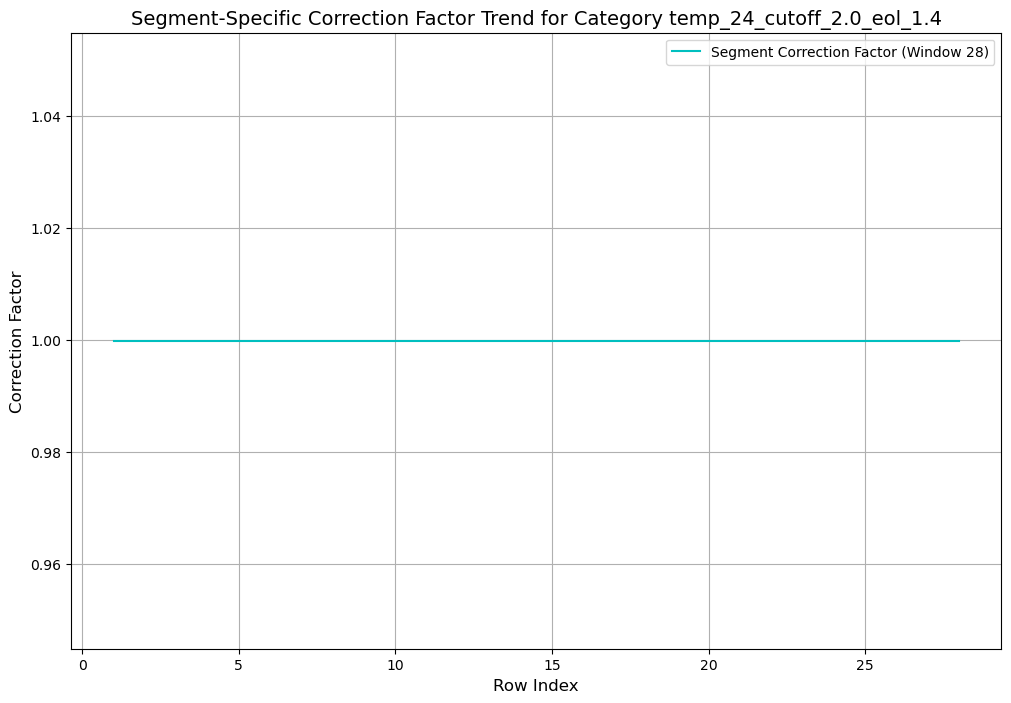


Processing category with conditions: (43, 2.0, 1.4)
Batteries: ['B0029']


[I 2025-03-25 14:37:28,957] A new study created in memory with name: no-name-c33987a6-491f-4107-9a0a-f44674f108b6
[I 2025-03-25 14:37:28,978] Trial 0 finished with value: 15480.85866516918 and parameters: {'window_size': 30}. Best is trial 0 with value: 15480.85866516918.
[I 2025-03-25 14:37:28,981] Trial 1 finished with value: 15560.143563874164 and parameters: {'window_size': 20}. Best is trial 0 with value: 15480.85866516918.
[I 2025-03-25 14:37:29,000] Trial 2 finished with value: 15707.982204075268 and parameters: {'window_size': 15}. Best is trial 0 with value: 15480.85866516918.
[I 2025-03-25 14:37:29,014] Trial 3 finished with value: 15529.083090581213 and parameters: {'window_size': 24}. Best is trial 0 with value: 15480.85866516918.
[I 2025-03-25 14:37:29,044] Trial 4 finished with value: 15663.564365488555 and parameters: {'window_size': 14}. Best is trial 0 with value: 15480.85866516918.
[I 2025-03-25 14:37:29,064] Trial 5 finished with value: 15646.97680923085 and paramete

Cycling data saved to: battery_data\NASA_cycle_dataset_B0029.csv
Capacity data saved to: battery_data\capacity_soh_B0029.csv
Macro aging data saved to: battery_data\macro_aging_B0029.csv
Category data shape: (40, 10)


[I 2025-03-25 14:37:29,148] Trial 9 finished with value: 15862.594692335333 and parameters: {'window_size': 4}. Best is trial 0 with value: 15480.85866516918.
[I 2025-03-25 14:37:29,163] Trial 10 finished with value: 15447.473141458448 and parameters: {'window_size': 40}. Best is trial 10 with value: 15447.473141458448.
[I 2025-03-25 14:37:29,176] Trial 11 finished with value: 15447.473141458448 and parameters: {'window_size': 40}. Best is trial 10 with value: 15447.473141458448.
[I 2025-03-25 14:37:29,188] Trial 12 finished with value: 15447.473141458448 and parameters: {'window_size': 40}. Best is trial 10 with value: 15447.473141458448.
[I 2025-03-25 14:37:29,197] Trial 13 finished with value: 15447.473141458448 and parameters: {'window_size': 40}. Best is trial 10 with value: 15447.473141458448.
[I 2025-03-25 14:37:29,220] Trial 14 finished with value: 15480.191048102302 and parameters: {'window_size': 34}. Best is trial 10 with value: 15447.473141458448.
[I 2025-03-25 14:37:29,230


Optimal Window Size for Condition (43, 2.0, 1.4): 40
Best MHE MSE: 15447.4731


[I 2025-03-25 14:37:31,230] Trial 16 finished with value: 1.552687398352949 and parameters: {'Q': 0.00994834122257962, 'R': 0.00010583165416148176, 'trend_rate': 0.04717720334750385}. Best is trial 11 with value: 1.5153718663660154.
[I 2025-03-25 14:37:31,257] Trial 17 finished with value: 8.51867945679903 and parameters: {'Q': 7.022491540566685e-05, 'R': 0.08372923923792529, 'trend_rate': -0.02125763950382923}. Best is trial 11 with value: 1.5153718663660154.
[I 2025-03-25 14:37:31,279] Trial 18 finished with value: 2.0476130549948444 and parameters: {'Q': 0.00034616632566999414, 'R': 0.0037693061158366914, 'trend_rate': 0.07109438961704022}. Best is trial 11 with value: 1.5153718663660154.
[I 2025-03-25 14:37:31,299] Trial 19 finished with value: 1.5152291533388296 and parameters: {'Q': 0.0026645944939048248, 'R': 0.0025134664473396013, 'trend_rate': 0.03966147997954858}. Best is trial 19 with value: 1.5152291533388296.
[I 2025-03-25 14:37:31,315] Trial 20 finished with value: 1.5163

Category corrected and smoothed SOH data saved to: battery_data\category_temp_43_cutoff_2.0_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.0, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9998

Error Metrics for Condition (43, 2.0, 1.4):
MSE (Smoothed vs Ground Truth): 1.5151
RMSE (Smoothed vs Ground Truth): 1.2309
MSE (Smoothed vs Final Cyclic Aging): 0.0305
RMSE (Smoothed vs Final Cyclic Aging): 0.1747


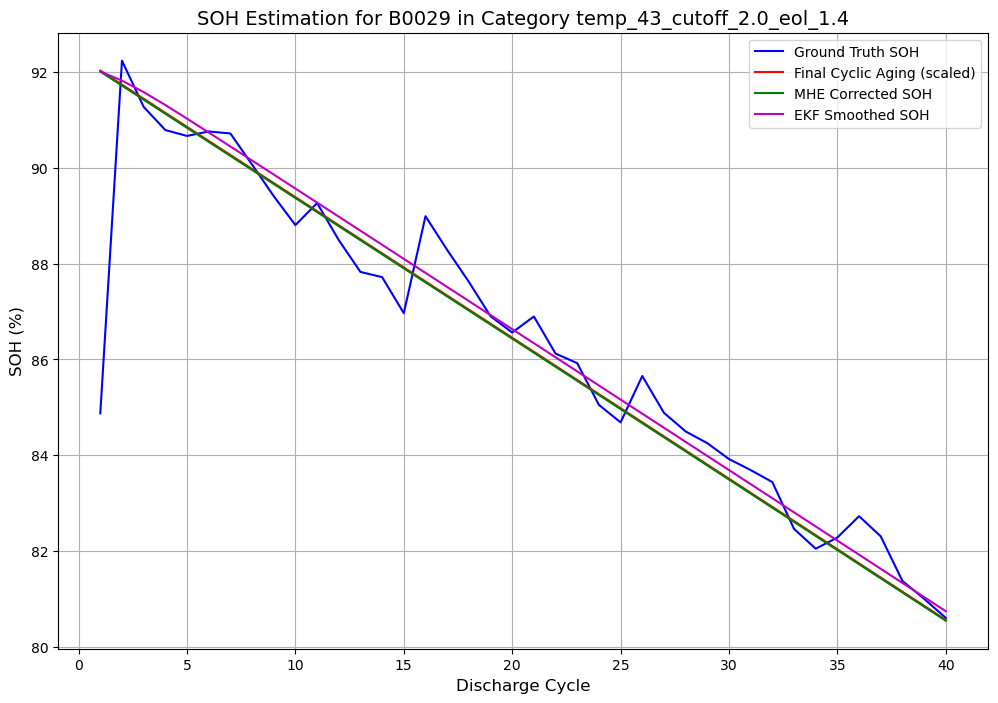

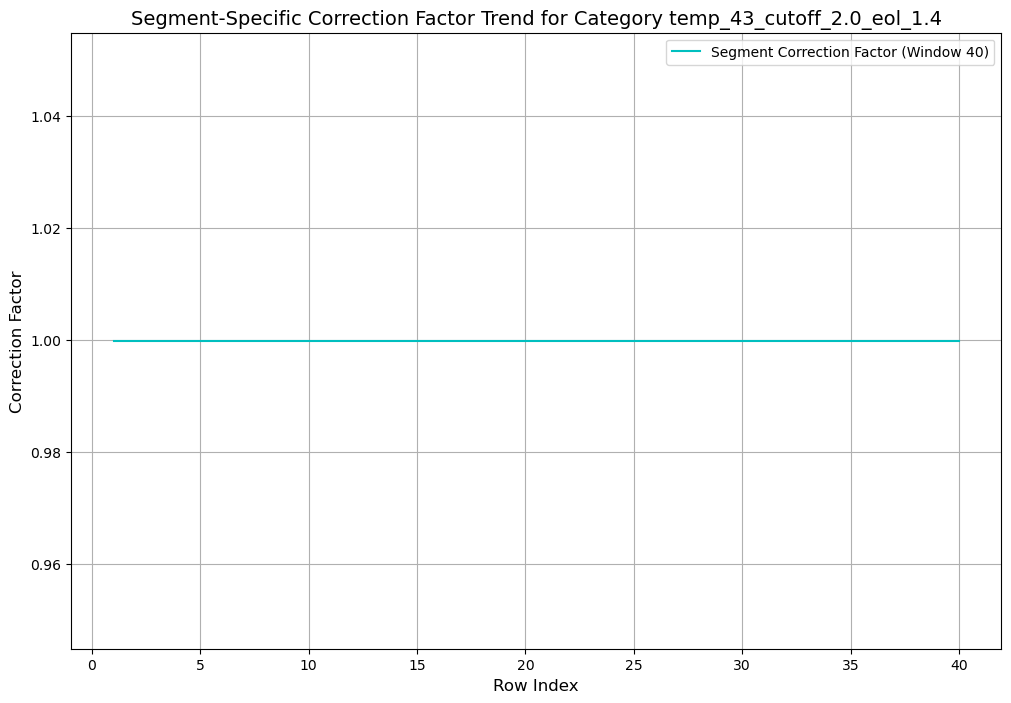


Processing category with conditions: (43, 2.2, 1.4)
Batteries: ['B0030']


[I 2025-03-25 14:37:35,553] A new study created in memory with name: no-name-e7904bfc-d3d6-4c3e-8b8b-a72c364bbf9d
[I 2025-03-25 14:37:35,579] Trial 0 finished with value: 15905.872025549224 and parameters: {'window_size': 14}. Best is trial 0 with value: 15905.872025549224.
[I 2025-03-25 14:37:35,595] Trial 1 finished with value: 15867.066342938175 and parameters: {'window_size': 16}. Best is trial 1 with value: 15867.066342938175.
[I 2025-03-25 14:37:35,613] Trial 2 finished with value: 15731.495373896136 and parameters: {'window_size': 29}. Best is trial 2 with value: 15731.495373896136.
[I 2025-03-25 14:37:35,630] Trial 3 finished with value: 15960.533799758721 and parameters: {'window_size': 15}. Best is trial 2 with value: 15731.495373896136.
[I 2025-03-25 14:37:35,645] Trial 4 finished with value: 15803.777233836945 and parameters: {'window_size': 18}. Best is trial 2 with value: 15731.495373896136.
[I 2025-03-25 14:37:35,662] Trial 5 finished with value: 15748.441502861926 and p

Cycling data saved to: battery_data\NASA_cycle_dataset_B0030.csv
Capacity data saved to: battery_data\capacity_soh_B0030.csv
Macro aging data saved to: battery_data\macro_aging_B0030.csv
Category data shape: (40, 10)


[I 2025-03-25 14:37:35,747] Trial 10 finished with value: 16188.330967036363 and parameters: {'window_size': 3}. Best is trial 6 with value: 15615.338092128215.
[I 2025-03-25 14:37:35,765] Trial 11 finished with value: 15615.338092128215 and parameters: {'window_size': 40}. Best is trial 6 with value: 15615.338092128215.
[I 2025-03-25 14:37:35,792] Trial 12 finished with value: 15615.338092128215 and parameters: {'window_size': 40}. Best is trial 6 with value: 15615.338092128215.
[I 2025-03-25 14:37:35,798] Trial 13 finished with value: 15750.45629360503 and parameters: {'window_size': 35}. Best is trial 6 with value: 15615.338092128215.
[I 2025-03-25 14:37:35,825] Trial 14 finished with value: 15722.10060530228 and parameters: {'window_size': 32}. Best is trial 6 with value: 15615.338092128215.
[I 2025-03-25 14:37:35,841] Trial 15 finished with value: 15750.45629360503 and parameters: {'window_size': 35}. Best is trial 6 with value: 15615.338092128215.
[I 2025-03-25 14:37:35,855] Tria


Optimal Window Size for Condition (43, 2.2, 1.4): 40
Best MHE MSE: 15615.3381


[I 2025-03-25 14:37:37,944] Trial 16 finished with value: 1.3688267993073864 and parameters: {'Q': 0.00046432887360417627, 'R': 0.0002035411521316603, 'trend_rate': -0.09792265399856942}. Best is trial 7 with value: 1.3597415089742584.
[I 2025-03-25 14:37:37,967] Trial 17 finished with value: 1.77269362265806 and parameters: {'Q': 7.931527275334681e-05, 'R': 0.001141936712353432, 'trend_rate': -0.008647489352632293}. Best is trial 7 with value: 1.3597415089742584.
[I 2025-03-25 14:37:37,980] Trial 18 finished with value: 1.3776307700849353 and parameters: {'Q': 0.0024122305213404964, 'R': 0.00028808806881318007, 'trend_rate': -0.03957251354233215}. Best is trial 7 with value: 1.3597415089742584.
[I 2025-03-25 14:37:38,006] Trial 19 finished with value: 7.6498421406300166 and parameters: {'Q': 2.522134244434487e-05, 'R': 0.005551918155532806, 'trend_rate': 0.03758746710679455}. Best is trial 7 with value: 1.3597415089742584.
[I 2025-03-25 14:37:38,028] Trial 20 finished with value: 3.07

Category corrected and smoothed SOH data saved to: battery_data\category_temp_43_cutoff_2.2_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.2, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9997

Error Metrics for Condition (43, 2.2, 1.4):
MSE (Smoothed vs Ground Truth): 1.3577
RMSE (Smoothed vs Ground Truth): 1.1652
MSE (Smoothed vs Final Cyclic Aging): 0.0209
RMSE (Smoothed vs Final Cyclic Aging): 0.1446


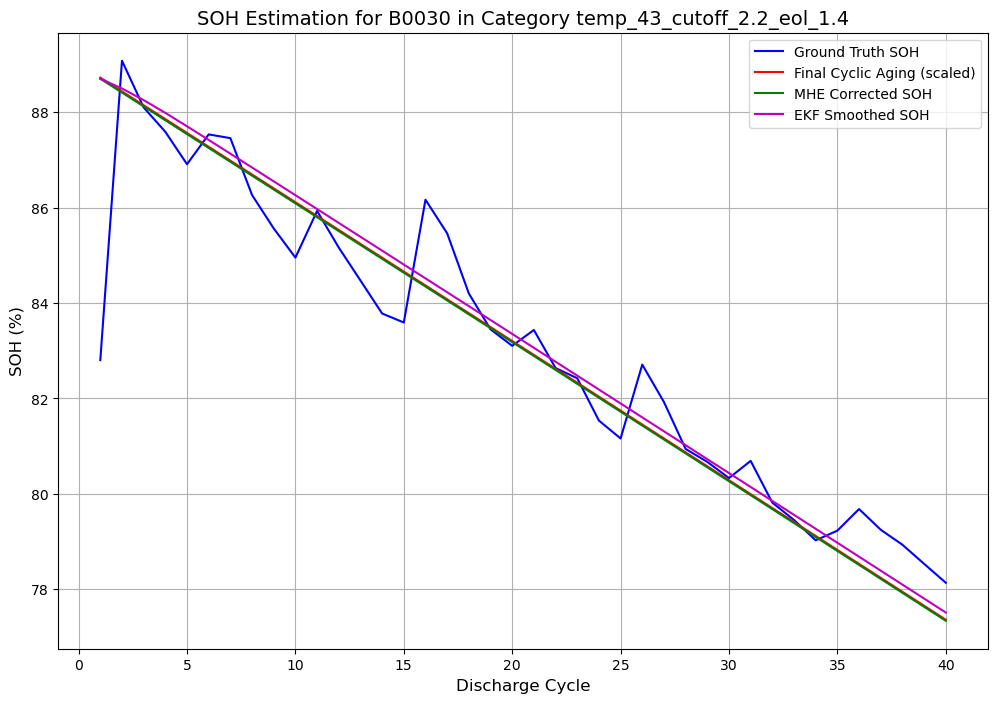

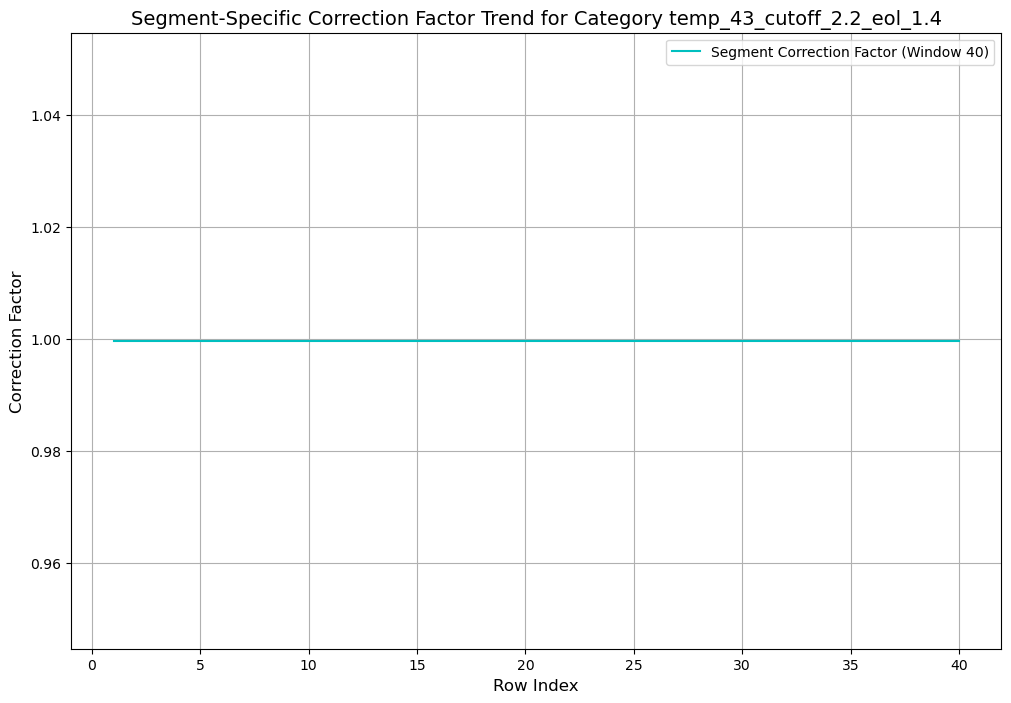


Processing category with conditions: (43, 2.5, 1.4)
Batteries: ['B0031']


[I 2025-03-25 14:37:42,414] A new study created in memory with name: no-name-6dd9d101-5026-43b9-9875-e5d40341cfed
[I 2025-03-25 14:37:42,431] Trial 0 finished with value: 14880.68586279869 and parameters: {'window_size': 14}. Best is trial 0 with value: 14880.68586279869.
[I 2025-03-25 14:37:42,448] Trial 1 finished with value: 13735.387998108421 and parameters: {'window_size': 31}. Best is trial 1 with value: 13735.387998108421.
[I 2025-03-25 14:37:42,464] Trial 2 finished with value: 14880.68586279869 and parameters: {'window_size': 14}. Best is trial 1 with value: 13735.387998108421.
[I 2025-03-25 14:37:42,481] Trial 3 finished with value: 15324.562053434849 and parameters: {'window_size': 8}. Best is trial 1 with value: 13735.387998108421.
[I 2025-03-25 14:37:42,499] Trial 4 finished with value: 14325.7548355016 and parameters: {'window_size': 23}. Best is trial 1 with value: 13735.387998108421.
[I 2025-03-25 14:37:42,516] Trial 5 finished with value: 14325.7548355016 and parameter

Cycling data saved to: battery_data\NASA_cycle_dataset_B0031.csv
Capacity data saved to: battery_data\capacity_soh_B0031.csv
Macro aging data saved to: battery_data\macro_aging_B0031.csv
Category data shape: (40, 10)


[I 2025-03-25 14:37:42,595] Trial 11 finished with value: 12649.957369766193 and parameters: {'window_size': 40}. Best is trial 11 with value: 12649.957369766193.
[I 2025-03-25 14:37:42,610] Trial 12 finished with value: 12649.957369766193 and parameters: {'window_size': 40}. Best is trial 11 with value: 12649.957369766193.
[I 2025-03-25 14:37:42,627] Trial 13 finished with value: 12768.601310998813 and parameters: {'window_size': 39}. Best is trial 11 with value: 12649.957369766193.
[I 2025-03-25 14:37:42,644] Trial 14 finished with value: 13557.861828646908 and parameters: {'window_size': 33}. Best is trial 11 with value: 12649.957369766193.
[I 2025-03-25 14:37:42,661] Trial 15 finished with value: 13198.524364736173 and parameters: {'window_size': 36}. Best is trial 11 with value: 12649.957369766193.
[I 2025-03-25 14:37:42,679] Trial 16 finished with value: 13981.929427427902 and parameters: {'window_size': 28}. Best is trial 11 with value: 12649.957369766193.
[I 2025-03-25 14:37:42


Optimal Window Size for Condition (43, 2.5, 1.4): 40
Best MHE MSE: 12649.9574


[I 2025-03-25 14:37:44,562] Trial 16 finished with value: 4.224065729640174 and parameters: {'Q': 1.1788041316362495e-05, 'R': 0.0003278764271640832, 'trend_rate': -0.04356247954664009}. Best is trial 14 with value: 4.19353445005176.
[I 2025-03-25 14:37:44,597] Trial 17 finished with value: 4.891866936847288 and parameters: {'Q': 5.164020088884052e-06, 'R': 0.0013803649350899437, 'trend_rate': -0.08277123080922558}. Best is trial 14 with value: 4.19353445005176.
[I 2025-03-25 14:37:44,644] Trial 18 finished with value: 4.578756209188613 and parameters: {'Q': 2.9875073734285778e-05, 'R': 0.0018076050173044362, 'trend_rate': -0.03468067219061741}. Best is trial 14 with value: 4.19353445005176.
[I 2025-03-25 14:37:44,691] Trial 19 finished with value: 4.306010945854546 and parameters: {'Q': 0.0007409912580072348, 'R': 0.00031248472835914917, 'trend_rate': -0.027120923450348302}. Best is trial 14 with value: 4.19353445005176.
[I 2025-03-25 14:37:44,742] Trial 20 finished with value: 4.2233

Category corrected and smoothed SOH data saved to: battery_data\category_temp_43_cutoff_2.5_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.5, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9992

Error Metrics for Condition (43, 2.5, 1.4):
MSE (Smoothed vs Ground Truth): 4.0592
RMSE (Smoothed vs Ground Truth): 2.0147
MSE (Smoothed vs Final Cyclic Aging): 0.6671
RMSE (Smoothed vs Final Cyclic Aging): 0.8168


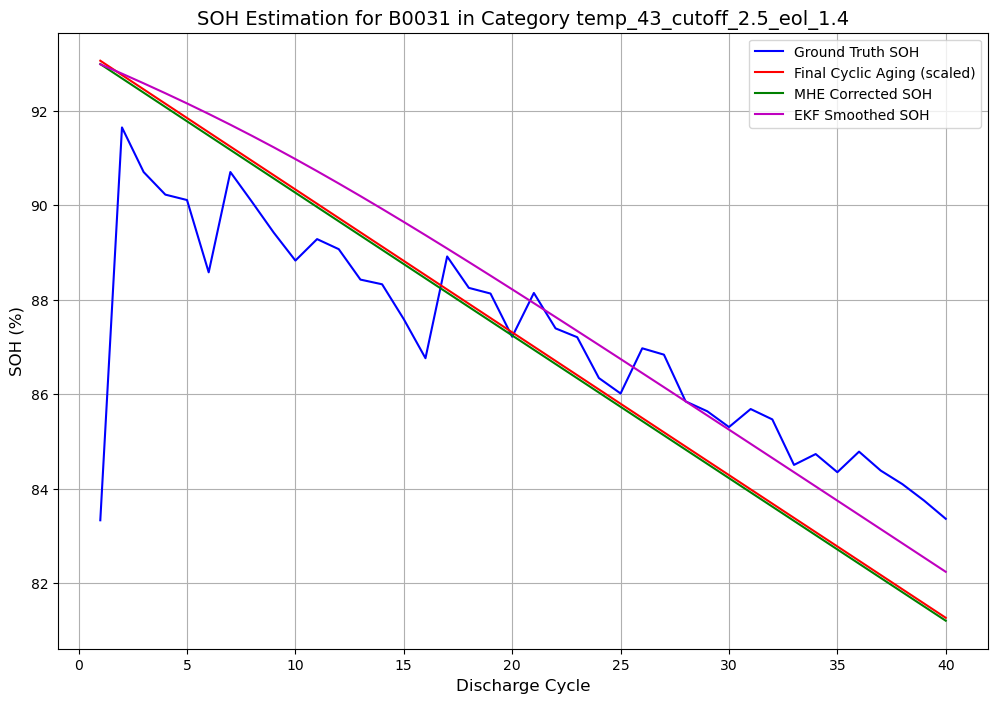

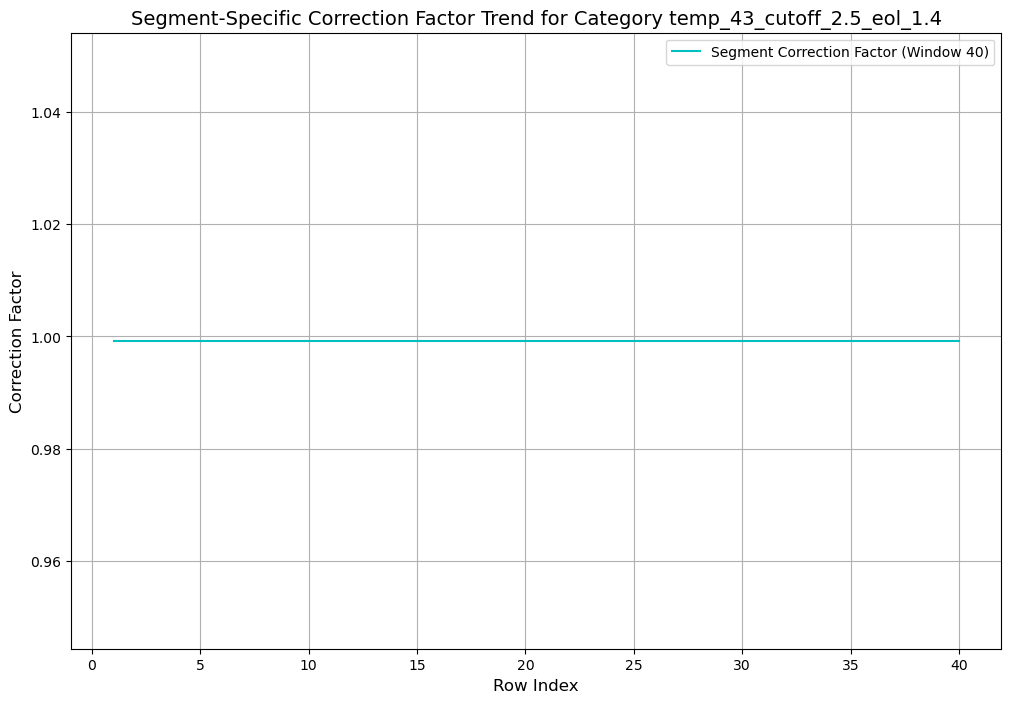


Processing category with conditions: (43, 2.7, 1.4)
Batteries: ['B0032']


[I 2025-03-25 14:37:49,279] A new study created in memory with name: no-name-cb5bb64c-b045-43cf-a46e-84e5be8f620d
[I 2025-03-25 14:37:49,298] Trial 0 finished with value: 14876.202619041731 and parameters: {'window_size': 35}. Best is trial 0 with value: 14876.202619041731.
[I 2025-03-25 14:37:49,307] Trial 1 finished with value: 14917.927621093475 and parameters: {'window_size': 25}. Best is trial 0 with value: 14876.202619041731.
[I 2025-03-25 14:37:49,315] Trial 2 finished with value: 14895.593490990761 and parameters: {'window_size': 24}. Best is trial 0 with value: 14876.202619041731.
[I 2025-03-25 14:37:49,331] Trial 3 finished with value: 14992.8210011884 and parameters: {'window_size': 10}. Best is trial 0 with value: 14876.202619041731.
[I 2025-03-25 14:37:49,342] Trial 4 finished with value: 14831.404604937528 and parameters: {'window_size': 36}. Best is trial 4 with value: 14831.404604937528.
[I 2025-03-25 14:37:49,358] Trial 5 finished with value: 14926.283243880323 and par

Cycling data saved to: battery_data\NASA_cycle_dataset_B0032.csv
Capacity data saved to: battery_data\capacity_soh_B0032.csv
Macro aging data saved to: battery_data\macro_aging_B0032.csv
Category data shape: (40, 10)


[I 2025-03-25 14:37:49,458] Trial 11 finished with value: 14803.39693995835 and parameters: {'window_size': 40}. Best is trial 8 with value: 14803.39693995835.
[I 2025-03-25 14:37:49,475] Trial 12 finished with value: 14803.39693995835 and parameters: {'window_size': 40}. Best is trial 8 with value: 14803.39693995835.
[I 2025-03-25 14:37:49,491] Trial 13 finished with value: 14888.328459861294 and parameters: {'window_size': 30}. Best is trial 8 with value: 14803.39693995835.
[I 2025-03-25 14:37:49,508] Trial 14 finished with value: 14803.39693995835 and parameters: {'window_size': 40}. Best is trial 8 with value: 14803.39693995835.
[I 2025-03-25 14:37:49,525] Trial 15 finished with value: 14888.328459861294 and parameters: {'window_size': 30}. Best is trial 8 with value: 14803.39693995835.
[I 2025-03-25 14:37:49,558] Trial 16 finished with value: 14981.098799978476 and parameters: {'window_size': 13}. Best is trial 8 with value: 14803.39693995835.
[I 2025-03-25 14:37:49,575] Trial 17 


Optimal Window Size for Condition (43, 2.7, 1.4): 40
Best MHE MSE: 14803.3969


[I 2025-03-25 14:37:51,432] Trial 15 finished with value: 15.274114937483528 and parameters: {'Q': 1.195179768252832e-06, 'R': 0.006825716821637992, 'trend_rate': 0.03987123562722235}. Best is trial 6 with value: 2.151872299569589.
[I 2025-03-25 14:37:51,458] Trial 16 finished with value: 2.1726160752892847 and parameters: {'Q': 0.004451191653024297, 'R': 0.001332990073532512, 'trend_rate': -0.020734013466523062}. Best is trial 6 with value: 2.151872299569589.
[I 2025-03-25 14:37:51,476] Trial 17 finished with value: 2.6475622659278613 and parameters: {'Q': 5.449310726185038e-05, 'R': 0.0005624227582712825, 'trend_rate': 0.051884523390118016}. Best is trial 6 with value: 2.151872299569589.
[I 2025-03-25 14:37:51,508] Trial 18 finished with value: 12.520032749490868 and parameters: {'Q': 0.0004398141145475155, 'R': 0.09822434941954142, 'trend_rate': 0.09911950792553889}. Best is trial 6 with value: 2.151872299569589.
[I 2025-03-25 14:37:51,525] Trial 19 finished with value: 2.1895320641

Category corrected and smoothed SOH data saved to: battery_data\category_temp_43_cutoff_2.7_eol_1.4_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (43, 2.7, 1.4) (Window Size: 40):
Segment 1 (Rows 1-40): k = 0.9998

Error Metrics for Condition (43, 2.7, 1.4):
MSE (Smoothed vs Ground Truth): 2.1519
RMSE (Smoothed vs Ground Truth): 1.4669
MSE (Smoothed vs Final Cyclic Aging): 0.0306
RMSE (Smoothed vs Final Cyclic Aging): 0.1750


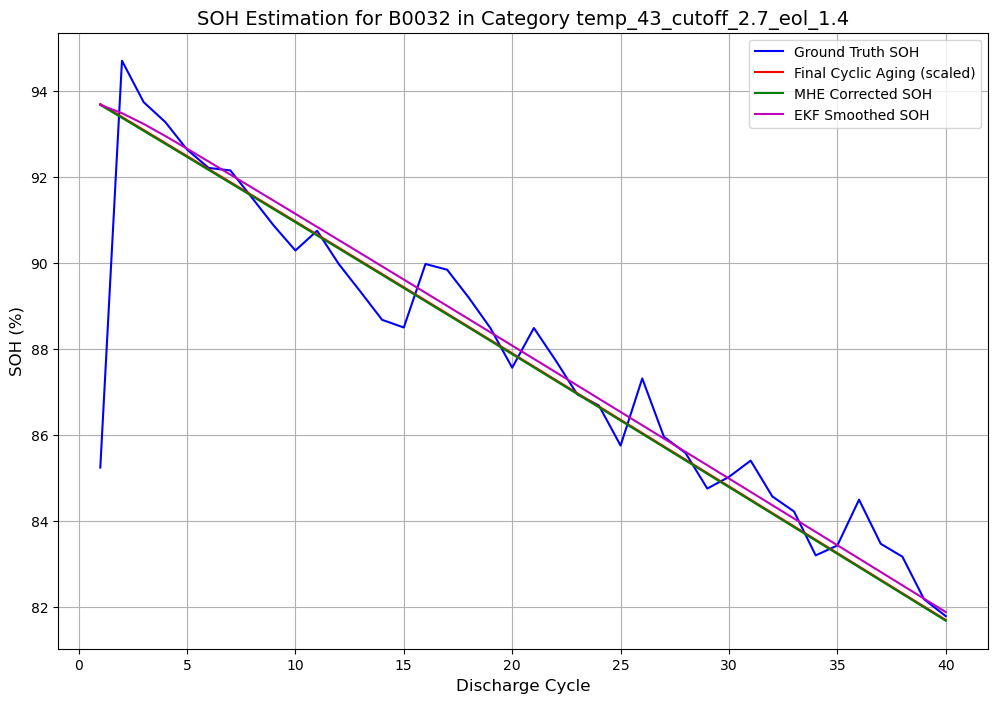

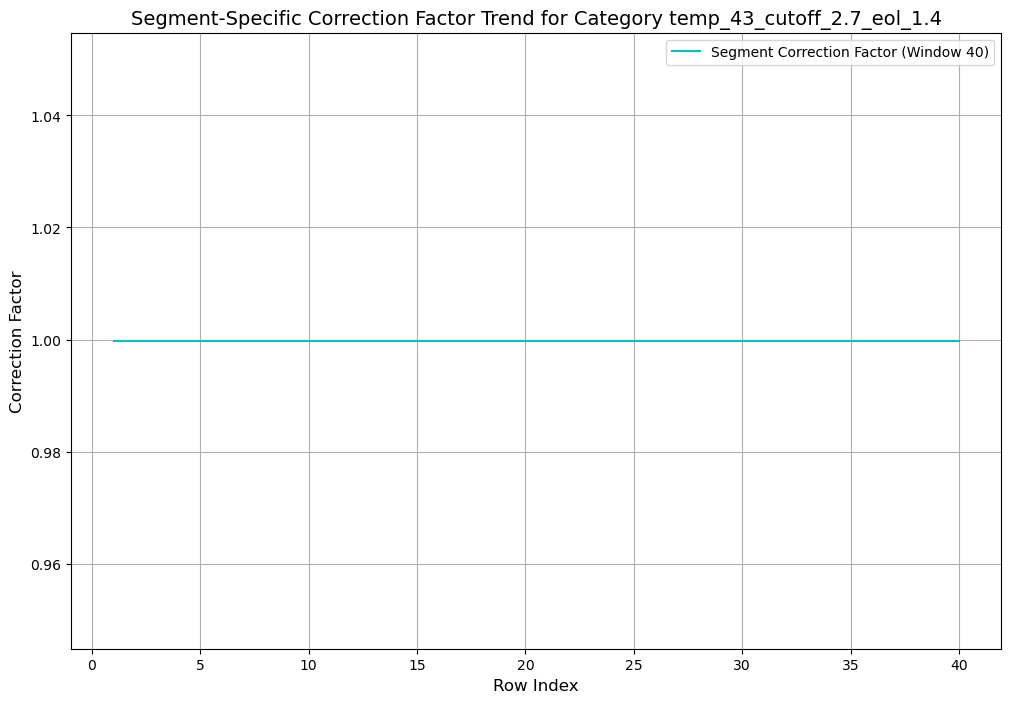


Processing category with conditions: (24, 2.0, 1.6)
Batteries: ['B0033']


[I 2025-03-25 14:38:04,839] A new study created in memory with name: no-name-d7009b88-2391-46c0-af68-0e49f6402d38
[I 2025-03-25 14:38:04,855] Trial 0 finished with value: 144764.26011069876 and parameters: {'window_size': 34}. Best is trial 0 with value: 144764.26011069876.
[I 2025-03-25 14:38:04,867] Trial 1 finished with value: 189454.27078788038 and parameters: {'window_size': 141}. Best is trial 0 with value: 144764.26011069876.
[I 2025-03-25 14:38:04,908] Trial 2 finished with value: 107246.49681246272 and parameters: {'window_size': 16}. Best is trial 2 with value: 107246.49681246272.
[I 2025-03-25 14:38:04,928] Trial 3 finished with value: 146670.52771041868 and parameters: {'window_size': 42}. Best is trial 2 with value: 107246.49681246272.
[I 2025-03-25 14:38:04,939] Trial 4 finished with value: 192727.54941543765 and parameters: {'window_size': 106}. Best is trial 2 with value: 107246.49681246272.


Cycling data saved to: battery_data\NASA_cycle_dataset_B0033.csv
Capacity data saved to: battery_data\capacity_soh_B0033.csv
Macro aging data saved to: battery_data\macro_aging_B0033.csv
Category data shape: (197, 10)


[I 2025-03-25 14:38:04,949] Trial 5 finished with value: 207171.31036120126 and parameters: {'window_size': 192}. Best is trial 2 with value: 107246.49681246272.
[I 2025-03-25 14:38:04,962] Trial 6 finished with value: 144255.43548443023 and parameters: {'window_size': 78}. Best is trial 2 with value: 107246.49681246272.
[I 2025-03-25 14:38:04,962] Trial 7 finished with value: 200681.7554330859 and parameters: {'window_size': 135}. Best is trial 2 with value: 107246.49681246272.
[I 2025-03-25 14:38:04,980] Trial 8 finished with value: 152520.7349652376 and parameters: {'window_size': 158}. Best is trial 2 with value: 107246.49681246272.
[I 2025-03-25 14:38:04,999] Trial 9 finished with value: 124717.28975451234 and parameters: {'window_size': 38}. Best is trial 2 with value: 107246.49681246272.
[I 2025-03-25 14:38:05,138] Trial 10 finished with value: 8213.325765317331 and parameters: {'window_size': 3}. Best is trial 10 with value: 8213.325765317331.
[I 2025-03-25 14:38:05,289] Trial 


Optimal Window Size for Condition (24, 2.0, 1.6): 3
Best MHE MSE: 8213.3258


[I 2025-03-25 14:38:11,047] Trial 7 finished with value: 704.8833513351036 and parameters: {'Q': 0.000957726710817675, 'R': 0.00046346542872324623, 'trend_rate': -0.09916816444289218}. Best is trial 5 with value: 704.3444983161866.
[I 2025-03-25 14:38:11,048] Trial 8 finished with value: 704.1796944562457 and parameters: {'Q': 2.0741949861906796e-06, 'R': 0.0009289265620738101, 'trend_rate': 0.06819091059692373}. Best is trial 8 with value: 704.1796944562457.
[I 2025-03-25 14:38:11,048] Trial 9 finished with value: 704.8262374474638 and parameters: {'Q': 9.543662630689656e-06, 'R': 0.00021925501614271896, 'trend_rate': -0.09186316113089865}. Best is trial 8 with value: 704.1796944562457.
[I 2025-03-25 14:38:11,079] Trial 10 finished with value: 704.093269704979 and parameters: {'Q': 1.0812301856058503e-06, 'R': 0.008527910869913136, 'trend_rate': 0.09471576587548775}. Best is trial 10 with value: 704.093269704979.
[I 2025-03-25 14:38:11,099] Trial 11 finished with value: 704.0837843688

Category corrected and smoothed SOH data saved to: battery_data\category_temp_24_cutoff_2.2_eol_1.6_mhe_ekf_optuna.csv

Segment-Specific Correction Factors for Condition (24, 2.2, 1.6) (Window Size: 4):
Segment 1 (Rows 1-4): k = 0.7915
Segment 2 (Rows 5-8): k = 0.8514
Segment 3 (Rows 9-12): k = 0.8231
Segment 4 (Rows 13-16): k = 0.8229
Segment 5 (Rows 17-20): k = 0.8567
Segment 6 (Rows 21-24): k = 0.8983
Segment 7 (Rows 25-28): k = 0.8812
Segment 8 (Rows 29-32): k = 0.8638
Segment 9 (Rows 33-36): k = 0.8679
Segment 10 (Rows 37-40): k = 0.8959
Segment 11 (Rows 41-44): k = 0.9143
Segment 12 (Rows 45-48): k = 1.0106
Segment 13 (Rows 49-52): k = 0.9536
Segment 14 (Rows 53-56): k = 0.9296
Segment 15 (Rows 57-60): k = 0.9344
Segment 16 (Rows 61-64): k = 0.9362
Segment 17 (Rows 65-68): k = 0.9691
Segment 18 (Rows 69-72): k = 0.9671
Segment 19 (Rows 73-76): k = 0.9737
Segment 20 (Rows 77-80): k = 0.9294
Segment 21 (Rows 81-84): k = 0.9353
Segment 22 (Rows 85-88): k = 0.9451
Segment 23 (Rows 89

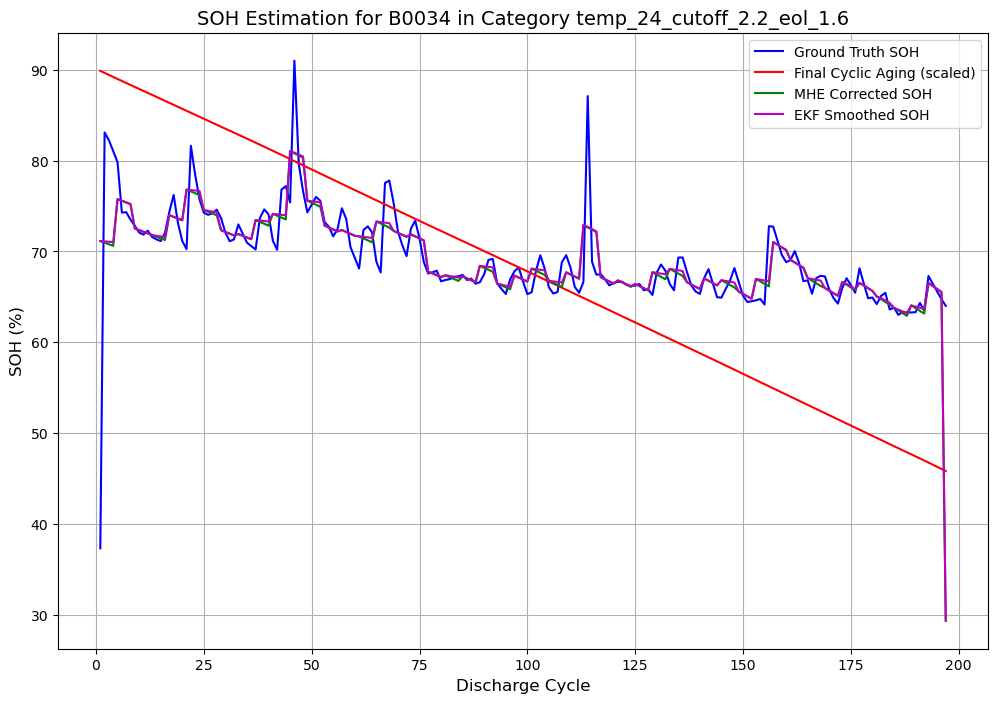

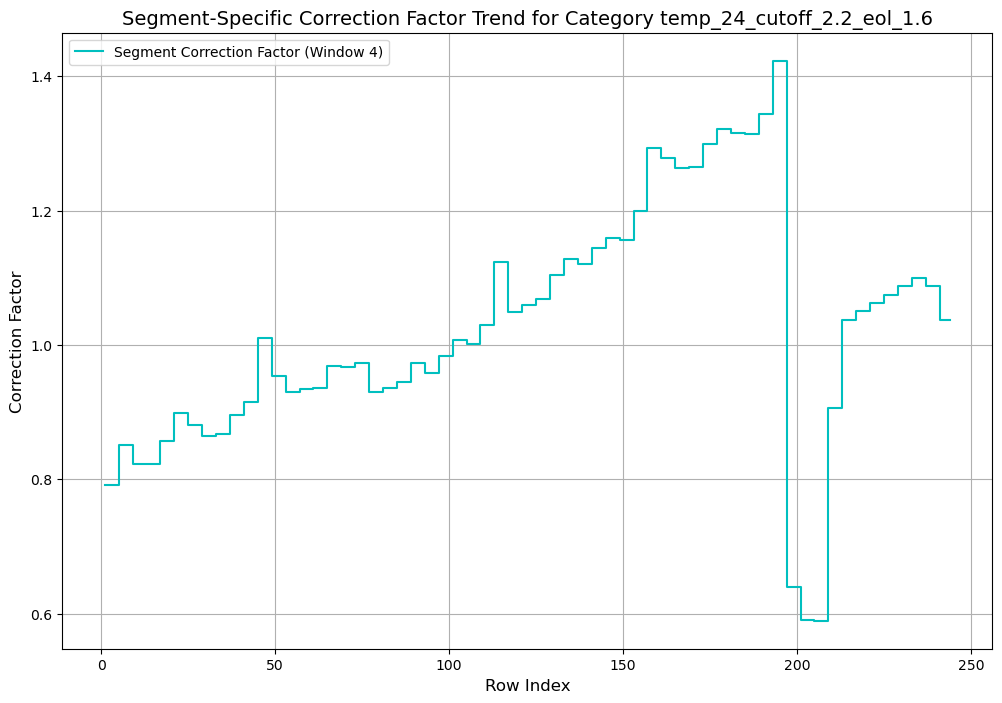


Processing category with conditions: (24, 2.7, 1.6)
Batteries: ['B0036', 'B0040']
Cycling data saved to: battery_data\NASA_cycle_dataset_B0036.csv
Capacity data saved to: battery_data\capacity_soh_B0036.csv
Macro aging data saved to: battery_data\macro_aging_B0036.csv


[I 2025-03-25 14:41:09,002] A new study created in memory with name: no-name-c025809b-eb54-419b-85d5-09969f1cf7ce
[I 2025-03-25 14:41:09,015] Trial 0 finished with value: 230355.40389909878 and parameters: {'window_size': 85}. Best is trial 0 with value: 230355.40389909878.
[I 2025-03-25 14:41:09,022] Trial 1 finished with value: 287705.4870315809 and parameters: {'window_size': 158}. Best is trial 0 with value: 230355.40389909878.
[I 2025-03-25 14:41:09,033] Trial 2 finished with value: 274095.7508967845 and parameters: {'window_size': 167}. Best is trial 0 with value: 230355.40389909878.
[I 2025-03-25 14:41:09,041] Trial 3 finished with value: 302753.8147318109 and parameters: {'window_size': 140}. Best is trial 0 with value: 230355.40389909878.
[I 2025-03-25 14:41:09,072] Trial 4 finished with value: 160591.20755365188 and parameters: {'window_size': 26}. Best is trial 4 with value: 160591.20755365188.
[I 2025-03-25 14:41:09,106] Trial 5 finished with value: 146526.67970919353 and p

Cycling data saved to: battery_data\NASA_cycle_dataset_B0040.csv
Capacity data saved to: battery_data\capacity_soh_B0040.csv
Macro aging data saved to: battery_data\macro_aging_B0040.csv
Category data shape: (244, 10)


[I 2025-03-25 14:41:09,168] Trial 9 finished with value: 201978.16208754343 and parameters: {'window_size': 195}. Best is trial 5 with value: 146526.67970919353.
[I 2025-03-25 14:41:09,184] Trial 10 finished with value: 200289.4945213164 and parameters: {'window_size': 90}. Best is trial 5 with value: 146526.67970919353.
[I 2025-03-25 14:41:09,238] Trial 11 finished with value: 135295.27390293963 and parameters: {'window_size': 20}. Best is trial 11 with value: 135295.27390293963.
[I 2025-03-25 14:41:09,372] Trial 12 finished with value: 34535.046764619954 and parameters: {'window_size': 7}. Best is trial 12 with value: 34535.046764619954.
[I 2025-03-25 14:41:09,604] Trial 13 finished with value: 30574.39707404543 and parameters: {'window_size': 3}. Best is trial 13 with value: 30574.39707404543.
[I 2025-03-25 14:41:09,826] Trial 14 finished with value: 30574.39707404543 and parameters: {'window_size': 3}. Best is trial 13 with value: 30574.39707404543.
[I 2025-03-25 14:41:09,847] Tria


Optimal Window Size for Condition (24, 2.7, 1.6): 4
Best MHE MSE: 30263.9998


[I 2025-03-25 14:41:17,239] Trial 4 finished with value: 304.3545110890133 and parameters: {'Q': 2.462162920606756e-06, 'R': 0.00015811560318748736, 'trend_rate': -0.06802880385031479}. Best is trial 0 with value: 302.7579082980834.
[I 2025-03-25 14:41:17,241] Trial 5 finished with value: 302.7390373343212 and parameters: {'Q': 0.000279686553724997, 'R': 0.0201594512552093, 'trend_rate': 0.040252899893216176}. Best is trial 5 with value: 302.7390373343212.
[I 2025-03-25 14:41:17,243] Trial 6 finished with value: 302.2903965262425 and parameters: {'Q': 1.4678616600188423e-06, 'R': 0.0005385349724715455, 'trend_rate': 0.06840002671095874}. Best is trial 6 with value: 302.2903965262425.
[I 2025-03-25 14:41:17,246] Trial 7 finished with value: 303.4329080831462 and parameters: {'Q': 0.0010810169337232673, 'R': 0.040975644121075336, 'trend_rate': -0.005838891163633869}. Best is trial 6 with value: 302.2903965262425.
[I 2025-03-25 14:41:17,248] Trial 8 finished with value: 301.96123988410494

In [ ]:
with open("battery_params.json", 'r') as json_file:
    battery_params = json.load(json_file)
dataset_folder = 'battery_data'
results = process_batteries_by_category_with_mhe(dataset_folder, battery_params, n_trials_mhe=100, n_trials_ekf=50)